<a href="https://colab.research.google.com/github/AlirezaPNouri/BERTEmbedding/blob/main/FebVersionOfBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Alireza Nouri

Supervisor: prof. Mahmud Shahriar Hossain

database source: https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/5KArticles.csv

This is the version that I modified and optimized for my research.

02/ 07/ 2022

In [1]:
#install needed packages
!pip install transformers
!pip install wget
!pip install statistics

In [2]:
# libraries that are needed to import
import os
import time
import datetime
import sys
import random
import requests
import pickle
import string
import pandas as pd
import numpy as np
from numpy import median, array, exp
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer

In [62]:
# All configs are here
MAX_DATA = 1000 # the maximum data that is extracted from the dataset
max_length = 256 # maximum number of tokens in a document (Bert input)
batch_size = 16 # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
epochs = 20 # Number of training epochs (authors recommend between 2 and 4)
seed_val = 42 # Set the seed value all over the place to make this reproducible.
Max_Feature_Size = 20  ## ignore the features after this number
number_of_test_data = 100 # number of data in testing phase
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']
jump = 3 # jump size for gradient decent
range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
doc_num = 18 # document number for experiiments
threshold_cluster_overlapping = 0.8 # the after jaccard index that we use to consider two clusters are overlapping 

In [4]:
# Function to remove stopwords
def stop_word_remover(list1, stopwords):
  new_list = list()
  for word in list1:
    if word not in stopwords:
      new_list.append(word)
  return new_list
############################################################################  
#function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return len(unique_list)
############################################################################  
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
############################################################################
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
############################################################################
#Function to find similarities
def find_similar(embedding_layers, word_index, original_sentence):
  score_dic = dict()
  print(len(original_sentence))
  for j in range(1, min(256, len(original_sentence))):
    score_dic[original_sentence[j -1]] =  cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]
    # print('word is {}, score is {}'.format(original_sentence[j -1], cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]))
  return score_dic
############################################################################
# show th t-SNE for the tokens
def tsne_plot(sentences, output):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, embed in zip(sentences, output):
        tokens.append(embed)
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
############################################################################
# Jaccard index function
def jaccard_similarity(text1_list, text2_list):
  a = set(text1_list)
  b = set(text2_list)
  return len(a.intersection(b))/len(a.union(b))
############################################################################
#function to normalize a vector
def normalizer_value(list_):
    temp_list = list()
    for vec in list_[2]:
        value = int(99* ((vec[1] - list_[1]) / (list_[0] - list_[1])) + 1)
        temp_list.append([vec[0],value])
    return temp_list

In [5]:
# to check if the GPU is ready to use

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# to tell pytorch that we are going to use GPU

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
# download the dataset as a zip file from the git repo
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/5KArticles.csv'
res = requests.get(url, allow_redirects=True)
with open('small_dataset_NYT.csv','wb') as file:
    file.write(res.content)
print('Download is done!')

Download is done!


In [7]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/small_dataset_NYT.csv", header= None, skiprows=1)
print('The original size of dataset is {}'.format(df.shape))
df = df.dropna(how='any', axis=0)

df = df[0:MAX_DATA][[1, 2]]
# Report the number of sentences.
print('Number of training sentences extracted from dataset is {:,}\n'.format(df.shape[0]))
# Display 10 random rows from the data.
df.sample(10)

df.columns = ['id', 'content']
print('Columns are : {}'.format([name for name in df.columns]))
print('The dimension of the dataset is {}'.format(df.shape))
print(df.sample)

The original size of dataset is (5001, 3)
Number of training sentences extracted from dataset is 1,000

Columns are : ['id', 'content']
The dimension of the dataset is (1000, 2)
<bound method NDFrame.sample of                    id                                            content
0    19900101_0000000  HURRYING through the tunnel at Veterans Stadiu...
1    19900101_0000001  FOR six years, American corporations have been...
2    19900101_0000002  Alcide Chaisson, who is 69 years old and lives...
3    19900101_0000003  Gary Anderson is the third-most accurate kicke...
4    19900101_0000004  The National Bank of Poland is devaluing the P...
..                ...                                                ...
995  19900111_0000997  The greeting card giant Hallmark Cards Inc. sa...
996  19900111_0000998  The police detained 15,000 people today in a s...
997  19900111_0000999  The American retailing operations of the Campe...
998  19900111_0001000  The Ralston Purina Company said it wo

In [8]:
# find the number of classes in the dataset based on the index 7 of their timestamp
sentences = df.content.values
labels = df.id.values
# print(labels)
labels = [int(d[7]) for d in labels]
# print(labels)
class_num = unique(labels)
print('The numeber of classes is {}'.format(class_num))
print('length of data is {} and length of labels is {}'.format(len(sentences), len(labels)))
print('labels are : ', labels)

The numeber of classes is 10
length of data is 1000 and length of labels is 1000
labels are :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [9]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [10]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  HURRYING through the tunnel at Veterans Stadium, the Los Angeles Rams' left guard, Tom Newberry, yelled, ''Warm-weather California sissies, huh?'' With a grin he disappeared into the locker room to calmly celebrate a 21-7 wild-card victory over the Philadelphia Eagles in a cold raw rain, which qualified the Rams to go against the Giants next Sunday at Giants Stadium in the Super Bowl XXIV tournament. But until yesterday, the Rams had always played like warm-weather California sissies in cold-weather playoff games. Until yesterday, the Rams were 0-9 in cold-weather playoff games since the franchise moved to Los Angeles from Cleveland more than four decades ago. In that time, Ram teams lost three outdoor playoff games in Minnesota (plus one in the warmth of the Metrodome a year ago), two in Washington, and one each in Cleveland, Detroit, Green Bay and Chicago. ''I'm tired of being a weatherman; if I get fired, I'm going right to the news,'' John Robinson, the Rams' coach, joke

In [11]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to us

In [12]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [13]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = class_num, # The number of output labels--2 for binary classification. # here temp is the size of the dataset
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [15]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
#Check the variables size in the memory
local_vars = list(locals().items())
for var, obj in local_vars:
  temp = sys.getsizeof(obj)
  if temp >100000:
    print(var, temp/1000000, 'MB')

df 3.949116 MB


In [17]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    embedding_layers = []
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        print(batch[2].shape)
        print(batch[1].shape)
        print(batch[0].shape)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        # print(len(outputs))
        # print(outputs[0]) the loss
        # print(len(outputs[1])) the batches
        # print(len(outputs[2])) the embedding layers
        # import numpy as np
        # print(np.shape(outputs[2]))--->(13,)
        # print(np.shape(outputs[2][1])) --->torch.Size([32, 64, 768]) the embedding in the layer one
        # print(np.shape(outputs[2][2]))--->torch.Size([32, 64, 768]) the embedding in the layer two
        # print(len(outputs[2][3]))
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 20 ========
Training...
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
to

In [18]:
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print(  "")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    #count = 0 # added by Ali
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        
        logits = outputs[0]
        # print(len(outputs))
        # print(np.shape(outputs[1])) # all embedding layers data
        # print(outputs[1][12]) # access to embedding vectors in layer 13
        #count +=1 added by Ali

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    #print(count)
print("")
print("Training complete!")


Running Validation...
  Accuracy: 0.16
  Validation took: 0:00:01

Training complete!


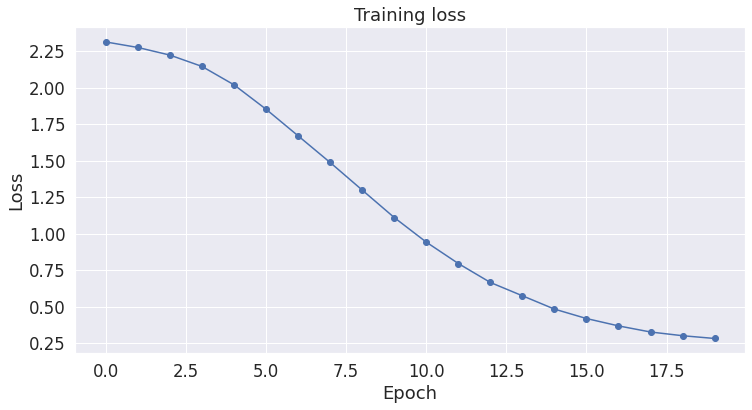

In [19]:
% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [22]:

print('size of testing data is ', df.shape)
print('Number of testing data is ', len(sentences))
print('shape of embedding is ', input_ids.shape)
print('number of labels is ', len(labels))

size of testing data is  (1000, 2)
Number of testing data is  1000
shape of embedding is  torch.Size([1000, 256])
number of labels is  1000


In [63]:
#the same as the maxlen we used in the encoder_plus function

MAX_LEN = max([len(sen) for sen in input_ids])

# Load the dataset into a pandas dataframe.
# df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = df[0:number_of_test_data]
sentences = sentences[0:number_of_test_data]
labels = labels[0:number_of_test_data]
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
# sentences = new_df.text.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = number_of_test_data  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 100



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [64]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  print('np.shape(outputs[0]) ', np.shape(outputs[0]))
  print('np.shape(outputs[1][0]) ', np.shape(outputs[1][0]))
  print('np.shape(outputs[1][1]) ', np.shape(outputs[1][1]))
  print('np.shape(outputs[1][12]) ', np.shape(outputs[1][12]))

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 100 test sentences...
np.shape(outputs[0])  torch.Size([100, 10])
np.shape(outputs[1][0])  torch.Size([100, 256, 768])
np.shape(outputs[1][1])  torch.Size([100, 256, 768])
np.shape(outputs[1][12])  torch.Size([100, 256, 768])
    DONE.


In [65]:
last_layer = outputs[1][12] # the last layer of hidden layers
# print out all the sentences
c = 0
for doc in sentences:
  print('doc {}:'.format(c), doc)
  c += 1

doc 0: HURRYING through the tunnel at Veterans Stadium, the Los Angeles Rams' left guard, Tom Newberry, yelled, ''Warm-weather California sissies, huh?'' With a grin he disappeared into the locker room to calmly celebrate a 21-7 wild-card victory over the Philadelphia Eagles in a cold raw rain, which qualified the Rams to go against the Giants next Sunday at Giants Stadium in the Super Bowl XXIV tournament. But until yesterday, the Rams had always played like warm-weather California sissies in cold-weather playoff games. Until yesterday, the Rams were 0-9 in cold-weather playoff games since the franchise moved to Los Angeles from Cleveland more than four decades ago. In that time, Ram teams lost three outdoor playoff games in Minnesota (plus one in the warmth of the Metrodome a year ago), two in Washington, and one each in Cleveland, Detroit, Green Bay and Chicago. ''I'm tired of being a weatherman; if I get fired, I'm going right to the news,'' John Robinson, the Rams' coach, joked. '

In [26]:
# pickle.dump(outputs, open("outputs.p", "wb"))
# pickle.dump(sentences, open("sentences.p", "wb"))
# pickle.dump(labels, open("labels.p", "wb"))


['with', 'demand', 'outs', '##trip', '##ping', 'capacity', 'and', 'freight', 'rates', 'rising', ',', 'the', 'new', 'year', 'might', 'seem', 'ripe', 'for', 'a', 'flood', 'of', 'orders', 'for', 'new', 'bulk', '-', 'cargo', 'ships', '-', 'a', 'flood', 'reminiscent', 'of', 'those', 'in', 'the', 'early', '1970', "'", 's', 'and', 'the', 'early', '1980', "'", 's', '.', 'but', 'that', 'will', 'not', 'be', 'the', 'case', 'this', 'time', ',', 'many', 'people', 'in', 'the', 'industry', 'say', '.', 'instead', ',', 'some', 'experts', 'and', 'executives', 'say', ',', 'the', 'emphasis', 'in', 'the', 'next', 'few', 'years', 'will', 'be', 'on', 'finding', 'ways', 'to', 'extend', 'the', 'life', 'of', 'the', 'current', 'fleet', 'of', 'freighter', '##s', 'and', 'tanker', '##s', '.', "'", "'", 'the', 'world', 'will', 'have', 'to', 'be', 'content', 'with', 'the', 'existing', 'fleet', 'of', 'elderly', 'ladies', '-', 'war', '##ts', ',', 'face', 'lifts', 'and', 'all', ',', "'", "'", 'said', 'basil', 'papa', '#

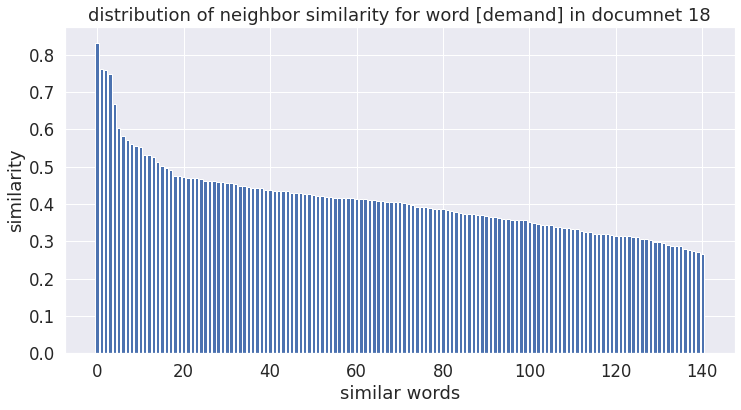

3   -->  outs
1738
[0.85322857, 0.832117, 0.80676806, 0.65224063, 0.6198505, 0.5891566, 0.5755167, 0.5336676, 0.52549076, 0.5227972, 0.52254844, 0.5219289, 0.519903, 0.50994873, 0.5047408, 0.4936458, 0.4935313, 0.48879585, 0.47727555, 0.47630066, 0.47589025, 0.47374582, 0.4725563, 0.47056592, 0.4704889, 0.4689464, 0.46877033, 0.46844506, 0.46631336, 0.46163058, 0.45845944, 0.4531033, 0.4520458, 0.4507247, 0.448295, 0.4482221, 0.44109157, 0.43821603, 0.43494588, 0.43464923, 0.43454272, 0.43387288, 0.43380272, 0.4278414, 0.42759877, 0.42746395, 0.42682284, 0.42651477, 0.4224463, 0.42136094, 0.42054155, 0.41973865, 0.4147287, 0.41371924, 0.4119116, 0.40989077, 0.40816295, 0.40587795, 0.40558004, 0.40520468, 0.40343988, 0.3979094, 0.39615914, 0.39451632, 0.39289075, 0.39178836, 0.39081004, 0.38865864, 0.38745773, 0.38499552, 0.38234305, 0.3792007, 0.3783422, 0.37819082, 0.37585804, 0.37520406, 0.37425444, 0.37341326, 0.3730859, 0.37202758, 0.37104943, 0.36816546, 0.36263236, 0.36212373, 0.

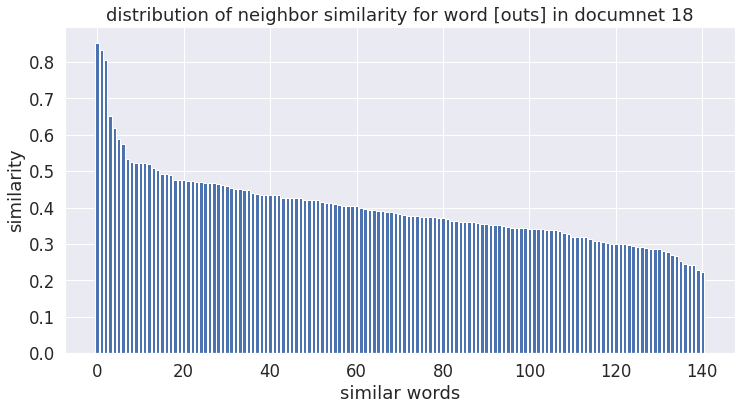

4   -->  ##trip
1738
[0.81238693, 0.80676806, 0.7480382, 0.6013414, 0.5558922, 0.5551057, 0.538175, 0.52643234, 0.5081682, 0.50271016, 0.49164647, 0.489686, 0.48576063, 0.4850732, 0.47722393, 0.4768702, 0.47673225, 0.47238344, 0.4682696, 0.46706527, 0.4669786, 0.46657023, 0.463121, 0.46038783, 0.4544543, 0.45027336, 0.44966307, 0.44591078, 0.44570145, 0.443435, 0.44336498, 0.4430774, 0.44170812, 0.4333415, 0.43135357, 0.43134773, 0.43030378, 0.42951858, 0.4278708, 0.42737886, 0.42732716, 0.42607647, 0.42188022, 0.41717768, 0.41681772, 0.41484466, 0.41204914, 0.41123343, 0.40847, 0.40835258, 0.40798777, 0.40104783, 0.39776665, 0.39624274, 0.39457852, 0.39377815, 0.38957205, 0.38911062, 0.38151374, 0.37925774, 0.37887546, 0.37683856, 0.37655866, 0.37460065, 0.37334806, 0.36908337, 0.36893222, 0.36850873, 0.36584163, 0.36532646, 0.3648709, 0.36333826, 0.3609575, 0.36003157, 0.3591807, 0.3587066, 0.35829708, 0.35177597, 0.35089555, 0.3503015, 0.34944552, 0.34916756, 0.34747124, 0.34686142,

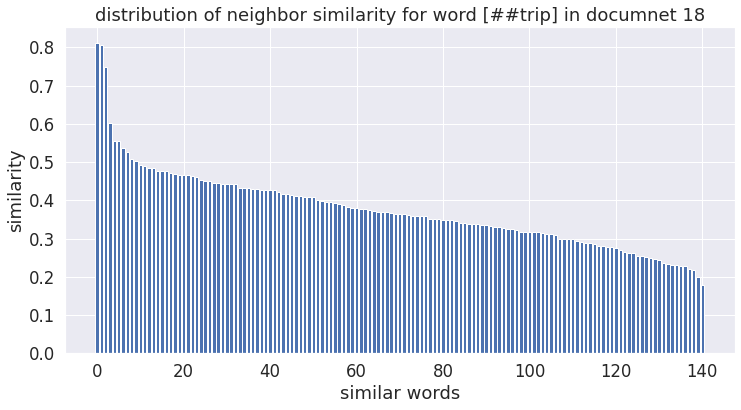

5   -->  ##ping
1738
[0.85322857, 0.81238693, 0.75917614, 0.6467458, 0.5646926, 0.52631944, 0.50634646, 0.50554675, 0.50095063, 0.49829185, 0.487495, 0.48557034, 0.48369092, 0.48277426, 0.482526, 0.4794656, 0.47714245, 0.47433674, 0.47173107, 0.47143447, 0.46788865, 0.4620754, 0.46194234, 0.4601075, 0.45933032, 0.45837772, 0.45719296, 0.45614868, 0.4551267, 0.45402685, 0.45366347, 0.45174962, 0.45156395, 0.44922188, 0.4489991, 0.4486773, 0.44860142, 0.44808426, 0.44410005, 0.442567, 0.44043058, 0.43223995, 0.4310115, 0.427156, 0.42602187, 0.4245964, 0.4232884, 0.42243743, 0.42192066, 0.42185563, 0.42059267, 0.42046264, 0.4181707, 0.4165045, 0.41480562, 0.41292426, 0.41092008, 0.40872294, 0.40654743, 0.40559998, 0.40533388, 0.40394735, 0.40196845, 0.40161932, 0.39860672, 0.39732057, 0.3951369, 0.39405107, 0.39400876, 0.3910521, 0.38870567, 0.38787055, 0.38690245, 0.38676754, 0.38554406, 0.3840881, 0.3819656, 0.3806197, 0.38008216, 0.37757808, 0.37550586, 0.37509462, 0.37155116, 0.370984

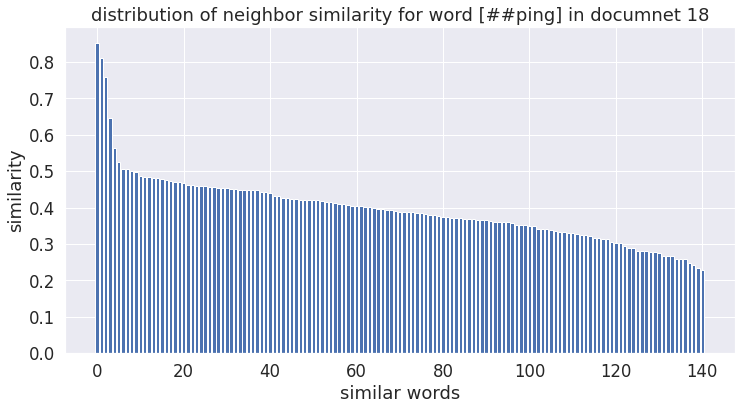

6   -->  capacity
1738
[0.7862396, 0.75865555, 0.7353723, 0.7254377, 0.6195762, 0.56189775, 0.5611138, 0.5537258, 0.5507867, 0.5488153, 0.5417255, 0.5251249, 0.5160541, 0.5078968, 0.49520326, 0.493532, 0.48839632, 0.47533023, 0.47379, 0.47251272, 0.46468246, 0.46238193, 0.46172142, 0.4596227, 0.4593984, 0.45688164, 0.4567845, 0.4545415, 0.4529438, 0.45122108, 0.448935, 0.44547617, 0.44383454, 0.4407661, 0.44045305, 0.43762693, 0.43615776, 0.43426913, 0.43277478, 0.43130487, 0.4311056, 0.42944407, 0.42932937, 0.42790028, 0.4276534, 0.42515713, 0.42479616, 0.42348868, 0.42345417, 0.42335522, 0.4222211, 0.42133814, 0.42111126, 0.4181215, 0.41611224, 0.41579843, 0.41364342, 0.41346902, 0.41251522, 0.41238812, 0.41105002, 0.41055262, 0.4094059, 0.40812582, 0.40479776, 0.4037739, 0.40295577, 0.40153956, 0.4003144, 0.39888918, 0.39680016, 0.3966239, 0.39157432, 0.3904721, 0.38978863, 0.3887993, 0.3840414, 0.383555, 0.3829369, 0.38174564, 0.37823105, 0.3767009, 0.37617785, 0.37519997, 0.369593

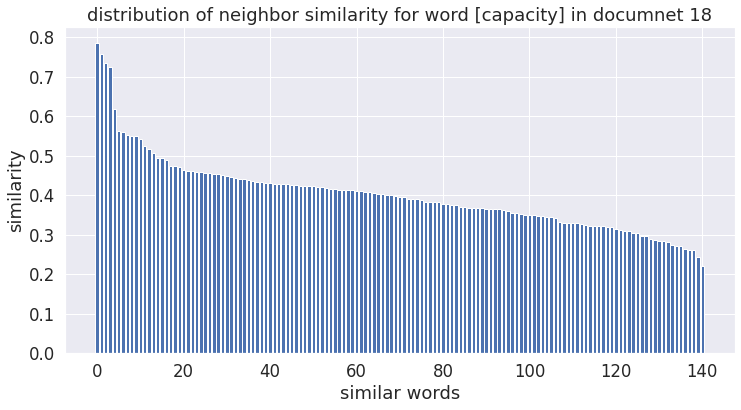

8   -->  freight
1738
[0.761503, 0.72150284, 0.67554784, 0.6736735, 0.6617382, 0.65224063, 0.6467458, 0.6013414, 0.586712, 0.5658066, 0.5548132, 0.55092835, 0.5276439, 0.52454036, 0.52427936, 0.5231106, 0.5060122, 0.5059557, 0.5024409, 0.5020679, 0.50181586, 0.49789575, 0.4941213, 0.49399787, 0.4904369, 0.4866606, 0.4860613, 0.48585972, 0.4856173, 0.48151803, 0.47467497, 0.4740289, 0.47046077, 0.4686587, 0.46648404, 0.4654708, 0.46465546, 0.46225888, 0.46215084, 0.4620365, 0.46164304, 0.4600346, 0.45879218, 0.45778364, 0.45516366, 0.45473313, 0.4540555, 0.45299724, 0.44403708, 0.44327873, 0.44107866, 0.44079146, 0.43833843, 0.4377961, 0.43730366, 0.4364557, 0.4347024, 0.4337207, 0.43315774, 0.4324951, 0.43173462, 0.43140998, 0.4305685, 0.42485768, 0.42441154, 0.42294267, 0.42184505, 0.42039585, 0.41921946, 0.41893315, 0.41842845, 0.4150067, 0.41463968, 0.41390494, 0.41350704, 0.4123879, 0.41235614, 0.41182336, 0.4116969, 0.4098596, 0.40459734, 0.40194583, 0.40084174, 0.4000456, 0.39918

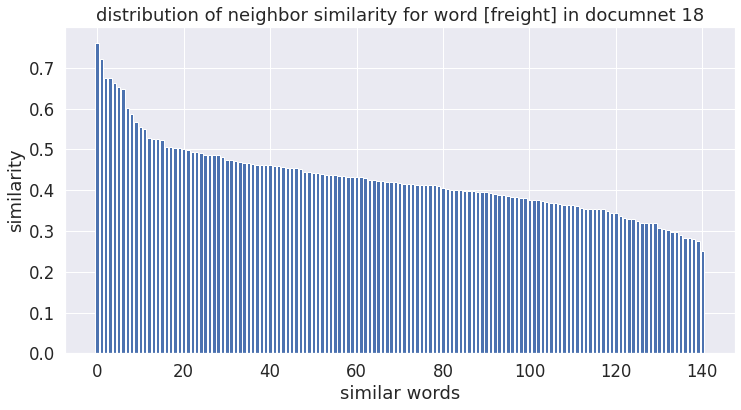

9   -->  rates
1738
[0.7289283, 0.6699165, 0.6484459, 0.64175713, 0.6184441, 0.61205775, 0.5801986, 0.56696534, 0.55019367, 0.5224917, 0.5224355, 0.51662695, 0.5162774, 0.516106, 0.50476205, 0.48221648, 0.48144048, 0.47612798, 0.47309482, 0.47179854, 0.47011134, 0.46955854, 0.46904147, 0.4689337, 0.46879193, 0.4664148, 0.46462095, 0.45835504, 0.45704043, 0.4564619, 0.45594156, 0.45274004, 0.4518999, 0.44684687, 0.43600893, 0.435246, 0.4346311, 0.4332979, 0.43182603, 0.4287424, 0.42681718, 0.4265474, 0.42525417, 0.4235881, 0.42133006, 0.4198648, 0.4196024, 0.4166954, 0.41583806, 0.4150557, 0.41440955, 0.4132065, 0.4117972, 0.41163534, 0.40975028, 0.40777105, 0.40465927, 0.4044943, 0.40345523, 0.4030246, 0.4026727, 0.40210712, 0.39478382, 0.39364892, 0.3929643, 0.38965303, 0.3880933, 0.38790703, 0.38314545, 0.3815682, 0.3788551, 0.37737155, 0.37720904, 0.37717122, 0.3756842, 0.37423134, 0.3741796, 0.37242457, 0.37025726, 0.3699504, 0.36826771, 0.36779568, 0.36653286, 0.36542892, 0.365324

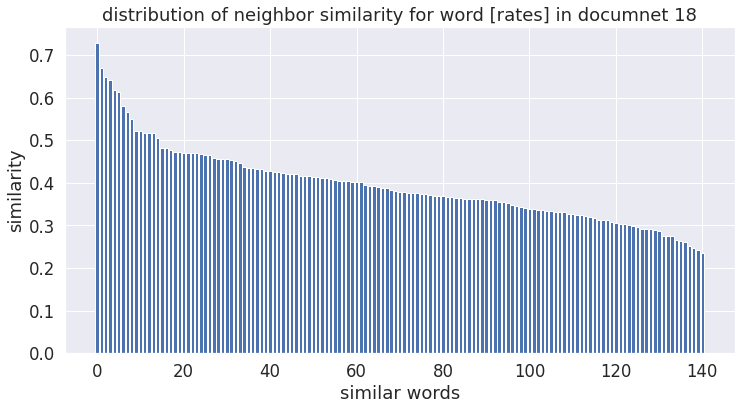

10   -->  rising
1738
[0.71256757, 0.70890546, 0.7003238, 0.68116736, 0.608145, 0.5926864, 0.5591026, 0.5576544, 0.53978866, 0.53798234, 0.53138345, 0.52929807, 0.5281879, 0.5249325, 0.5134347, 0.50573874, 0.49189514, 0.49167252, 0.47121757, 0.46997187, 0.46875507, 0.46634242, 0.46541297, 0.4641981, 0.46395805, 0.45829916, 0.45595038, 0.4557634, 0.451623, 0.4491912, 0.4475744, 0.4459812, 0.44588608, 0.44479164, 0.44355297, 0.43498546, 0.4340704, 0.43047696, 0.42981654, 0.42785326, 0.42757523, 0.42546076, 0.42271203, 0.4205568, 0.4196719, 0.41880217, 0.4167304, 0.41663927, 0.4148028, 0.4136495, 0.4129853, 0.40977713, 0.406362, 0.40510127, 0.40134794, 0.39917755, 0.39819428, 0.39664307, 0.39451313, 0.39416543, 0.39405677, 0.3930468, 0.3928166, 0.3901361, 0.38513407, 0.38301975, 0.38291955, 0.37796357, 0.37735897, 0.37729824, 0.3743473, 0.37420675, 0.37221932, 0.37213847, 0.3721025, 0.37052777, 0.37040776, 0.3698101, 0.36930814, 0.36850402, 0.36775273, 0.3644747, 0.36275142, 0.36240965, 0

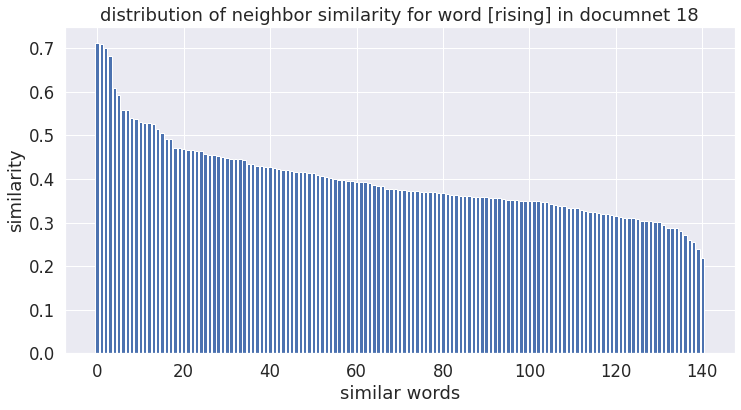

13   -->  new
1738
[0.67824036, 0.6246046, 0.5837639, 0.5412998, 0.52040887, 0.5114949, 0.5113566, 0.50299037, 0.49985275, 0.49111184, 0.47390875, 0.46489772, 0.43322444, 0.42627674, 0.41495752, 0.40985405, 0.40809667, 0.4062003, 0.40492952, 0.40291008, 0.4026562, 0.40024602, 0.382044, 0.3753998, 0.37408787, 0.37398666, 0.3720097, 0.37170827, 0.3674158, 0.36248028, 0.35994753, 0.35854304, 0.3549291, 0.3543513, 0.35358864, 0.34928542, 0.34802812, 0.34731692, 0.3449208, 0.3435384, 0.34323847, 0.34271032, 0.34033003, 0.34025952, 0.33876088, 0.33554196, 0.3342854, 0.332141, 0.330022, 0.3296584, 0.3273036, 0.32690302, 0.3261313, 0.32586896, 0.3249781, 0.324175, 0.32320637, 0.32295203, 0.31992215, 0.31832275, 0.31643814, 0.31602412, 0.31529632, 0.31493315, 0.3073603, 0.30734906, 0.30477977, 0.30434555, 0.3039592, 0.30393058, 0.30353302, 0.30304483, 0.30220324, 0.30122757, 0.3010802, 0.30018488, 0.29874328, 0.29813522, 0.29761684, 0.2972862, 0.2963485, 0.29536986, 0.2951296, 0.29449505, 0.293

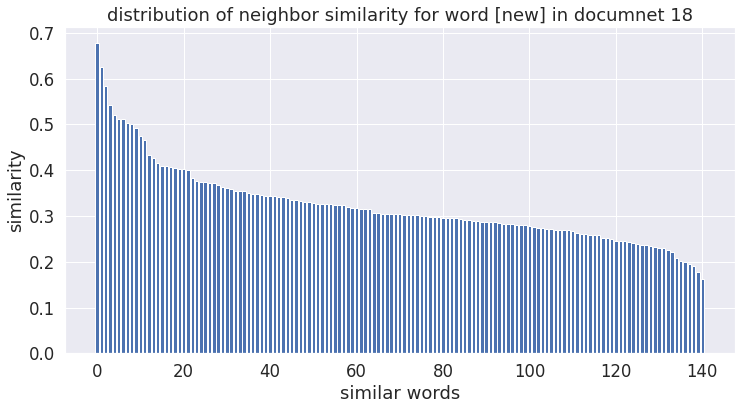

14   -->  year
1738
[0.68904924, 0.6242305, 0.5592667, 0.5390954, 0.5348993, 0.53036165, 0.5047408, 0.43073004, 0.42485768, 0.4245964, 0.4212972, 0.4200006, 0.4061188, 0.38501087, 0.3841445, 0.3814911, 0.3783101, 0.3746388, 0.37320805, 0.37058118, 0.36664957, 0.36333826, 0.36202514, 0.36137247, 0.35339516, 0.3461575, 0.34608287, 0.34450808, 0.34443328, 0.34299523, 0.34285676, 0.34124988, 0.33196986, 0.32779264, 0.32630566, 0.31909934, 0.31693482, 0.31648308, 0.31369972, 0.30852443, 0.3029937, 0.30225325, 0.29982573, 0.2968227, 0.29505807, 0.29346985, 0.29340476, 0.29269838, 0.29090664, 0.28965786, 0.28817654, 0.28719392, 0.2857797, 0.28406337, 0.2828987, 0.28189167, 0.2802428, 0.27999458, 0.2789033, 0.27810773, 0.27808166, 0.27775812, 0.27711827, 0.276747, 0.27640882, 0.27600408, 0.2753335, 0.2750016, 0.2719186, 0.26972717, 0.26850817, 0.26796585, 0.26778674, 0.2676041, 0.2669748, 0.26379174, 0.2626441, 0.26167014, 0.25983512, 0.25890735, 0.25799423, 0.2576447, 0.25676832, 0.25282082, 

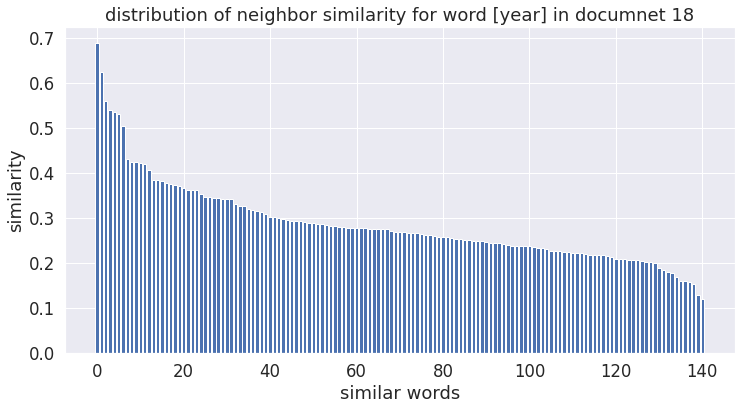

15   -->  might
1738
[0.8189509, 0.69981444, 0.5554071, 0.5390954, 0.5374031, 0.52254844, 0.5068172, 0.50095063, 0.49164647, 0.4740289, 0.46692383, 0.4540597, 0.45310944, 0.4453789, 0.4411911, 0.43675798, 0.43502784, 0.42019123, 0.41905206, 0.41692924, 0.4160583, 0.41515607, 0.40366414, 0.40206373, 0.3995272, 0.39880964, 0.3959005, 0.39082786, 0.3876242, 0.38532293, 0.37725452, 0.37594724, 0.36966503, 0.3638302, 0.36157402, 0.3615064, 0.36148062, 0.35134408, 0.34809357, 0.34748936, 0.34407017, 0.3434654, 0.34303463, 0.34186167, 0.34067282, 0.3399455, 0.3376401, 0.3371641, 0.33643377, 0.3313765, 0.33073118, 0.32972214, 0.32964462, 0.3273442, 0.326794, 0.32637146, 0.3259204, 0.3252547, 0.32485864, 0.32415253, 0.32313442, 0.3230046, 0.32251263, 0.3223771, 0.31843877, 0.3175397, 0.31671923, 0.31662315, 0.31658727, 0.31627494, 0.31608492, 0.3154868, 0.31376463, 0.31354558, 0.31241065, 0.31098074, 0.3101085, 0.30724996, 0.30653507, 0.30594963, 0.30548042, 0.30426407, 0.30151045, 0.30126533, 

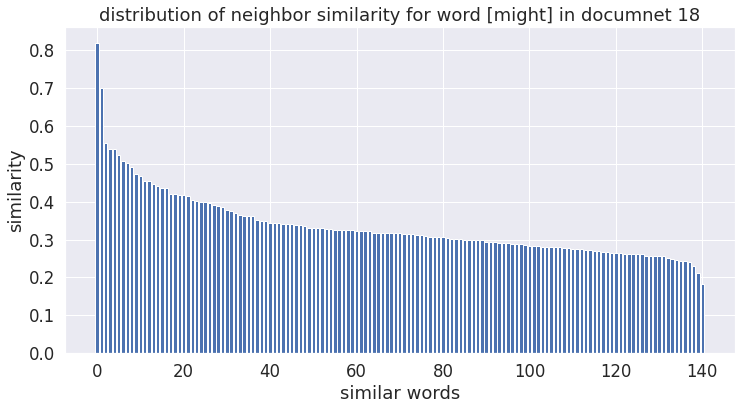

16   -->  seem
1738
[0.8189509, 0.8188937, 0.68904924, 0.58213586, 0.5755167, 0.57119095, 0.5130206, 0.50554675, 0.4909282, 0.4850732, 0.4848441, 0.4830067, 0.46465546, 0.46305573, 0.45351276, 0.45245713, 0.45046052, 0.44565704, 0.44037288, 0.42772236, 0.42242652, 0.39724988, 0.38686517, 0.38438696, 0.383786, 0.37799114, 0.37310883, 0.3638633, 0.36385816, 0.36383525, 0.36222744, 0.35681143, 0.3538621, 0.35342455, 0.35045666, 0.34621534, 0.34435385, 0.34350526, 0.3425483, 0.33965158, 0.33711734, 0.33637744, 0.3363584, 0.33399773, 0.3337705, 0.3320205, 0.33070028, 0.32482478, 0.32404786, 0.32401934, 0.32401347, 0.3220087, 0.32091197, 0.31950557, 0.318223, 0.31808466, 0.31799394, 0.31741405, 0.31650633, 0.31558445, 0.31556576, 0.3151871, 0.31277165, 0.31187204, 0.3116747, 0.3088834, 0.3085756, 0.30682448, 0.30641156, 0.29975986, 0.2991637, 0.2991622, 0.29905084, 0.29823154, 0.297399, 0.29409933, 0.2940286, 0.2937655, 0.2933542, 0.29319704, 0.29260218, 0.29022846, 0.2882484, 0.2881633, 0.2

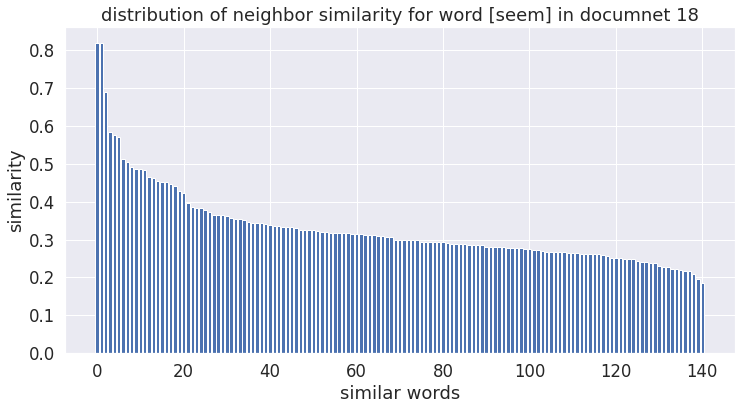

17   -->  ripe
1738
[0.8188937, 0.69981444, 0.6242305, 0.558728, 0.5533856, 0.5517971, 0.5500577, 0.546737, 0.5348519, 0.5318065, 0.52549076, 0.51993495, 0.51722896, 0.50271016, 0.4860613, 0.47173107, 0.45893186, 0.44822827, 0.4444222, 0.4440126, 0.4306472, 0.42666298, 0.4242236, 0.41250616, 0.40546694, 0.4044161, 0.39042693, 0.38843668, 0.38685325, 0.38564983, 0.3837662, 0.38290668, 0.38235173, 0.3812582, 0.37933105, 0.37744167, 0.3750316, 0.37500086, 0.3716767, 0.36942235, 0.36916, 0.36318904, 0.3606235, 0.35698873, 0.356439, 0.35189193, 0.35178676, 0.35166925, 0.34941193, 0.3457822, 0.34535074, 0.34521985, 0.3449579, 0.34034902, 0.3375884, 0.3374967, 0.3363066, 0.3342089, 0.3336068, 0.33360642, 0.33290902, 0.3326661, 0.3289447, 0.32772964, 0.32523745, 0.32455724, 0.32311416, 0.32250437, 0.32139406, 0.32035118, 0.31984952, 0.31921622, 0.31848896, 0.3171734, 0.31623164, 0.31341308, 0.3133487, 0.31249338, 0.3123434, 0.31191456, 0.31037816, 0.30917263, 0.3088215, 0.3078816, 0.3074792, 0

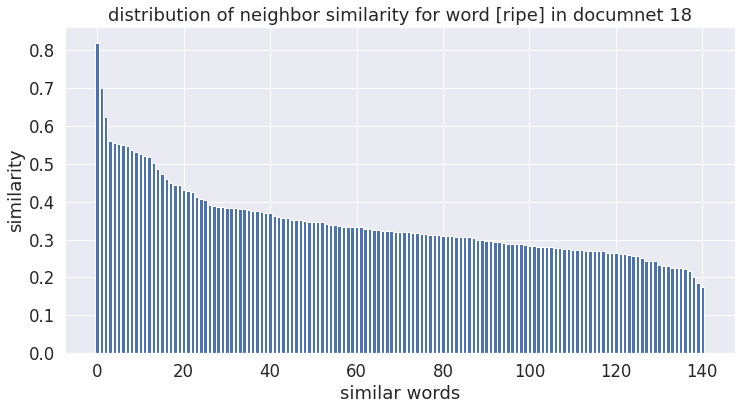

20   -->  flood
1738
[0.68025815, 0.62630856, 0.5783888, 0.55902064, 0.55865264, 0.5375786, 0.5360216, 0.5316448, 0.52614254, 0.52229136, 0.5219151, 0.5152253, 0.5105037, 0.4933598, 0.47400868, 0.47327054, 0.45854864, 0.4514013, 0.44665614, 0.438498, 0.4360137, 0.43574506, 0.43238315, 0.42744148, 0.4266835, 0.4238088, 0.41881335, 0.4182415, 0.41726607, 0.41664746, 0.41548002, 0.4145927, 0.4137801, 0.4126966, 0.41263932, 0.41004503, 0.40544665, 0.39951414, 0.39279413, 0.38941115, 0.38765925, 0.38765648, 0.38600245, 0.3856956, 0.38377792, 0.38184416, 0.38069224, 0.37887293, 0.37877908, 0.37549084, 0.3747137, 0.3721072, 0.37102032, 0.36947694, 0.36893636, 0.36566716, 0.36550307, 0.36447868, 0.36398703, 0.3627316, 0.3619467, 0.36182606, 0.3592347, 0.35740972, 0.35655308, 0.3561284, 0.35539237, 0.3551829, 0.35110766, 0.35093516, 0.34894523, 0.3481742, 0.34749013, 0.34594995, 0.3439842, 0.34330058, 0.3403383, 0.3398292, 0.33975285, 0.33963472, 0.33911926, 0.33514762, 0.3339237, 0.33178994, 0

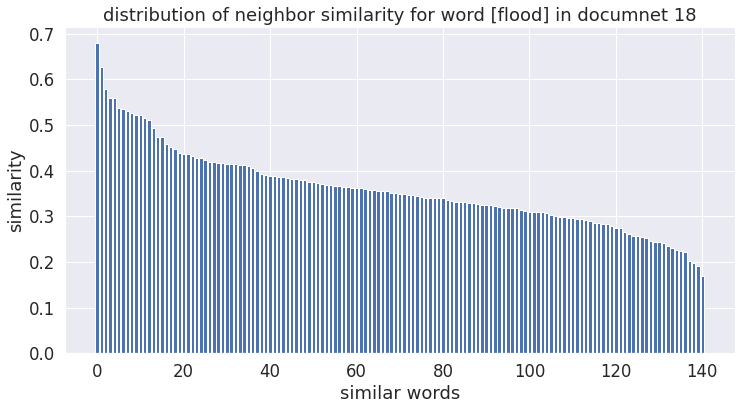

22   -->  orders
1738
[0.57562137, 0.57176685, 0.5658066, 0.558728, 0.5370464, 0.5361928, 0.5256072, 0.5131919, 0.5122928, 0.50576156, 0.50107396, 0.49003926, 0.48879585, 0.481843, 0.47420967, 0.47238344, 0.47214785, 0.46513045, 0.45822474, 0.45678744, 0.45633686, 0.45542964, 0.45535696, 0.45387405, 0.45245713, 0.4458498, 0.4418993, 0.4411911, 0.43746123, 0.43676746, 0.4358701, 0.4347505, 0.43347076, 0.43133217, 0.43051723, 0.4281148, 0.4271757, 0.42441258, 0.42380035, 0.42031503, 0.41923577, 0.4186234, 0.41848078, 0.4181707, 0.41678327, 0.41439056, 0.4135295, 0.41350916, 0.41260964, 0.40757412, 0.40757164, 0.40673453, 0.4041183, 0.40185478, 0.40084526, 0.39896297, 0.39808023, 0.39582992, 0.3946116, 0.39395303, 0.39260435, 0.39244834, 0.39218163, 0.3874642, 0.38741666, 0.38732582, 0.3862309, 0.38475913, 0.3835818, 0.38353038, 0.38263527, 0.382549, 0.38240826, 0.3810969, 0.3776488, 0.37713432, 0.37689924, 0.37633753, 0.37601835, 0.37312496, 0.37106323, 0.3697664, 0.36664957, 0.36628658,

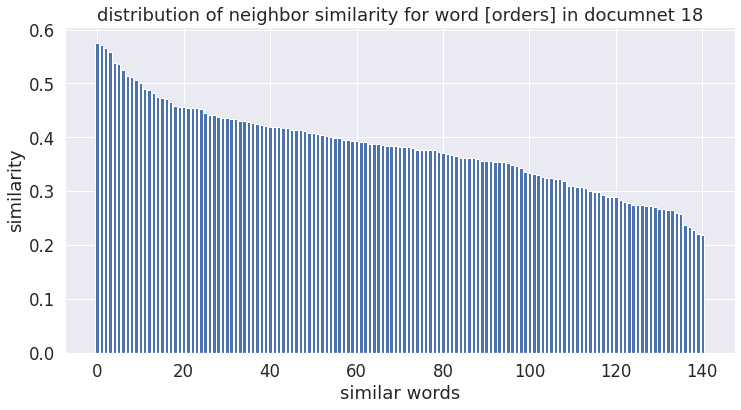

24   -->  new
1738
[0.65686774, 0.6055025, 0.595425, 0.58514357, 0.580289, 0.5725305, 0.5586783, 0.5579971, 0.54464614, 0.53484374, 0.52619004, 0.52602273, 0.52485406, 0.51683986, 0.51470447, 0.5113734, 0.50743765, 0.50661325, 0.50652146, 0.5008818, 0.49782538, 0.49738005, 0.49594012, 0.49497467, 0.49479508, 0.49478886, 0.49242944, 0.4922036, 0.48734897, 0.48642457, 0.4848703, 0.4847877, 0.4845703, 0.48077393, 0.48074406, 0.4781958, 0.47519684, 0.47261167, 0.47139758, 0.46625784, 0.4655701, 0.46501076, 0.46450752, 0.463695, 0.46195304, 0.4610051, 0.46049356, 0.45988083, 0.4588523, 0.4585601, 0.45658752, 0.45420784, 0.45420325, 0.45368934, 0.45164934, 0.45093197, 0.45034844, 0.4502259, 0.44951618, 0.4494775, 0.44885558, 0.44475988, 0.44466692, 0.4412651, 0.43985403, 0.43870157, 0.43706048, 0.43687552, 0.43672585, 0.43630117, 0.4346912, 0.43411508, 0.43382257, 0.4334432, 0.42215475, 0.42041034, 0.4167114, 0.41474515, 0.41459146, 0.41291708, 0.4121927, 0.40776378, 0.4072973, 0.40611264, 0

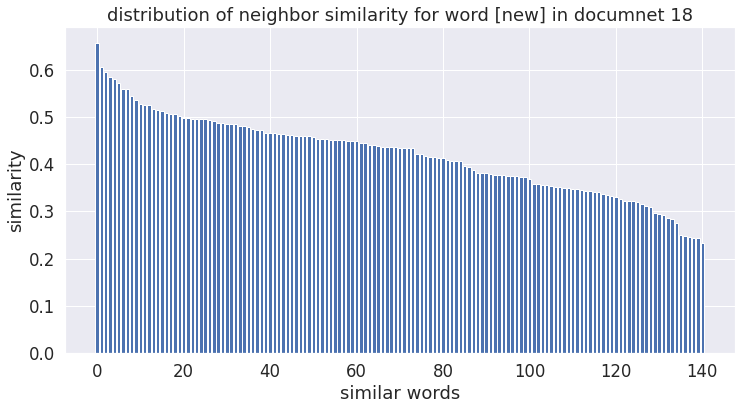

25   -->  bulk
1738
[0.72150284, 0.6838022, 0.6290566, 0.6243019, 0.6040873, 0.5891566, 0.57562137, 0.57127583, 0.5646926, 0.55804765, 0.5551057, 0.5549048, 0.5539354, 0.5511647, 0.55012834, 0.5458405, 0.54207337, 0.5417032, 0.53521425, 0.5308727, 0.52668095, 0.52191937, 0.5127243, 0.51052314, 0.5092378, 0.5033604, 0.49815667, 0.4974561, 0.49646232, 0.49644053, 0.4953085, 0.4949843, 0.49306142, 0.49262118, 0.49087837, 0.48877108, 0.4847312, 0.48312545, 0.48169726, 0.48148802, 0.48098788, 0.47214258, 0.47213146, 0.47120705, 0.46969333, 0.46223795, 0.4616763, 0.460568, 0.4598285, 0.45835575, 0.4582236, 0.45728078, 0.45656508, 0.4511035, 0.45051, 0.44616768, 0.4449761, 0.4422849, 0.43697724, 0.4340241, 0.42989433, 0.42694533, 0.42247504, 0.4184494, 0.4159737, 0.41297087, 0.41207808, 0.41119546, 0.41028696, 0.40827665, 0.40632534, 0.40554166, 0.40537226, 0.4046318, 0.40321815, 0.4023866, 0.40217, 0.400948, 0.40090132, 0.39988744, 0.39196777, 0.3919183, 0.3917721, 0.39082786, 0.39037755, 0.

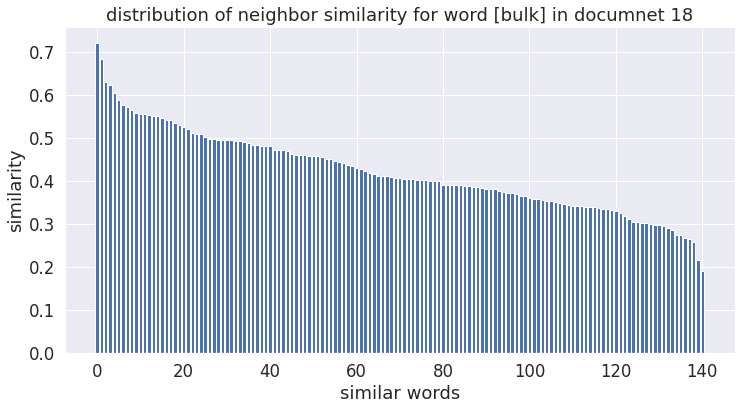

27   -->  cargo
1738
[0.76833963, 0.6928457, 0.6837211, 0.68028784, 0.60327834, 0.6017363, 0.54828197, 0.5441876, 0.5411161, 0.53026026, 0.5241464, 0.52099574, 0.5208326, 0.5192702, 0.5162993, 0.49798006, 0.49751145, 0.49120238, 0.48942542, 0.4873152, 0.48472068, 0.48441583, 0.48126882, 0.47751886, 0.46561736, 0.4651584, 0.46092546, 0.45463932, 0.45441008, 0.45393634, 0.45035106, 0.44736487, 0.44592798, 0.44550803, 0.44484743, 0.44273102, 0.4421306, 0.43955976, 0.43953782, 0.42760727, 0.42584848, 0.42379415, 0.42305064, 0.42015624, 0.41888672, 0.41858506, 0.41828874, 0.41438752, 0.41271165, 0.41233435, 0.41124058, 0.40923727, 0.4072166, 0.40250546, 0.3993622, 0.3975097, 0.39728796, 0.39597204, 0.39545697, 0.394373, 0.3938017, 0.39377263, 0.39305606, 0.3923292, 0.39106908, 0.39008957, 0.3888291, 0.38485387, 0.3848049, 0.38035968, 0.37958962, 0.3788027, 0.37677458, 0.37493408, 0.3744207, 0.37335062, 0.36995757, 0.36817646, 0.3642742, 0.36369312, 0.36356026, 0.3633504, 0.36320224, 0.36312

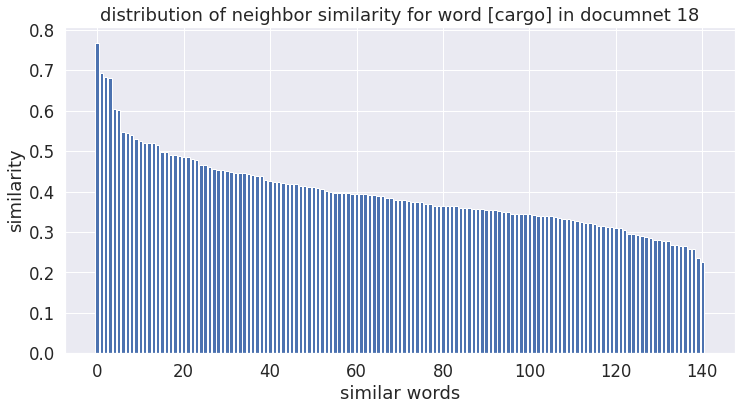

28   -->  ships
1738
[0.670734, 0.6491419, 0.59777135, 0.5908251, 0.5705236, 0.5674999, 0.56645596, 0.5586877, 0.5496174, 0.54841816, 0.5409538, 0.54043674, 0.53563607, 0.5291107, 0.527436, 0.52481943, 0.5044721, 0.5021136, 0.49033636, 0.4869721, 0.48613393, 0.48328418, 0.48038262, 0.4798382, 0.478858, 0.47651592, 0.473949, 0.47376713, 0.4737044, 0.470914, 0.4689851, 0.46757844, 0.46394575, 0.46244842, 0.46130815, 0.46052814, 0.45831478, 0.45768726, 0.45438284, 0.4529336, 0.45244536, 0.45103133, 0.45078918, 0.45075712, 0.44911596, 0.44799662, 0.44346833, 0.44170895, 0.4410727, 0.43933713, 0.4389584, 0.43863827, 0.43782753, 0.43773335, 0.43736857, 0.43712956, 0.43545875, 0.43302912, 0.43211102, 0.43186677, 0.430755, 0.4306188, 0.4292004, 0.42571864, 0.4249497, 0.4226948, 0.42244947, 0.42154458, 0.4197184, 0.41837507, 0.4148994, 0.41394246, 0.41297898, 0.40617564, 0.4044613, 0.40408477, 0.40373287, 0.40369394, 0.40366873, 0.40284872, 0.4022223, 0.40195054, 0.4011765, 0.39847708, 0.398379

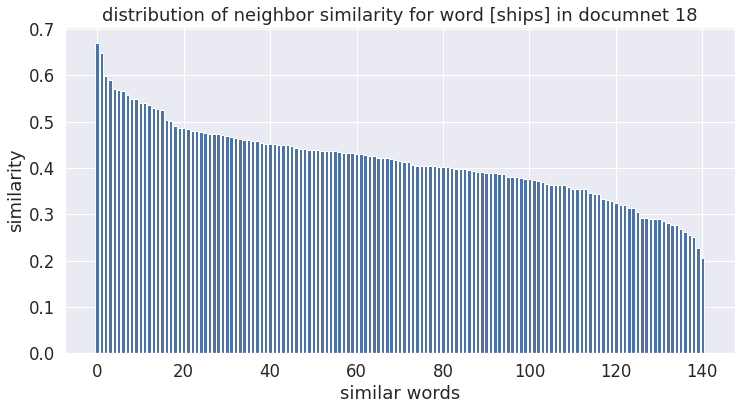

31   -->  flood
1738
[0.69591933, 0.6677638, 0.6198505, 0.61657405, 0.57119095, 0.5558922, 0.5517971, 0.55092835, 0.5374031, 0.5370464, 0.5348993, 0.52631944, 0.51330596, 0.5092378, 0.49951065, 0.4782849, 0.47486538, 0.47031808, 0.46897155, 0.46452063, 0.46041015, 0.4597869, 0.4586516, 0.45756704, 0.45344317, 0.44821683, 0.4466151, 0.4395234, 0.43772805, 0.43624014, 0.43471417, 0.43248522, 0.43211102, 0.4318571, 0.42507666, 0.42501652, 0.42404896, 0.42236543, 0.41987434, 0.4080817, 0.40441447, 0.4039845, 0.40394077, 0.39853075, 0.39758503, 0.39597732, 0.39456424, 0.3925829, 0.3922459, 0.39039275, 0.3846866, 0.38124007, 0.38099173, 0.38021952, 0.3799889, 0.37993884, 0.37689215, 0.37472117, 0.37424347, 0.37338927, 0.3721379, 0.36907187, 0.368434, 0.3671942, 0.3670212, 0.36646378, 0.36613622, 0.36562854, 0.36479706, 0.36420524, 0.35721987, 0.35518765, 0.35320413, 0.35192615, 0.35190356, 0.3514309, 0.35088992, 0.35048297, 0.34867653, 0.34771147, 0.34555095, 0.34501278, 0.3437714, 0.3430401

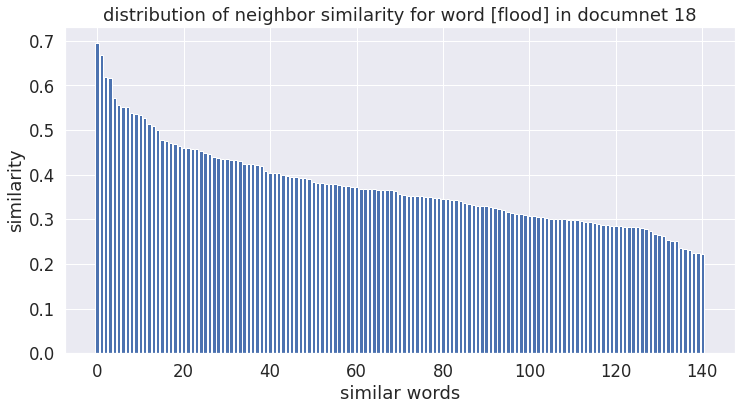

32   -->  reminiscent
1738
[0.78236353, 0.61657405, 0.6057308, 0.58802015, 0.58573925, 0.5704087, 0.5441412, 0.51722896, 0.4830067, 0.4826318, 0.47374582, 0.47204947, 0.4695652, 0.46692383, 0.4602845, 0.4556982, 0.45542964, 0.45186615, 0.44966307, 0.44426963, 0.43931535, 0.43352365, 0.43309176, 0.41368318, 0.4126942, 0.40845528, 0.40653956, 0.40206754, 0.40023035, 0.39860043, 0.39732057, 0.3933568, 0.39237148, 0.39196777, 0.3904541, 0.3880635, 0.38798144, 0.386761, 0.38469878, 0.3827682, 0.37701046, 0.37171936, 0.37150455, 0.36981148, 0.36790007, 0.36697036, 0.36693197, 0.36240703, 0.3620934, 0.35941225, 0.3585653, 0.35840145, 0.35762447, 0.35707727, 0.35702217, 0.35612828, 0.35580516, 0.35168427, 0.3510636, 0.3509576, 0.34896395, 0.34895563, 0.3489353, 0.3473089, 0.3459809, 0.34586418, 0.34489068, 0.3441727, 0.34299523, 0.34180093, 0.34077895, 0.33758175, 0.3347652, 0.33369893, 0.33365512, 0.33272812, 0.33154395, 0.3311891, 0.33118135, 0.3311334, 0.33041635, 0.33018038, 0.32837713, 0.

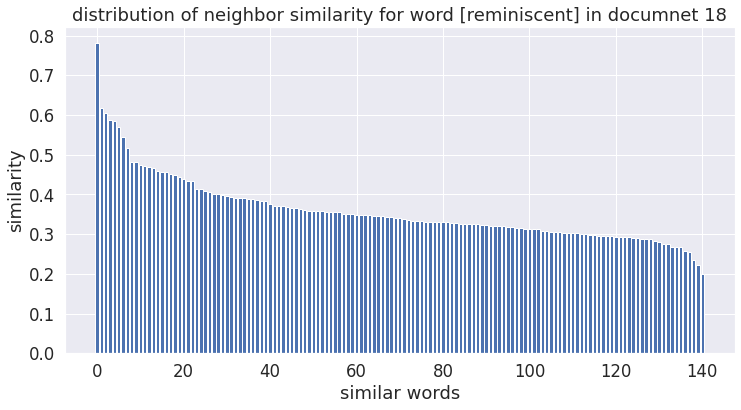

37   -->  early
1738
[0.8159839, 0.7897302, 0.65804565, 0.64951205, 0.59885216, 0.5580561, 0.55167276, 0.5423832, 0.54181945, 0.5338089, 0.5234889, 0.5038175, 0.503376, 0.4907632, 0.48499388, 0.48053437, 0.47740525, 0.47215977, 0.4597127, 0.45945287, 0.4587419, 0.45813626, 0.45353323, 0.45335072, 0.44989187, 0.44940478, 0.44339404, 0.4424938, 0.44113213, 0.4330039, 0.4316287, 0.43113375, 0.4311278, 0.42950964, 0.42553958, 0.4238941, 0.42206824, 0.42185587, 0.42148638, 0.41795918, 0.41625854, 0.41599447, 0.41142985, 0.40706018, 0.40470922, 0.40377054, 0.40188986, 0.40144932, 0.4012278, 0.40097722, 0.40041882, 0.399853, 0.3992398, 0.39610523, 0.39432245, 0.39297485, 0.39262268, 0.39227086, 0.39204946, 0.39113116, 0.39051595, 0.38970193, 0.38913614, 0.38900763, 0.38785705, 0.38540038, 0.3849268, 0.38482508, 0.38467628, 0.3843931, 0.38248432, 0.381716, 0.3806449, 0.37713367, 0.3732908, 0.37242103, 0.3701436, 0.36915094, 0.3685521, 0.36728317, 0.3649062, 0.36457723, 0.36434776, 0.3640185, 0

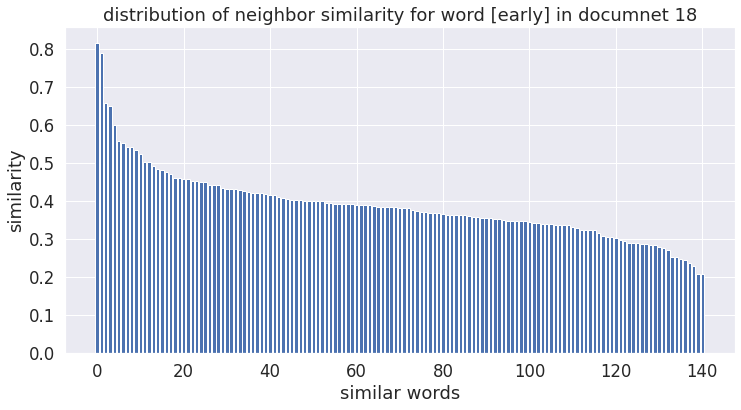

38   -->  1970
1738
[0.9197298, 0.76251686, 0.6057308, 0.568782, 0.53854656, 0.538175, 0.5348519, 0.519903, 0.50576156, 0.5031554, 0.49556565, 0.4953085, 0.47486538, 0.4654708, 0.4620754, 0.4505614, 0.44565704, 0.44049793, 0.43210083, 0.42975897, 0.42785695, 0.42547426, 0.41808555, 0.416474, 0.4160583, 0.4033242, 0.40257603, 0.40237033, 0.39894146, 0.398907, 0.3987257, 0.39716083, 0.39708945, 0.39303637, 0.39234304, 0.38799113, 0.385696, 0.38190114, 0.38160616, 0.38125622, 0.3812176, 0.37973642, 0.3783555, 0.37585878, 0.3730049, 0.37153846, 0.36970466, 0.36771083, 0.3673113, 0.3669753, 0.3645541, 0.36390692, 0.36202514, 0.36160153, 0.3602628, 0.356468, 0.3556509, 0.35529876, 0.35510087, 0.3530873, 0.35214156, 0.3512723, 0.35053608, 0.35031405, 0.3479892, 0.3456936, 0.34418607, 0.34389967, 0.34375677, 0.34357134, 0.34102544, 0.33963335, 0.33884972, 0.3370279, 0.33664244, 0.33435678, 0.3333706, 0.33028373, 0.3300693, 0.32654163, 0.3253835, 0.3251958, 0.32315734, 0.32249063, 0.3209344, 0.

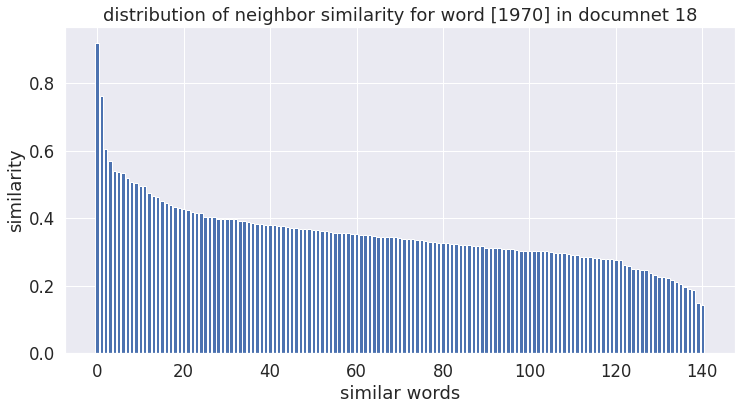

43   -->  early
1738
[0.80658495, 0.76251686, 0.62439597, 0.5704087, 0.5511647, 0.5500577, 0.5361928, 0.5336676, 0.5322765, 0.52643234, 0.5176713, 0.50995386, 0.4856173, 0.48386204, 0.4832058, 0.482526, 0.4747986, 0.4696291, 0.46768358, 0.46517867, 0.46102798, 0.46049523, 0.45756704, 0.4540597, 0.45351276, 0.4495188, 0.44502044, 0.44469306, 0.4442463, 0.43963522, 0.43721616, 0.43417862, 0.43411463, 0.43109566, 0.43084013, 0.42760825, 0.42421225, 0.42391962, 0.42376575, 0.42276993, 0.419141, 0.4158898, 0.413996, 0.41302294, 0.41216838, 0.4108866, 0.41068688, 0.41000065, 0.4094928, 0.4085524, 0.4076512, 0.40353602, 0.4011833, 0.4003187, 0.39910728, 0.39908725, 0.3989446, 0.3984975, 0.3984658, 0.3978364, 0.39200443, 0.3915058, 0.39067435, 0.38974774, 0.38670236, 0.3859291, 0.38560864, 0.38545668, 0.3852257, 0.38212785, 0.38146806, 0.3783101, 0.37814793, 0.37698063, 0.3765172, 0.3763986, 0.3755091, 0.3752548, 0.37404066, 0.37221423, 0.37177253, 0.37162477, 0.3696621, 0.36890933, 0.36884755

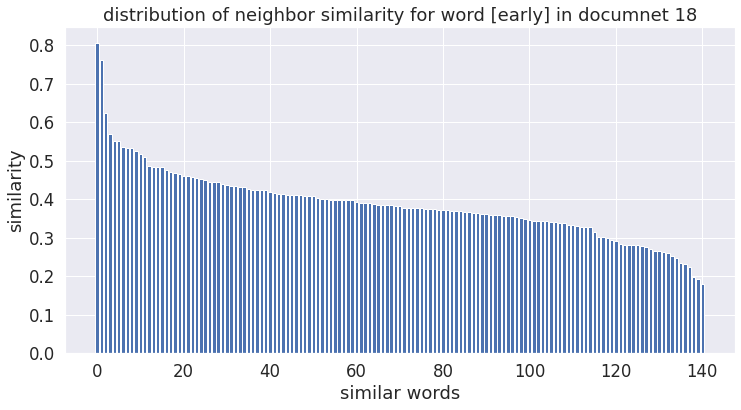

44   -->  1980
1738
[0.9197298, 0.80658495, 0.61511695, 0.58802015, 0.5318065, 0.51545906, 0.5081682, 0.50559354, 0.50107396, 0.49306142, 0.4911016, 0.47589025, 0.46897155, 0.45879218, 0.4530084, 0.45265517, 0.4466076, 0.43623984, 0.43503585, 0.42772236, 0.4212231, 0.4210122, 0.42059267, 0.42055714, 0.42019123, 0.41879028, 0.41476655, 0.41113776, 0.41010123, 0.4056357, 0.40477568, 0.40214473, 0.4019373, 0.40132707, 0.39532357, 0.39310175, 0.39154145, 0.39088202, 0.38954756, 0.38906622, 0.38420215, 0.3840397, 0.37961578, 0.3790964, 0.37903112, 0.3786763, 0.3734826, 0.37219054, 0.36997426, 0.36957198, 0.3687934, 0.36666328, 0.36661023, 0.36626995, 0.36253715, 0.36142975, 0.35931966, 0.35881758, 0.35836202, 0.35816395, 0.35804603, 0.35730475, 0.35718066, 0.35669833, 0.35359734, 0.3533408, 0.35268915, 0.35152596, 0.34917617, 0.34795606, 0.3446997, 0.34450808, 0.34081697, 0.3407899, 0.34019622, 0.33791625, 0.33741868, 0.33670008, 0.33586198, 0.3357619, 0.33574492, 0.33515957, 0.3335284, 0.3

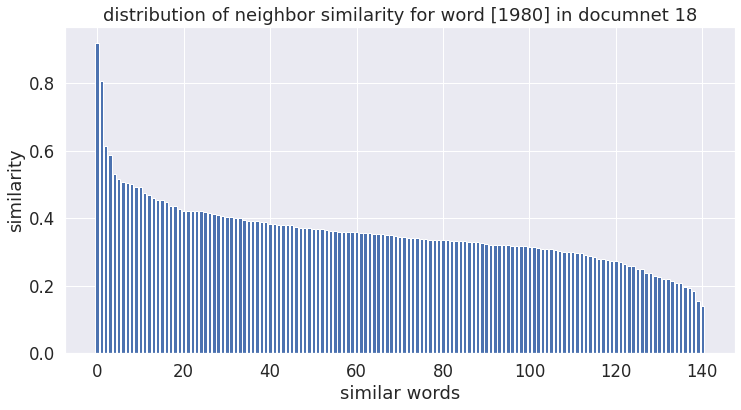

54   -->  case
1738
[0.751886, 0.61931854, 0.6156775, 0.5873772, 0.58573925, 0.5761529, 0.57583964, 0.5706855, 0.546737, 0.5234589, 0.51545906, 0.51330596, 0.5103431, 0.50995386, 0.5038487, 0.50336933, 0.5031554, 0.4913866, 0.49099925, 0.4848441, 0.47662225, 0.47420967, 0.47113732, 0.46844506, 0.46646664, 0.46194234, 0.45989847, 0.45340073, 0.45310944, 0.45220426, 0.45027336, 0.44403708, 0.44220102, 0.44113916, 0.44083744, 0.4385911, 0.43797025, 0.42779398, 0.42594165, 0.42247504, 0.41936216, 0.41179383, 0.41097248, 0.40937483, 0.4086266, 0.40762815, 0.4074973, 0.40516073, 0.40483427, 0.40061903, 0.39914334, 0.3988011, 0.39566672, 0.39426255, 0.39353895, 0.39216653, 0.39166936, 0.390903, 0.3901896, 0.39012825, 0.38949502, 0.38770318, 0.38570875, 0.3833001, 0.38199842, 0.38117564, 0.3810975, 0.37710154, 0.37708664, 0.37687546, 0.37666023, 0.37632412, 0.37617767, 0.3759296, 0.37564665, 0.3741827, 0.37286332, 0.37025875, 0.3699202, 0.3673651, 0.36695558, 0.36530572, 0.36456555, 0.36378768

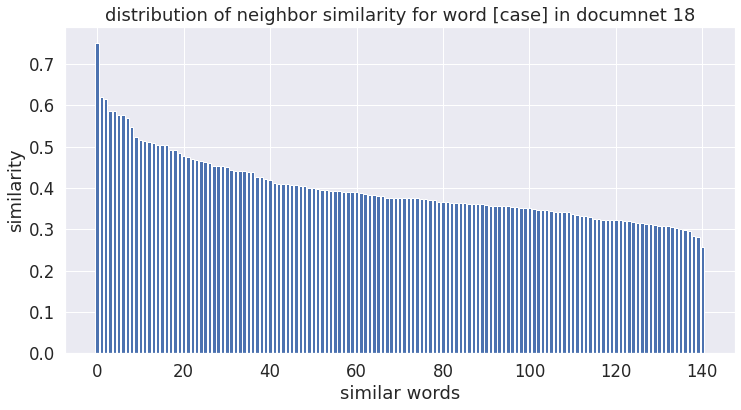

56   -->  time
1738
[0.729939, 0.6156775, 0.6074682, 0.5586605, 0.5579909, 0.5579135, 0.50596714, 0.49729705, 0.4926228, 0.48727256, 0.4845324, 0.48290253, 0.47118974, 0.46955734, 0.46683967, 0.455858, 0.45344317, 0.44037288, 0.43931535, 0.4275973, 0.41745102, 0.41692924, 0.4129937, 0.41109985, 0.4096099, 0.40851113, 0.40720898, 0.40715936, 0.4059493, 0.40546694, 0.40377218, 0.40064222, 0.39861476, 0.39655918, 0.39608404, 0.39569783, 0.39271146, 0.39244834, 0.38833672, 0.38815787, 0.38501087, 0.37948138, 0.37920782, 0.37731743, 0.3772907, 0.3767069, 0.37202758, 0.37088776, 0.37070814, 0.37022856, 0.37009293, 0.36828148, 0.36280912, 0.3585412, 0.35821074, 0.35694826, 0.35641912, 0.35396922, 0.3539454, 0.34939283, 0.3440364, 0.34333193, 0.34145704, 0.3404065, 0.3400016, 0.3396138, 0.3394404, 0.33925796, 0.33829615, 0.3365949, 0.3364749, 0.33507305, 0.3332258, 0.33188504, 0.3318302, 0.33028373, 0.32930762, 0.3292009, 0.3271016, 0.32708693, 0.32667133, 0.32437533, 0.32213148, 0.3215893, 0.

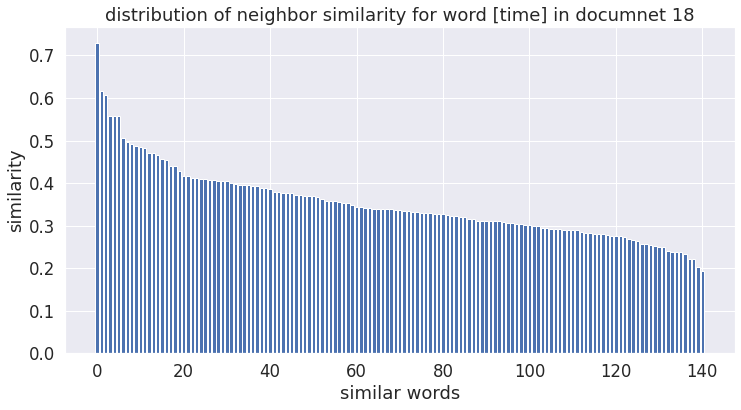

58   -->  many
1738
[0.8145518, 0.7670341, 0.756881, 0.6864073, 0.65923095, 0.62221396, 0.5726779, 0.57128084, 0.5438993, 0.5385686, 0.5358535, 0.5076566, 0.506021, 0.5038947, 0.49253976, 0.47612312, 0.4577845, 0.4575735, 0.45109844, 0.45006388, 0.4439276, 0.4428327, 0.44125152, 0.43634453, 0.43554962, 0.43376303, 0.42925832, 0.42716354, 0.42646658, 0.4244942, 0.42262307, 0.42072493, 0.41997465, 0.41955513, 0.4176741, 0.41621202, 0.41468152, 0.4136162, 0.4130624, 0.4120042, 0.40979648, 0.4084428, 0.4072687, 0.4066959, 0.406425, 0.40640634, 0.4053884, 0.40399492, 0.40151042, 0.39949533, 0.3956678, 0.39218313, 0.39202327, 0.39164644, 0.39124689, 0.38847345, 0.3833809, 0.38261765, 0.38194448, 0.37985134, 0.3782649, 0.3770099, 0.37676474, 0.37636524, 0.37275833, 0.37204772, 0.37169674, 0.37112296, 0.36968708, 0.36893788, 0.36892635, 0.3675301, 0.36678606, 0.36584502, 0.3654083, 0.36502165, 0.36447042, 0.36392066, 0.3624103, 0.36175478, 0.36057305, 0.35923618, 0.35793912, 0.35785007, 0.3562

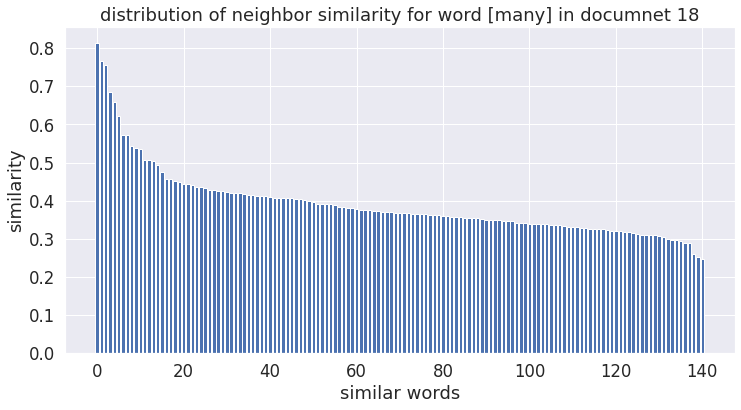

59   -->  people
1738
[0.8343948, 0.8169067, 0.7157147, 0.67886233, 0.63849854, 0.5804376, 0.5579909, 0.5248352, 0.5103431, 0.5034383, 0.496423, 0.492063, 0.48752338, 0.47370806, 0.46868923, 0.46642017, 0.4641384, 0.4573808, 0.4543993, 0.45050842, 0.44806722, 0.43354237, 0.43105435, 0.4275847, 0.42388207, 0.41966245, 0.41253644, 0.40952784, 0.40690747, 0.4011613, 0.39968187, 0.3986807, 0.39706767, 0.39676315, 0.3952847, 0.3933568, 0.39021325, 0.3899131, 0.38929677, 0.3892571, 0.3875129, 0.3863573, 0.3853432, 0.38434795, 0.3765172, 0.37402213, 0.36803094, 0.36748946, 0.3673361, 0.36620417, 0.3653738, 0.36465612, 0.3638302, 0.36337888, 0.36318904, 0.36142975, 0.361189, 0.36101627, 0.36041945, 0.35948324, 0.35927135, 0.35863048, 0.35859358, 0.35853478, 0.35682687, 0.35681143, 0.35503563, 0.35159227, 0.34970003, 0.34374452, 0.34261554, 0.34233683, 0.34152895, 0.34047008, 0.33989573, 0.3368823, 0.33650643, 0.33572203, 0.33544856, 0.33452588, 0.3328154, 0.33258867, 0.33234712, 0.3314225, 0.3

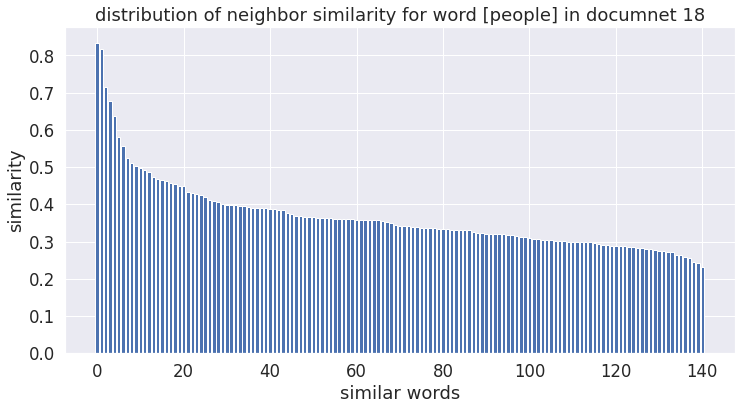

62   -->  industry
1738
[0.67886233, 0.6578784, 0.63995475, 0.6074682, 0.5919092, 0.54762363, 0.5278207, 0.5247664, 0.51738644, 0.4931843, 0.4788705, 0.47668636, 0.4738239, 0.47059536, 0.47009128, 0.46876132, 0.46118945, 0.45899642, 0.45697993, 0.45246443, 0.4511474, 0.44664133, 0.44581962, 0.4431137, 0.4385911, 0.4356364, 0.43173748, 0.43136954, 0.42919293, 0.4287447, 0.4283236, 0.42484802, 0.42339814, 0.42113116, 0.41058743, 0.40817133, 0.40816814, 0.40616202, 0.40410942, 0.40206373, 0.3983118, 0.3972789, 0.39682096, 0.3955503, 0.3916927, 0.3880308, 0.38786644, 0.3846562, 0.3804018, 0.37310883, 0.36740458, 0.36595708, 0.35952818, 0.3580196, 0.35711458, 0.35405618, 0.35201296, 0.35163686, 0.34443328, 0.34412092, 0.34305167, 0.34088764, 0.3401394, 0.33932093, 0.338749, 0.33157876, 0.33146715, 0.33129758, 0.32724184, 0.3262285, 0.3257901, 0.32518756, 0.3247948, 0.32311416, 0.32126826, 0.32041633, 0.3195132, 0.31939113, 0.31745216, 0.31669235, 0.31560534, 0.3134218, 0.31275228, 0.3125626

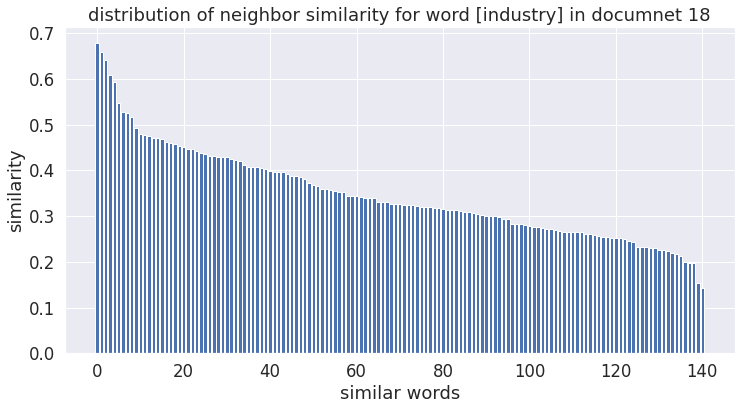

63   -->  say
1738
[0.6273945, 0.62695825, 0.61633223, 0.61070573, 0.60392123, 0.5957633, 0.5885632, 0.5755187, 0.55926853, 0.55644214, 0.5191693, 0.5179246, 0.49836075, 0.4850003, 0.4807747, 0.46802336, 0.44240463, 0.42661315, 0.42155048, 0.418151, 0.41493586, 0.40706074, 0.40418166, 0.39832067, 0.39824098, 0.39666152, 0.39615715, 0.39613348, 0.39340678, 0.3926795, 0.39046115, 0.3883828, 0.38684884, 0.3863075, 0.38621193, 0.38499635, 0.38367662, 0.38001966, 0.37879768, 0.37835792, 0.37810904, 0.37802303, 0.37240076, 0.37084568, 0.37038797, 0.36931658, 0.3685766, 0.3674488, 0.36657894, 0.3662616, 0.36625397, 0.3649885, 0.36415812, 0.36112106, 0.3574261, 0.3555963, 0.35548216, 0.3553381, 0.35512495, 0.3506781, 0.34670886, 0.34331453, 0.34088174, 0.33850586, 0.3384361, 0.33834818, 0.3381517, 0.33727, 0.3363375, 0.33349365, 0.3333037, 0.33021086, 0.33018556, 0.32855073, 0.32797396, 0.32776812, 0.32714534, 0.3259667, 0.32416135, 0.32324255, 0.32283524, 0.3220683, 0.3204789, 0.31904817, 0.3

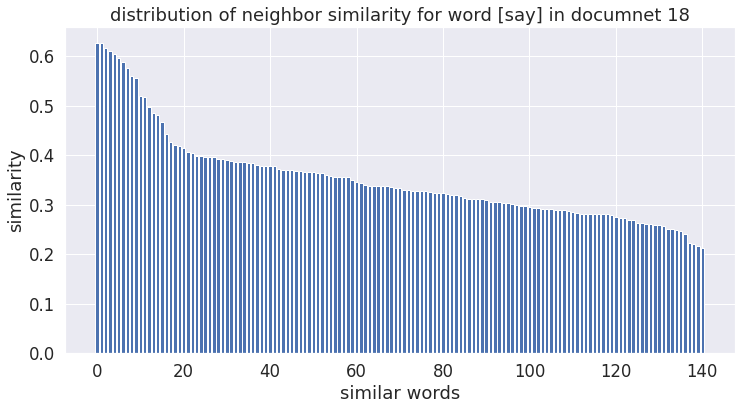

65   -->  instead
1738
[0.7261387, 0.6659711, 0.6527146, 0.6453903, 0.5990089, 0.5833045, 0.5804376, 0.5706855, 0.5280139, 0.49729705, 0.46876132, 0.4602845, 0.45357332, 0.44446185, 0.4431929, 0.44249147, 0.43414205, 0.43250203, 0.43084013, 0.42757982, 0.41758648, 0.41747236, 0.41444135, 0.40776935, 0.40773848, 0.40679282, 0.40380806, 0.4031037, 0.40194583, 0.40152168, 0.40126625, 0.4010353, 0.40067, 0.3931067, 0.39042693, 0.39002305, 0.38854164, 0.388278, 0.38639516, 0.38454238, 0.38446963, 0.38287255, 0.3828109, 0.382549, 0.38233864, 0.3820059, 0.38185537, 0.3818453, 0.38042143, 0.3796327, 0.37953946, 0.37948024, 0.37928766, 0.37925774, 0.376539, 0.37543064, 0.37540257, 0.36878604, 0.3666364, 0.36560202, 0.3652768, 0.3651011, 0.365055, 0.36332393, 0.3628983, 0.36209682, 0.3619498, 0.36190772, 0.3615064, 0.3611699, 0.36089152, 0.35948038, 0.35924634, 0.35836202, 0.35632038, 0.35611108, 0.3553558, 0.35515878, 0.35503048, 0.3523804, 0.35214156, 0.35158476, 0.35129833, 0.3503404, 0.34847

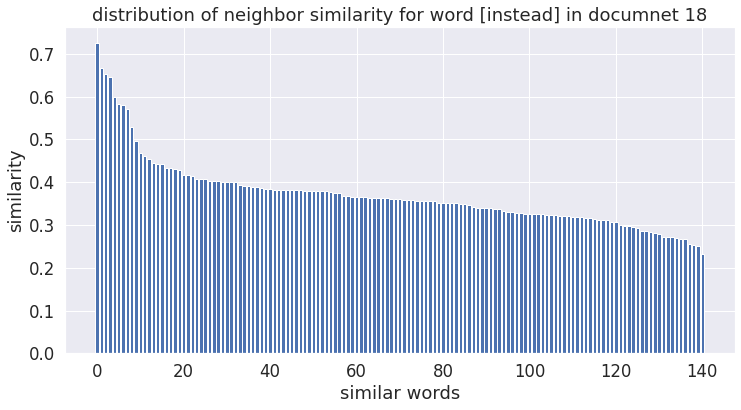

68   -->  experts
1738
[0.9255953, 0.8169067, 0.7750036, 0.6453903, 0.64474165, 0.63995475, 0.5038487, 0.49315342, 0.4930224, 0.48290253, 0.46552128, 0.46457806, 0.46348518, 0.45946658, 0.45265517, 0.4514006, 0.45107394, 0.44950426, 0.44723886, 0.44632435, 0.44502044, 0.44144273, 0.4333582, 0.43198252, 0.4240201, 0.41825354, 0.41808555, 0.4136626, 0.4126942, 0.41216612, 0.40836808, 0.40570793, 0.4015638, 0.39937666, 0.39525548, 0.39082932, 0.38836235, 0.3874642, 0.3842035, 0.38302264, 0.38290668, 0.38152248, 0.38109544, 0.37503475, 0.37211338, 0.3716643, 0.36906677, 0.36726862, 0.3663655, 0.36626416, 0.3654557, 0.3651145, 0.36330488, 0.35986552, 0.35901707, 0.35865194, 0.35803178, 0.35744685, 0.35600924, 0.35585922, 0.35563117, 0.35375088, 0.3477372, 0.34480995, 0.3411219, 0.34067282, 0.3395245, 0.3393508, 0.3379738, 0.3361309, 0.3360618, 0.3353637, 0.33483398, 0.33284283, 0.33122948, 0.33072788, 0.3302418, 0.33017674, 0.32999337, 0.32925272, 0.32871544, 0.32785597, 0.3268231, 0.326488

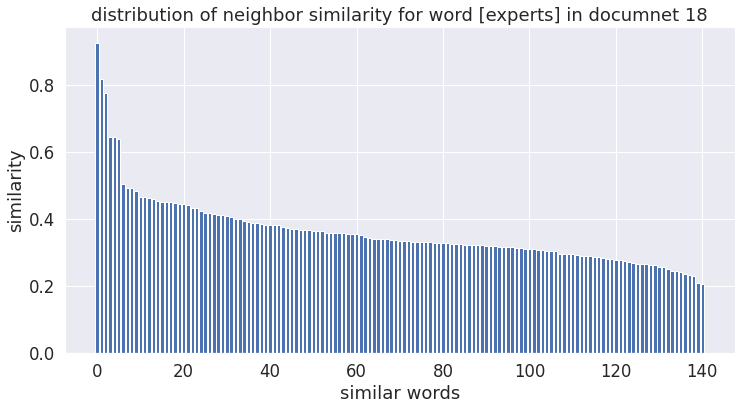

70   -->  executives
1738
[0.9255953, 0.8343948, 0.73386115, 0.6578784, 0.6352544, 0.5990089, 0.48997366, 0.4854049, 0.48307735, 0.47113732, 0.46955734, 0.46790257, 0.4676004, 0.46608785, 0.46228635, 0.46225315, 0.45636702, 0.44908893, 0.43991077, 0.43985373, 0.43411463, 0.43331635, 0.4287891, 0.4271047, 0.42249107, 0.42195717, 0.4210122, 0.42084932, 0.40983924, 0.40419143, 0.40370542, 0.39662448, 0.39400834, 0.39367858, 0.38798144, 0.3833854, 0.38263527, 0.38190114, 0.38117865, 0.38099426, 0.3808334, 0.3807035, 0.37861326, 0.3785314, 0.3777135, 0.3756326, 0.3716767, 0.3713765, 0.3710351, 0.3701113, 0.36616307, 0.36490917, 0.36356384, 0.3634019, 0.3610924, 0.3579924, 0.35755563, 0.35686836, 0.35569733, 0.35235205, 0.35021365, 0.34818074, 0.34794724, 0.34543848, 0.34210563, 0.33997294, 0.3380722, 0.33643377, 0.33602658, 0.3344836, 0.33428645, 0.33238283, 0.332164, 0.3320042, 0.33134633, 0.33122987, 0.3311321, 0.33070028, 0.32536942, 0.32364118, 0.32212943, 0.32137737, 0.32133397, 0.3206

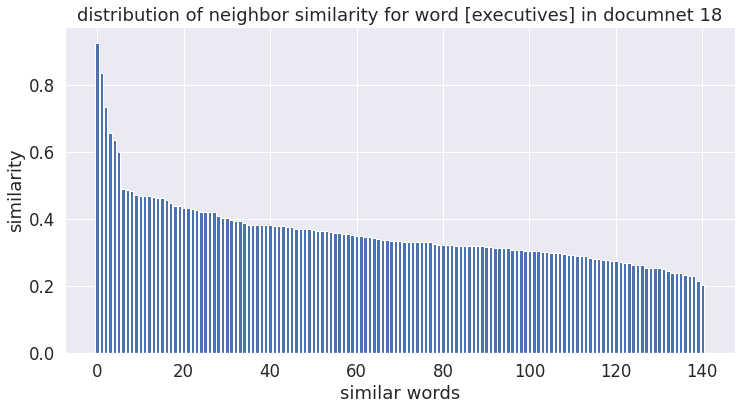

71   -->  say
1738
[0.6763467, 0.6659711, 0.64474165, 0.63849854, 0.6352544, 0.569216, 0.5615247, 0.5278207, 0.52623874, 0.5234589, 0.50596714, 0.49882364, 0.49475005, 0.48708788, 0.480191, 0.44595724, 0.43786854, 0.4350167, 0.41703343, 0.40382844, 0.40200776, 0.39339542, 0.39129305, 0.3894832, 0.3880635, 0.3876242, 0.38688576, 0.3835818, 0.38238326, 0.3812582, 0.37897334, 0.3759458, 0.37559015, 0.37510717, 0.3725206, 0.3696621, 0.36851132, 0.3684734, 0.3653993, 0.36446363, 0.36402947, 0.36238617, 0.36222744, 0.36065346, 0.35996735, 0.35531357, 0.35513145, 0.35238945, 0.35181785, 0.35042095, 0.34792536, 0.34712094, 0.34680718, 0.34581965, 0.34286356, 0.34213895, 0.3421325, 0.34138745, 0.33774978, 0.33652318, 0.33469594, 0.33244228, 0.32823274, 0.32648522, 0.32373375, 0.3234957, 0.3229069, 0.32178992, 0.32143173, 0.3197834, 0.31967038, 0.31914318, 0.31778365, 0.31761348, 0.3151573, 0.309142, 0.3091039, 0.30888742, 0.30877137, 0.30843598, 0.30714637, 0.30634356, 0.3029986, 0.30186123, 0.

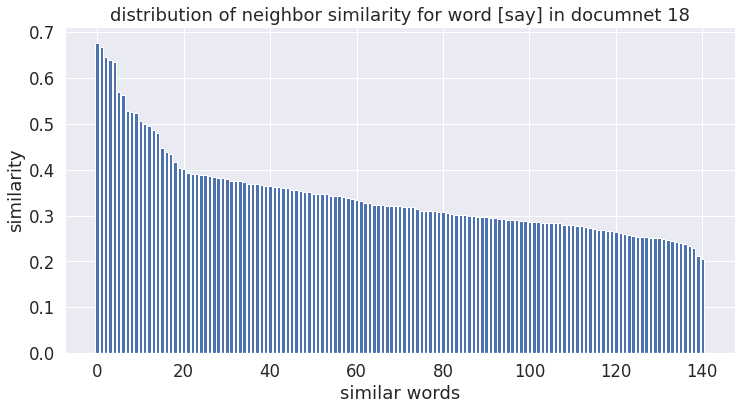

74   -->  emphasis
1738
[0.57583964, 0.52834386, 0.5227562, 0.5034383, 0.4930224, 0.48708788, 0.48307735, 0.46683967, 0.46100467, 0.45357332, 0.45036995, 0.44581962, 0.44225526, 0.42846715, 0.42270792, 0.41954455, 0.38656193, 0.37961382, 0.3750316, 0.3750022, 0.37491488, 0.37171936, 0.36379215, 0.36121136, 0.35350955, 0.3490764, 0.34638464, 0.3454752, 0.34238368, 0.34192568, 0.33980733, 0.33913583, 0.33780092, 0.3376345, 0.33689237, 0.3363584, 0.33447793, 0.33335328, 0.3304267, 0.32865196, 0.32609606, 0.32504082, 0.32405078, 0.32378945, 0.32040173, 0.3197097, 0.3180018, 0.31627494, 0.31625026, 0.31333798, 0.30951887, 0.30932835, 0.30738622, 0.30722225, 0.30085215, 0.29677635, 0.29290056, 0.29113573, 0.2904294, 0.29028648, 0.28874272, 0.28557557, 0.28277326, 0.28253883, 0.2816081, 0.27910894, 0.27843925, 0.27839494, 0.2782067, 0.27576476, 0.27512997, 0.27442747, 0.2732022, 0.2721277, 0.27130276, 0.269871, 0.26934677, 0.26840416, 0.26687306, 0.26405036, 0.26012272, 0.25990203, 0.25850192

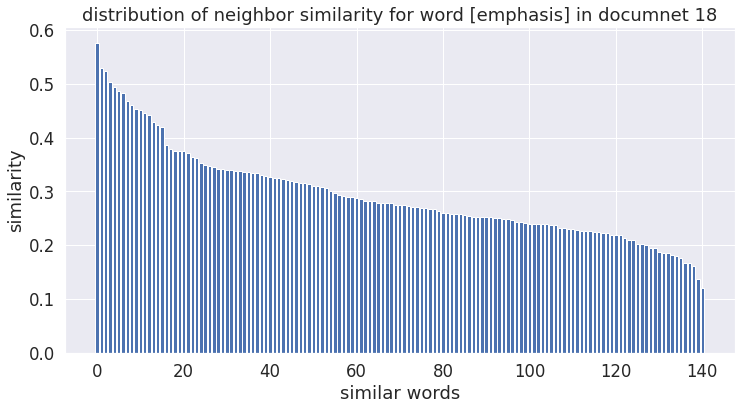

77   -->  next
1738
[0.77223134, 0.5954618, 0.5176713, 0.50644517, 0.4911016, 0.48055857, 0.45989847, 0.4549919, 0.4505614, 0.44976908, 0.4333582, 0.4271757, 0.4242236, 0.42294267, 0.42270792, 0.420312, 0.41882774, 0.41709116, 0.4131399, 0.41167462, 0.3976425, 0.38871133, 0.38815787, 0.3853432, 0.38436344, 0.3814911, 0.38084227, 0.37856156, 0.37767783, 0.3756326, 0.36834925, 0.36671168, 0.36589512, 0.36496252, 0.36479706, 0.36385816, 0.36220405, 0.36157402, 0.35924634, 0.3585653, 0.35812753, 0.35696456, 0.35450375, 0.3520289, 0.35199076, 0.35089555, 0.3483699, 0.34494656, 0.34458315, 0.34311897, 0.34014887, 0.34007218, 0.3391782, 0.3385228, 0.33819395, 0.33696908, 0.3368765, 0.33522055, 0.3328133, 0.33167005, 0.3311774, 0.32940328, 0.3292797, 0.3286773, 0.32724184, 0.32609832, 0.32595253, 0.32561654, 0.3254521, 0.32482052, 0.3222177, 0.32087678, 0.31902397, 0.31764483, 0.31582946, 0.31560498, 0.31385684, 0.3117234, 0.30951172, 0.30919534, 0.30869687, 0.30865878, 0.30716273, 0.30714637,

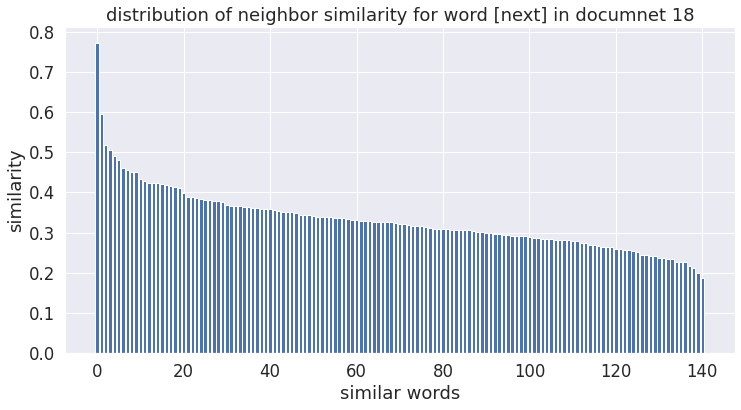

79   -->  years
1738
[0.61617875, 0.5954618, 0.5735354, 0.5592667, 0.5586605, 0.54762363, 0.49538344, 0.4854049, 0.48522177, 0.46348518, 0.46326447, 0.4573808, 0.45340073, 0.45238706, 0.44711497, 0.4444851, 0.44225526, 0.43510604, 0.43365347, 0.4307837, 0.42838934, 0.42815423, 0.42391962, 0.42242652, 0.41202354, 0.4101901, 0.41010123, 0.40466642, 0.4044161, 0.4033242, 0.40093723, 0.39260435, 0.39160812, 0.39157143, 0.38883036, 0.38649726, 0.38532293, 0.38123918, 0.37701046, 0.3764034, 0.3759458, 0.3744205, 0.37424347, 0.37234494, 0.36816546, 0.36560595, 0.36481845, 0.3637791, 0.36190772, 0.36064288, 0.35974932, 0.35008073, 0.34912708, 0.34774053, 0.34578818, 0.3456029, 0.3454204, 0.34405145, 0.34325075, 0.34200162, 0.3407793, 0.33966273, 0.3390023, 0.3375545, 0.334763, 0.33163017, 0.32659435, 0.32629335, 0.32329437, 0.32092783, 0.31919345, 0.31750864, 0.31728113, 0.31725585, 0.31208688, 0.30933025, 0.3081497, 0.30621183, 0.30568826, 0.30531508, 0.3034299, 0.3024789, 0.30170947, 0.29619

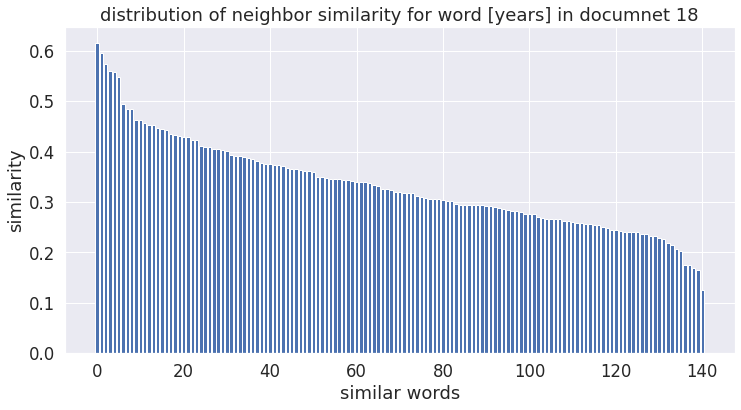

83   -->  finding
1738
[0.79302275, 0.61073774, 0.5450334, 0.5232494, 0.4913866, 0.49091387, 0.48523122, 0.48522177, 0.48055857, 0.4785185, 0.47648516, 0.4760052, 0.47009677, 0.47005072, 0.46868923, 0.46842435, 0.46552128, 0.46228635, 0.4556982, 0.45387405, 0.45105088, 0.45069697, 0.4495188, 0.44800386, 0.44754684, 0.4466076, 0.44252557, 0.43680966, 0.43414205, 0.43144113, 0.4306472, 0.43011114, 0.42863762, 0.42785695, 0.42666203, 0.42339134, 0.42267144, 0.4224919, 0.41954455, 0.41952825, 0.41873673, 0.41804463, 0.41480562, 0.41379207, 0.4120239, 0.41109985, 0.40989077, 0.40933657, 0.40916437, 0.40892747, 0.40816814, 0.40382844, 0.4036849, 0.40302432, 0.4025811, 0.40104783, 0.40022075, 0.396829, 0.39456424, 0.3932134, 0.39285317, 0.39024693, 0.39017564, 0.39000297, 0.38751408, 0.38573232, 0.38560563, 0.38391045, 0.38350767, 0.37943286, 0.37799114, 0.37747216, 0.37709183, 0.37454388, 0.37387672, 0.37371087, 0.3734098, 0.37272036, 0.37268537, 0.37066764, 0.36966503, 0.3692277, 0.36878067

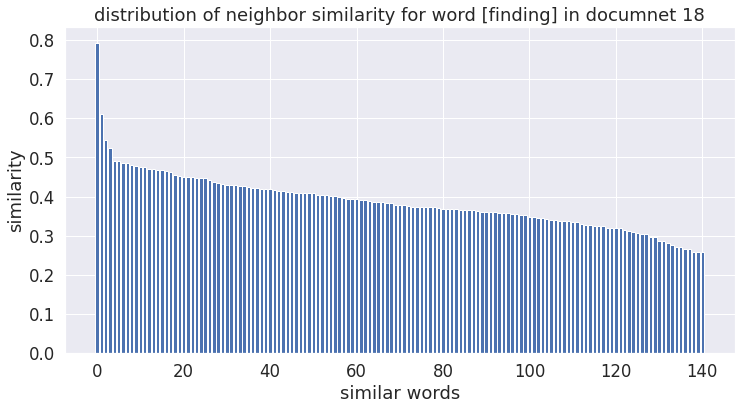

84   -->  ways
1738
[0.79302275, 0.6297307, 0.48005426, 0.46540928, 0.45220426, 0.44976908, 0.44711497, 0.4468565, 0.44434863, 0.4418993, 0.44073305, 0.43316138, 0.4278927, 0.41914716, 0.41780007, 0.41686577, 0.41402134, 0.4131915, 0.40986586, 0.40913495, 0.40716207, 0.40653956, 0.40437973, 0.4011833, 0.39809832, 0.39655918, 0.3944801, 0.39208668, 0.3916335, 0.3905782, 0.38929677, 0.3886414, 0.38836235, 0.38685325, 0.3844137, 0.38374668, 0.38099426, 0.38023826, 0.3790964, 0.37713826, 0.37698233, 0.3734252, 0.37234464, 0.37149495, 0.37124115, 0.37115765, 0.36876422, 0.3680031, 0.36784804, 0.3669753, 0.36675274, 0.3656643, 0.36560202, 0.36533505, 0.36446363, 0.3638114, 0.3634013, 0.36246818, 0.35788727, 0.35663414, 0.3560029, 0.35481533, 0.35345882, 0.35279623, 0.35274002, 0.34925094, 0.34785372, 0.34771147, 0.34732908, 0.34615946, 0.3454057, 0.34490895, 0.34399796, 0.34394005, 0.340001, 0.33981112, 0.33954078, 0.33729896, 0.3355088, 0.3352673, 0.33429563, 0.3337705, 0.33335328, 0.332686

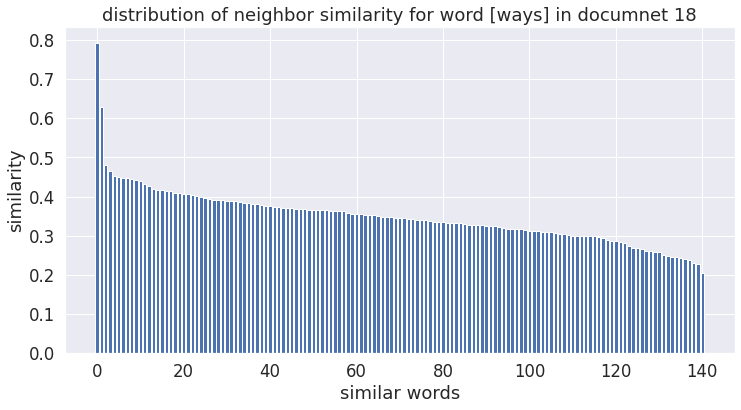

86   -->  extend
1738
[0.6297307, 0.6272515, 0.61073774, 0.5322535, 0.52827764, 0.47064286, 0.44546127, 0.4444851, 0.43753454, 0.43158075, 0.40845528, 0.39679867, 0.39608404, 0.39582992, 0.39212635, 0.38380036, 0.37984574, 0.37981868, 0.37666023, 0.3760159, 0.37520635, 0.36740458, 0.3653993, 0.35594702, 0.35199076, 0.34970003, 0.34795606, 0.34781873, 0.3468979, 0.34678718, 0.34480995, 0.34368843, 0.34299505, 0.34238368, 0.33762816, 0.3372863, 0.33647433, 0.33628023, 0.33572692, 0.3357057, 0.33285725, 0.33122987, 0.3303895, 0.32997945, 0.32913646, 0.32835543, 0.32752526, 0.32654163, 0.32544953, 0.32509285, 0.32253963, 0.3216393, 0.31984952, 0.3198005, 0.31972244, 0.3195356, 0.31950557, 0.31891274, 0.31818354, 0.31581557, 0.3151874, 0.31500417, 0.31148207, 0.31045666, 0.3090223, 0.30888617, 0.3081056, 0.3076067, 0.30753008, 0.3072586, 0.30581552, 0.30312797, 0.30190545, 0.30187476, 0.30142346, 0.30110547, 0.30107236, 0.29921862, 0.29909775, 0.29901692, 0.2968227, 0.29670334, 0.29628438, 

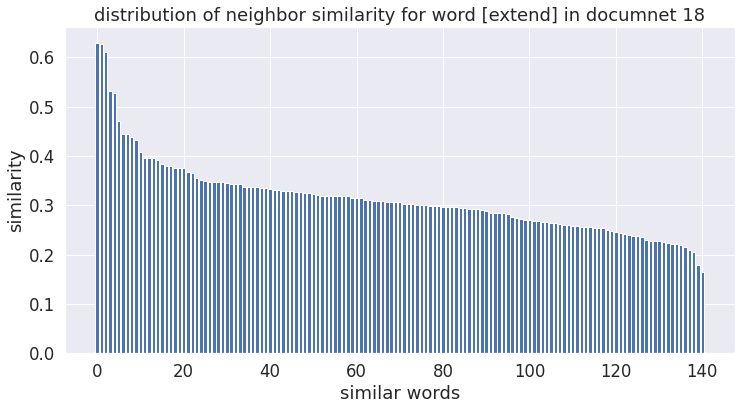

88   -->  life
1738
[0.60952556, 0.5404687, 0.52827764, 0.40737277, 0.40718687, 0.40527937, 0.40466642, 0.40377218, 0.39892924, 0.3955503, 0.3934415, 0.38202995, 0.36628658, 0.36613622, 0.36137247, 0.3599176, 0.35426924, 0.35144398, 0.3499666, 0.34224486, 0.33875275, 0.33573353, 0.33493483, 0.33429563, 0.33396688, 0.33017004, 0.32632893, 0.3254043, 0.3236346, 0.32337007, 0.3205407, 0.31352246, 0.30717972, 0.30609092, 0.30354962, 0.30229414, 0.3021444, 0.30024984, 0.29911095, 0.2986918, 0.2945184, 0.29284304, 0.2923707, 0.28674012, 0.28654596, 0.28532115, 0.28004813, 0.27817804, 0.27770832, 0.27615458, 0.2748891, 0.27460885, 0.2728842, 0.2727594, 0.27244768, 0.27146277, 0.27077734, 0.27069825, 0.269871, 0.2693714, 0.26902187, 0.26886478, 0.26791325, 0.26788795, 0.26736492, 0.2673285, 0.26732817, 0.26611817, 0.26588008, 0.2648043, 0.26426977, 0.26422358, 0.26353183, 0.26273566, 0.26108417, 0.25992393, 0.2591698, 0.25817984, 0.25804645, 0.25793827, 0.25718158, 0.25692058, 0.2566369, 0.255

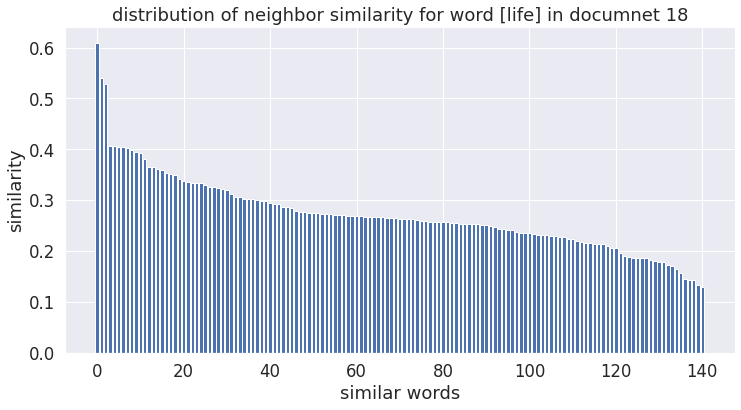

91   -->  current
1738
[0.6272515, 0.60952556, 0.60444516, 0.53664625, 0.49472037, 0.4947057, 0.4760052, 0.44542217, 0.44073305, 0.43730366, 0.43185937, 0.4307837, 0.42298895, 0.4131399, 0.41207808, 0.4096099, 0.40757164, 0.3985772, 0.39739418, 0.38774478, 0.38469878, 0.3833001, 0.38207763, 0.38047722, 0.37749076, 0.37583652, 0.3734826, 0.3685614, 0.3679472, 0.36562854, 0.36333585, 0.36168858, 0.36160153, 0.3614608, 0.35952818, 0.35865703, 0.35857242, 0.35589373, 0.35401517, 0.35341743, 0.35339516, 0.35189193, 0.35106093, 0.35053378, 0.3499765, 0.3481173, 0.34546217, 0.34350526, 0.3425039, 0.34112525, 0.3406071, 0.34041458, 0.338032, 0.33689237, 0.3360771, 0.33112246, 0.3310391, 0.33020517, 0.32972214, 0.32894653, 0.3280943, 0.32714114, 0.32640046, 0.32579, 0.32535857, 0.32505456, 0.3237263, 0.3231232, 0.32212827, 0.32194144, 0.3193667, 0.3190264, 0.318889, 0.31849226, 0.3174235, 0.3155939, 0.31453884, 0.31299433, 0.31284952, 0.3094691, 0.30555907, 0.30432773, 0.3031445, 0.30308375, 0.

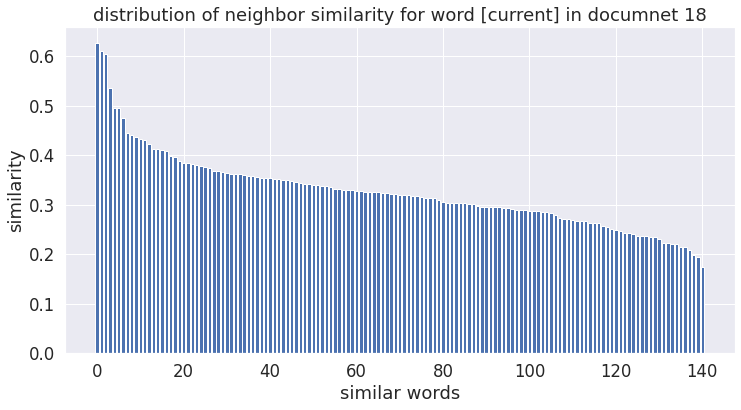

92   -->  fleet
1738
[0.6646576, 0.636258, 0.6335327, 0.57701623, 0.50106, 0.4980021, 0.48484403, 0.47579658, 0.46583414, 0.46195853, 0.4598583, 0.44194993, 0.44026914, 0.4398524, 0.43635583, 0.435493, 0.42924273, 0.42666256, 0.41975135, 0.41801625, 0.41497272, 0.41328335, 0.40512383, 0.40085745, 0.39983582, 0.39636573, 0.39495522, 0.39385086, 0.39110538, 0.3851101, 0.3787245, 0.37263083, 0.3680797, 0.3667307, 0.36442077, 0.3618031, 0.358024, 0.35492694, 0.3515014, 0.3504043, 0.3485515, 0.34717098, 0.3463419, 0.34617925, 0.34418097, 0.34277186, 0.3359309, 0.3357618, 0.33438253, 0.33084857, 0.32973206, 0.32960206, 0.3288355, 0.32846838, 0.32766324, 0.32685804, 0.3263638, 0.32322055, 0.31979126, 0.31921542, 0.31810218, 0.31703553, 0.3161688, 0.3141065, 0.31372082, 0.31234783, 0.3111903, 0.30973446, 0.30910158, 0.30910075, 0.3090158, 0.30813468, 0.3068424, 0.3046293, 0.30421227, 0.30295455, 0.3017342, 0.30130622, 0.30012015, 0.29869878, 0.29520524, 0.29472208, 0.29430336, 0.29423034, 0.29

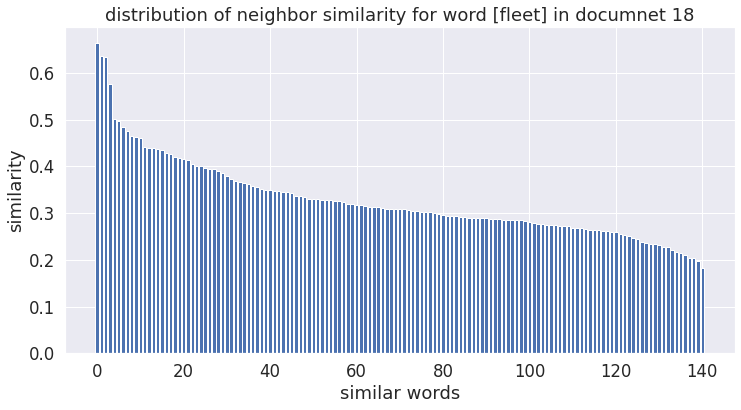

94   -->  freighter
1738
[0.87225294, 0.6617382, 0.6243019, 0.56131387, 0.54127026, 0.51676565, 0.50994873, 0.5074687, 0.50652564, 0.49951065, 0.4979323, 0.4947057, 0.48733532, 0.4811673, 0.46326447, 0.4601075, 0.45633686, 0.45330074, 0.4522875, 0.4333415, 0.43210083, 0.43136954, 0.42876709, 0.42799714, 0.42771703, 0.42695498, 0.42451352, 0.4244315, 0.42429334, 0.41936216, 0.41830474, 0.41709116, 0.41515607, 0.4102223, 0.4076512, 0.4073978, 0.40737277, 0.40615237, 0.40469277, 0.40064222, 0.3972448, 0.39472187, 0.39310175, 0.3930254, 0.39082932, 0.39024693, 0.3886414, 0.38168544, 0.37955278, 0.37933105, 0.37849203, 0.37773633, 0.3777135, 0.37564465, 0.37320805, 0.36981148, 0.36461586, 0.36383525, 0.36330926, 0.3624674, 0.36117536, 0.3611699, 0.36111504, 0.35905612, 0.3584534, 0.35536972, 0.3491336, 0.34633064, 0.3454822, 0.34413403, 0.34299505, 0.34233683, 0.34213895, 0.33859003, 0.33540264, 0.3353594, 0.33492827, 0.33465666, 0.33259803, 0.33249956, 0.33206075, 0.33089742, 0.33052826, 0

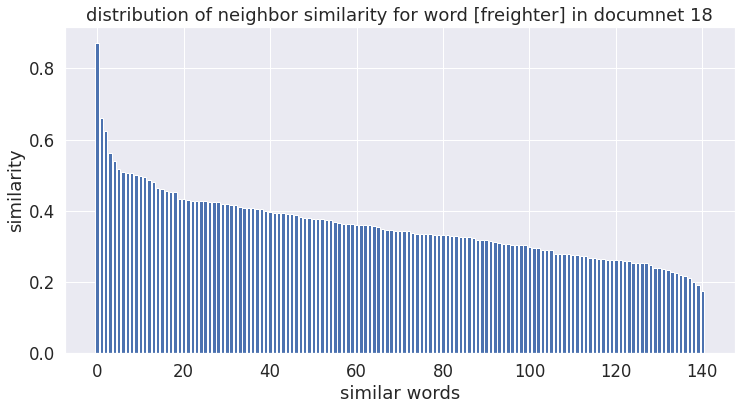

95   -->  ##s
1738
[0.6982375, 0.5766535, 0.5754059, 0.568555, 0.5440583, 0.5324334, 0.53230083, 0.52165097, 0.52096474, 0.51460356, 0.5081173, 0.49978054, 0.47912154, 0.47302878, 0.46881968, 0.46160716, 0.45298845, 0.45209968, 0.4507386, 0.44870818, 0.44700986, 0.44497848, 0.43785438, 0.4374982, 0.4342969, 0.42808574, 0.42140177, 0.4180844, 0.41669488, 0.411591, 0.40882182, 0.406892, 0.40153375, 0.39940563, 0.3978779, 0.39632022, 0.39352813, 0.3928121, 0.39054942, 0.38964933, 0.38959587, 0.3869577, 0.38190928, 0.37848642, 0.37841213, 0.3777775, 0.37680808, 0.37655428, 0.37474963, 0.37316185, 0.37258154, 0.3700258, 0.36758804, 0.36682707, 0.36436206, 0.36382252, 0.36308265, 0.3625859, 0.35946286, 0.35896003, 0.35692853, 0.3567282, 0.35460097, 0.3522174, 0.35203117, 0.34834194, 0.34554124, 0.3453077, 0.344492, 0.34349912, 0.34329817, 0.34286183, 0.33921188, 0.33742037, 0.33731854, 0.3358127, 0.33438775, 0.3343799, 0.3341063, 0.33404124, 0.33369216, 0.3335061, 0.33194926, 0.33097863, 0.3

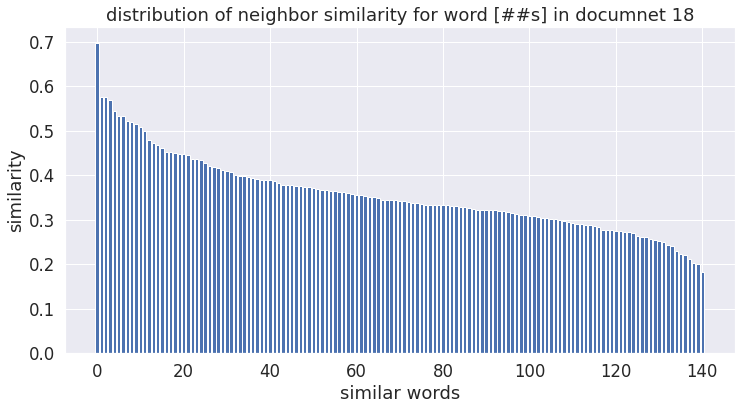

97   -->  tanker
1738
[0.87225294, 0.6736735, 0.6290566, 0.5748274, 0.57196337, 0.5323516, 0.5319695, 0.53067017, 0.5255041, 0.51782, 0.5153981, 0.51445067, 0.49542522, 0.4936458, 0.47843584, 0.4782849, 0.478238, 0.47087276, 0.456065, 0.45453045, 0.44410005, 0.44387543, 0.43676746, 0.43365347, 0.43288115, 0.43185937, 0.42975897, 0.4277978, 0.42551655, 0.42484802, 0.42459825, 0.42436475, 0.42368457, 0.42205238, 0.42153183, 0.4212231, 0.41994965, 0.4160576, 0.41429085, 0.41204914, 0.41167462, 0.41000065, 0.40211982, 0.39525548, 0.39166936, 0.38690782, 0.38540575, 0.38378894, 0.38162997, 0.3808334, 0.37760127, 0.37594724, 0.375315, 0.37494946, 0.37439594, 0.37426025, 0.37304485, 0.37082613, 0.37070814, 0.36870897, 0.36827904, 0.36572737, 0.3615146, 0.3599685, 0.35988048, 0.35987186, 0.35655028, 0.35345882, 0.35270554, 0.3515681, 0.3515441, 0.3499666, 0.34966585, 0.34941193, 0.348656, 0.34815186, 0.34724343, 0.34712094, 0.34586418, 0.34114164, 0.34045154, 0.3403635, 0.34026968, 0.3401631, 

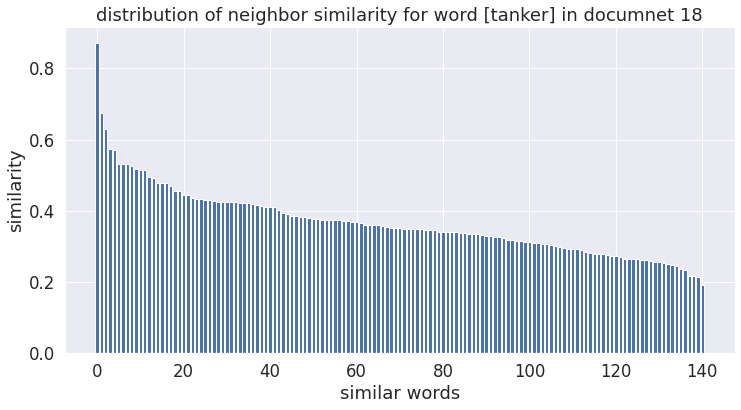

98   -->  ##s
1738
[0.65176994, 0.58154607, 0.56692785, 0.5607332, 0.5444472, 0.5370958, 0.5344703, 0.5331354, 0.532475, 0.5300575, 0.5125057, 0.4930703, 0.4891533, 0.4885954, 0.48164886, 0.46873856, 0.46830043, 0.4674382, 0.4537325, 0.44286144, 0.433466, 0.42220652, 0.41474837, 0.41108072, 0.40742075, 0.40729976, 0.40381348, 0.40351444, 0.40100563, 0.39950496, 0.39924935, 0.39815408, 0.39798936, 0.39764988, 0.39316767, 0.39189625, 0.39143807, 0.39040184, 0.38876152, 0.38838536, 0.387618, 0.38091898, 0.380894, 0.38002163, 0.37564406, 0.37543616, 0.37419382, 0.3688209, 0.36825237, 0.3680666, 0.3655945, 0.3651591, 0.36457402, 0.3618083, 0.36049736, 0.36033332, 0.35884935, 0.3581621, 0.35775363, 0.3535347, 0.3498763, 0.3498257, 0.34818488, 0.34672692, 0.34648034, 0.34592673, 0.34559196, 0.34419706, 0.34114707, 0.33869854, 0.3385185, 0.33848798, 0.33830756, 0.33720648, 0.33710492, 0.3360356, 0.33280247, 0.33202904, 0.3312319, 0.3308313, 0.32995614, 0.32525998, 0.32482344, 0.324507, 0.32420

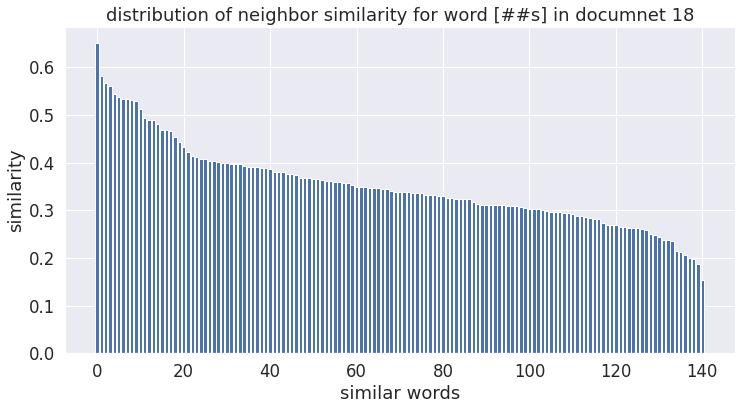

103   -->  world
1738
[0.57454985, 0.47059536, 0.4680856, 0.42721808, 0.42616895, 0.41139573, 0.40952784, 0.40329146, 0.39569783, 0.38656193, 0.37943286, 0.3749773, 0.36778894, 0.36356384, 0.36166173, 0.35941368, 0.35744685, 0.34678718, 0.34444073, 0.34112626, 0.340001, 0.3359084, 0.334763, 0.3341169, 0.32685906, 0.32650673, 0.32590246, 0.3236346, 0.3235106, 0.32087678, 0.31828856, 0.3171186, 0.3159261, 0.31051195, 0.31050938, 0.30769408, 0.30749047, 0.30593035, 0.3029232, 0.29964226, 0.29919076, 0.29407892, 0.29337937, 0.29294914, 0.29117048, 0.2859699, 0.2859626, 0.28552395, 0.2847523, 0.2809798, 0.28087765, 0.28009024, 0.27877876, 0.2773646, 0.2767802, 0.27577847, 0.2748855, 0.2748129, 0.27411753, 0.27336043, 0.27043578, 0.2627465, 0.26224816, 0.25362787, 0.2516538, 0.2512808, 0.24895462, 0.24724388, 0.24717194, 0.24602062, 0.2453339, 0.24522644, 0.24487488, 0.24482895, 0.24296904, 0.24266277, 0.24125421, 0.24116474, 0.23918481, 0.2379213, 0.23732005, 0.23642477, 0.23583975, 0.23444

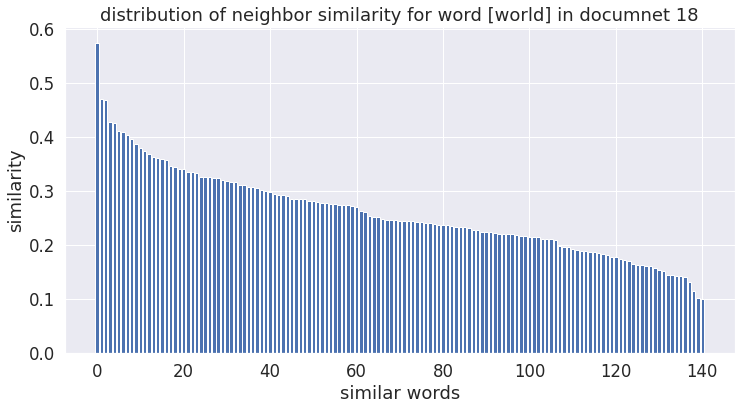

108   -->  content
1738
[0.6216047, 0.57454985, 0.5530788, 0.54598117, 0.51471317, 0.47695345, 0.44113916, 0.43680966, 0.41521382, 0.41274682, 0.40810245, 0.39679867, 0.3964121, 0.39155135, 0.3904541, 0.38599432, 0.38132966, 0.3806486, 0.37744167, 0.37713826, 0.37491488, 0.36834925, 0.36803094, 0.3664085, 0.36626416, 0.36614054, 0.36300373, 0.36019307, 0.3594917, 0.35755563, 0.35084727, 0.34938323, 0.34855214, 0.33902425, 0.33558887, 0.33134168, 0.3310391, 0.33072388, 0.3265407, 0.32493612, 0.32482478, 0.32019767, 0.31777364, 0.3176482, 0.31684774, 0.31581798, 0.31434777, 0.31016865, 0.30641812, 0.30584633, 0.30489755, 0.30207783, 0.29796737, 0.2974753, 0.29679158, 0.29612815, 0.2943957, 0.29360577, 0.2902643, 0.29021657, 0.28822476, 0.2878478, 0.2862299, 0.28315789, 0.28228062, 0.28190565, 0.2805575, 0.28007752, 0.27904814, 0.27782378, 0.27718487, 0.27686936, 0.27473825, 0.27449924, 0.2743407, 0.2723989, 0.27213705, 0.2710517, 0.2695101, 0.26709569, 0.2660804, 0.2653736, 0.26311213, 0

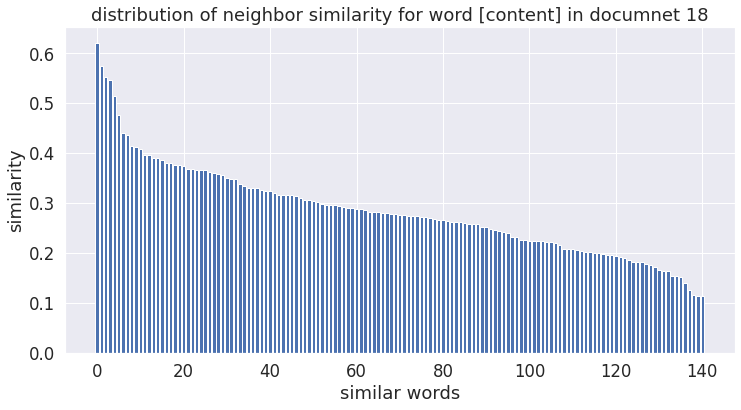

111   -->  existing
1738
[0.6626972, 0.607839, 0.6074693, 0.60444516, 0.5530788, 0.5322535, 0.47648516, 0.4680856, 0.45910913, 0.45364076, 0.44241348, 0.43316138, 0.4213361, 0.40641308, 0.39892924, 0.3827682, 0.38123918, 0.37687546, 0.3757732, 0.3754956, 0.3705963, 0.36915934, 0.36538276, 0.35821074, 0.3576399, 0.35561672, 0.351422, 0.35004425, 0.3491336, 0.3490764, 0.34905678, 0.34896332, 0.3427086, 0.34252423, 0.33932093, 0.33570343, 0.33438843, 0.33426887, 0.3302418, 0.32984436, 0.32595253, 0.32484907, 0.32484865, 0.32420057, 0.32373512, 0.3233242, 0.32212943, 0.32206124, 0.32067317, 0.3200535, 0.31857854, 0.31597483, 0.3151871, 0.31341308, 0.31312895, 0.31143755, 0.30877137, 0.30582088, 0.3047275, 0.30344057, 0.29723006, 0.29474515, 0.29451013, 0.29275745, 0.2880226, 0.2875054, 0.28624755, 0.28515488, 0.28201056, 0.28198004, 0.28196314, 0.27979904, 0.2772839, 0.2765707, 0.27627644, 0.27371204, 0.27260253, 0.27236527, 0.27148712, 0.2713305, 0.27046, 0.27029532, 0.26903903, 0.2685081

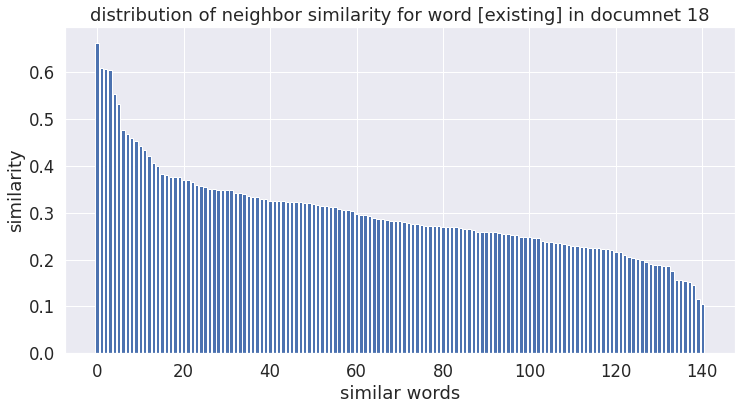

112   -->  fleet
1738
[0.6626972, 0.6187906, 0.5424466, 0.5404687, 0.53664625, 0.5117521, 0.5090827, 0.49407583, 0.48677328, 0.47695345, 0.47212723, 0.47064286, 0.4597869, 0.45409137, 0.44982928, 0.43550327, 0.43143618, 0.42863762, 0.42799714, 0.42721808, 0.42551655, 0.41235614, 0.41162032, 0.40937483, 0.4048781, 0.40437973, 0.40134346, 0.40023035, 0.39891392, 0.39808023, 0.38786644, 0.38720936, 0.3867637, 0.37509462, 0.37474713, 0.3746388, 0.37285185, 0.37022856, 0.37002096, 0.36974055, 0.36674473, 0.3650375, 0.3637791, 0.36297596, 0.36263236, 0.36253047, 0.36108392, 0.36015862, 0.357531, 0.35627413, 0.35530567, 0.35296813, 0.35104647, 0.3499055, 0.3474381, 0.34370267, 0.33965158, 0.3370364, 0.3361562, 0.33572668, 0.33482635, 0.3302284, 0.3241901, 0.32254404, 0.3212311, 0.31827253, 0.31704885, 0.3158225, 0.31206977, 0.31185266, 0.3106751, 0.30919534, 0.3078816, 0.30724996, 0.30712086, 0.30634356, 0.30583084, 0.3035574, 0.30351037, 0.30157787, 0.29996407, 0.29883307, 0.29733735, 0.2968

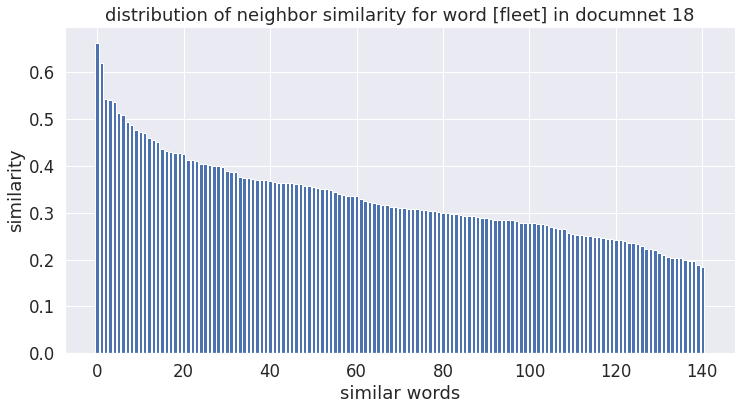

114   -->  elderly
1738
[0.7362803, 0.607839, 0.5952774, 0.59459364, 0.5822544, 0.54598117, 0.51350105, 0.49407583, 0.45789644, 0.4036849, 0.40329146, 0.392771, 0.36802137, 0.35941225, 0.35309204, 0.3518994, 0.34490895, 0.34021086, 0.3372863, 0.33536103, 0.33507305, 0.32985753, 0.32929325, 0.3280943, 0.32347262, 0.32334673, 0.32060343, 0.3184526, 0.31774503, 0.31582946, 0.31481338, 0.31443387, 0.31395802, 0.31301773, 0.31250268, 0.31027085, 0.30967218, 0.30886036, 0.3088215, 0.3085659, 0.3082673, 0.30781543, 0.30679885, 0.3061021, 0.30547455, 0.30312547, 0.30278024, 0.300817, 0.299105, 0.29904488, 0.29893422, 0.2980494, 0.2942189, 0.2918434, 0.29013127, 0.28952613, 0.28826872, 0.28800964, 0.287891, 0.28746474, 0.28684515, 0.28644824, 0.28609246, 0.28485873, 0.28302574, 0.28300485, 0.28168318, 0.2807715, 0.27997547, 0.2792596, 0.27889836, 0.27616507, 0.27471107, 0.27381706, 0.2737341, 0.26853397, 0.26638976, 0.26605415, 0.2659484, 0.26510105, 0.26355135, 0.26165572, 0.26060483, 0.259677

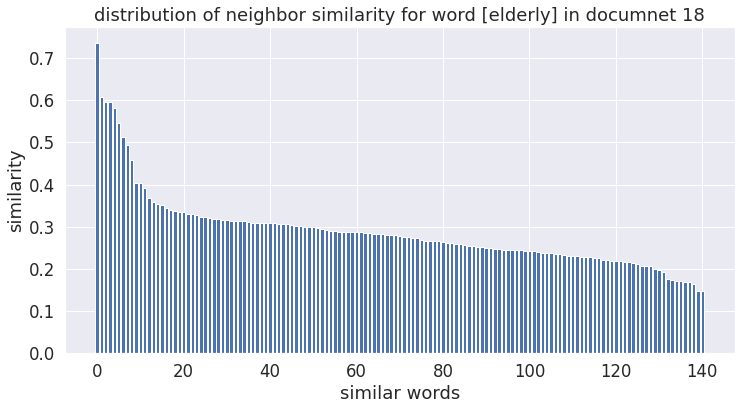

115   -->  ladies
1738
[0.7362803, 0.6744062, 0.5876565, 0.55633736, 0.55547094, 0.5424466, 0.51471317, 0.45910913, 0.4345299, 0.43288115, 0.42510504, 0.42451352, 0.41139573, 0.396829, 0.3937092, 0.39031604, 0.39012825, 0.3844137, 0.3840809, 0.38373938, 0.37993225, 0.37849298, 0.37827384, 0.37221837, 0.37070227, 0.3670212, 0.36564732, 0.36124197, 0.3608535, 0.36041945, 0.35840145, 0.35563076, 0.34794724, 0.34721112, 0.34703553, 0.34512156, 0.34466285, 0.34443253, 0.34048104, 0.34020197, 0.33909062, 0.33873722, 0.3386773, 0.33647433, 0.3362735, 0.33507305, 0.3333706, 0.3322057, 0.33214247, 0.33059385, 0.32940328, 0.32648855, 0.32261, 0.32233912, 0.3185239, 0.31808466, 0.3173815, 0.31725585, 0.3151723, 0.31481552, 0.31047773, 0.30759713, 0.3066944, 0.3060715, 0.30230123, 0.30091867, 0.29918677, 0.2987334, 0.2956055, 0.29557085, 0.29028013, 0.2889758, 0.28858605, 0.28677166, 0.28586927, 0.2850324, 0.28236133, 0.2817806, 0.27894038, 0.2782397, 0.27809066, 0.27775812, 0.27705327, 0.27543235

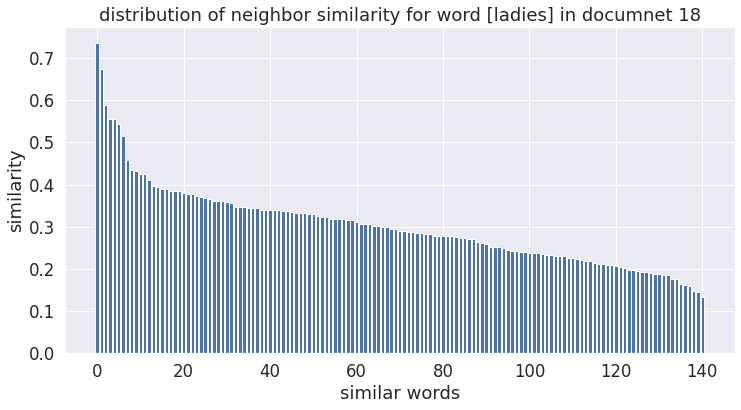

117   -->  war
1738
[0.57201433, 0.5675441, 0.46809345, 0.45789644, 0.4345299, 0.36300373, 0.36015862, 0.3503859, 0.32434213, 0.3060668, 0.30049545, 0.29698575, 0.29249018, 0.29108787, 0.29038468, 0.2901898, 0.28854537, 0.2877234, 0.28606755, 0.28575855, 0.2849342, 0.28474766, 0.28456378, 0.2823441, 0.28190947, 0.28190243, 0.28178734, 0.28078666, 0.27979696, 0.27709514, 0.2767676, 0.2767577, 0.27569485, 0.27477878, 0.27343017, 0.2718085, 0.26922208, 0.26726162, 0.2634939, 0.2627465, 0.26190946, 0.2618246, 0.2597019, 0.25936654, 0.25916582, 0.25865838, 0.25852716, 0.25536096, 0.25433266, 0.25337946, 0.25306398, 0.25257644, 0.2517899, 0.25166342, 0.25163394, 0.2510239, 0.24897492, 0.24812508, 0.24808022, 0.24738003, 0.24697225, 0.24414957, 0.24374527, 0.24203762, 0.24054879, 0.24014527, 0.24002032, 0.23906814, 0.2388839, 0.23771255, 0.2375591, 0.23718992, 0.23710905, 0.23696537, 0.23668592, 0.23499171, 0.23451158, 0.23256508, 0.23206541, 0.231829, 0.23118591, 0.23079744, 0.2279182, 0.227

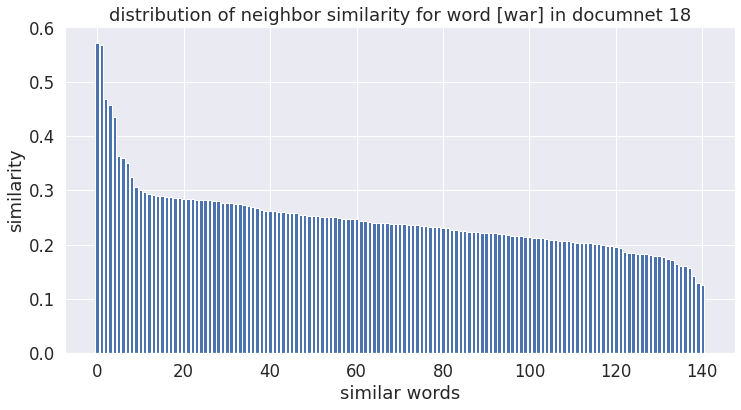

118   -->  ##ts
1738
[0.6804042, 0.6744062, 0.66824037, 0.5952774, 0.57201433, 0.5117521, 0.509721, 0.5015942, 0.44808426, 0.40810245, 0.4024815, 0.392218, 0.39081004, 0.39000297, 0.3809917, 0.3786763, 0.37585878, 0.3754956, 0.37515324, 0.37494946, 0.3699202, 0.36462665, 0.3632452, 0.3605336, 0.3604964, 0.3567222, 0.35625425, 0.35580516, 0.35553908, 0.3527934, 0.35097215, 0.34944552, 0.34785372, 0.3430401, 0.34152693, 0.34133053, 0.33650643, 0.33540264, 0.33493164, 0.33491042, 0.3347801, 0.3332921, 0.3328133, 0.33280343, 0.33266932, 0.33098072, 0.33017784, 0.32915127, 0.32785597, 0.32464004, 0.3240104, 0.32377064, 0.32181686, 0.32133353, 0.321143, 0.3202481, 0.31874317, 0.3166278, 0.31573063, 0.3155534, 0.31317538, 0.3112172, 0.30888617, 0.30824804, 0.30769303, 0.3073892, 0.30491924, 0.30475563, 0.3044778, 0.30442357, 0.3007627, 0.29843402, 0.29712683, 0.29637706, 0.29619536, 0.29612082, 0.29563725, 0.2942414, 0.29261523, 0.2925847, 0.29045433, 0.28926504, 0.28734392, 0.2847523, 0.2847

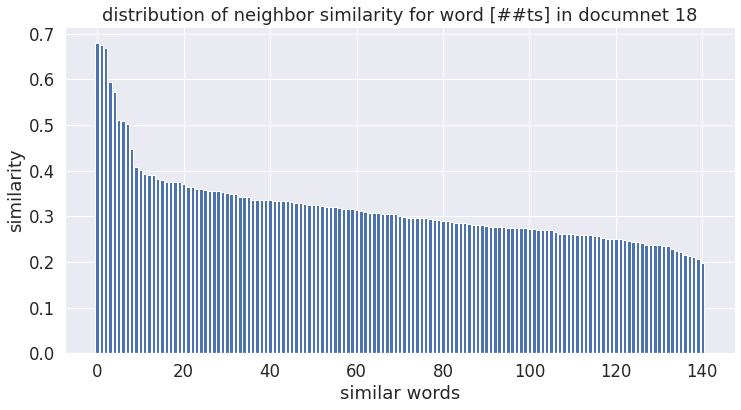

120   -->  face
1738
[0.78518, 0.66824037, 0.59459364, 0.5876565, 0.5675441, 0.5090827, 0.4936998, 0.44411767, 0.44327873, 0.4165045, 0.41521382, 0.406381, 0.40587795, 0.40459204, 0.39996648, 0.39759296, 0.39187384, 0.38664907, 0.38248587, 0.38124007, 0.38013703, 0.37961578, 0.3787604, 0.37656376, 0.3705963, 0.36970466, 0.3692277, 0.36908337, 0.36891836, 0.36831275, 0.36699316, 0.36313033, 0.3624314, 0.3613559, 0.36076218, 0.3597903, 0.35826814, 0.35703355, 0.35369465, 0.3529916, 0.35270554, 0.35216266, 0.35159227, 0.3514527, 0.3510636, 0.3507416, 0.34963518, 0.34810197, 0.34687603, 0.34630162, 0.3458666, 0.34386915, 0.34296533, 0.34249803, 0.34234816, 0.34090874, 0.33861932, 0.3379738, 0.337963, 0.337839, 0.3374967, 0.33632198, 0.33576795, 0.33489978, 0.3314399, 0.33134633, 0.330675, 0.32881904, 0.32857257, 0.32685906, 0.32665744, 0.32526898, 0.32512814, 0.3247217, 0.3246431, 0.3227074, 0.3222891, 0.32161686, 0.32067326, 0.32048905, 0.3192867, 0.31912428, 0.3188786, 0.3182828, 0.31811

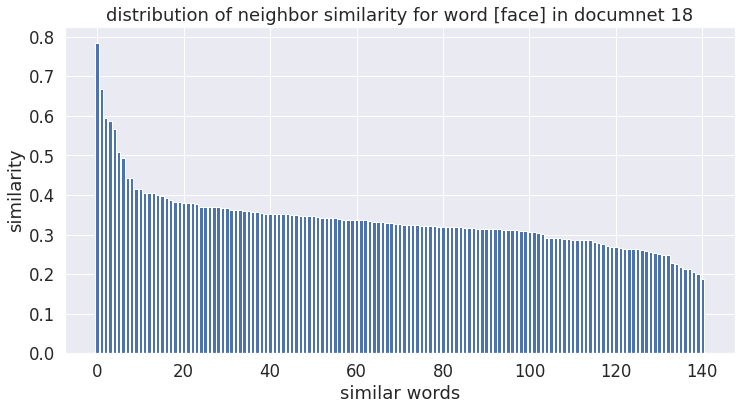

121   -->  lifts
1738
[0.78518, 0.6804042, 0.5822544, 0.55547094, 0.53470564, 0.46809345, 0.45409137, 0.44315672, 0.42385036, 0.42371708, 0.41973865, 0.41292426, 0.385696, 0.38164312, 0.38132966, 0.3763986, 0.3757732, 0.37070107, 0.37035415, 0.3702579, 0.36997426, 0.36956602, 0.369347, 0.36931884, 0.36790007, 0.36321974, 0.36272246, 0.3591807, 0.35905212, 0.3562258, 0.35207272, 0.35190356, 0.34878558, 0.34818244, 0.3481186, 0.34699538, 0.3468979, 0.3463977, 0.34452933, 0.34337106, 0.34114164, 0.33785132, 0.3353381, 0.33290902, 0.3327167, 0.33235347, 0.32947165, 0.32684773, 0.3264984, 0.3260343, 0.3254735, 0.32469103, 0.32308167, 0.3229472, 0.32227394, 0.32177508, 0.32008344, 0.31963724, 0.3194594, 0.31929994, 0.31872016, 0.31466186, 0.31465566, 0.31450585, 0.31282812, 0.31153864, 0.30901095, 0.3088856, 0.30855677, 0.3074246, 0.30683684, 0.30521238, 0.30497617, 0.30480728, 0.30470002, 0.30435896, 0.30409816, 0.30392087, 0.3034559, 0.30243617, 0.2997465, 0.29886723, 0.29750097, 0.2970120

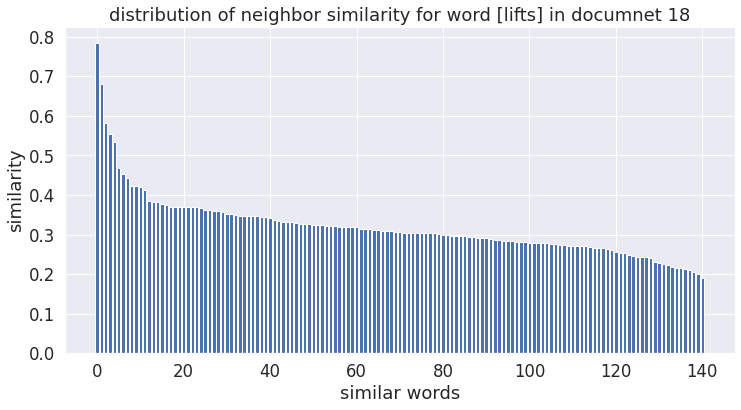

127   -->  said
1738
[0.7376033, 0.5864357, 0.5799205, 0.569216, 0.5567499, 0.5452938, 0.48331317, 0.4795641, 0.47370806, 0.4625575, 0.45823365, 0.4514006, 0.44534287, 0.44513118, 0.43991077, 0.42919293, 0.42174017, 0.40762815, 0.40716347, 0.39271146, 0.390868, 0.39002305, 0.38742253, 0.3796097, 0.35788685, 0.35707727, 0.3515441, 0.351422, 0.35139614, 0.3440723, 0.34288597, 0.33800066, 0.33424813, 0.33355245, 0.33212388, 0.3302284, 0.32865196, 0.32800078, 0.32765752, 0.3275216, 0.32650673, 0.3192379, 0.31778702, 0.3176482, 0.31701058, 0.31398496, 0.31348902, 0.30994803, 0.3090223, 0.30715394, 0.3061934, 0.3060715, 0.30568826, 0.30428222, 0.30207795, 0.3008517, 0.29999116, 0.2998444, 0.2988783, 0.29260564, 0.29199165, 0.29030165, 0.28766793, 0.28627494, 0.28549904, 0.28269756, 0.2807313, 0.2792596, 0.27647427, 0.27540433, 0.27463117, 0.2738648, 0.27159277, 0.27059558, 0.26797456, 0.26723453, 0.26698333, 0.26646492, 0.2653048, 0.26273564, 0.2626853, 0.2620151, 0.26200658, 0.25689244, 0.2

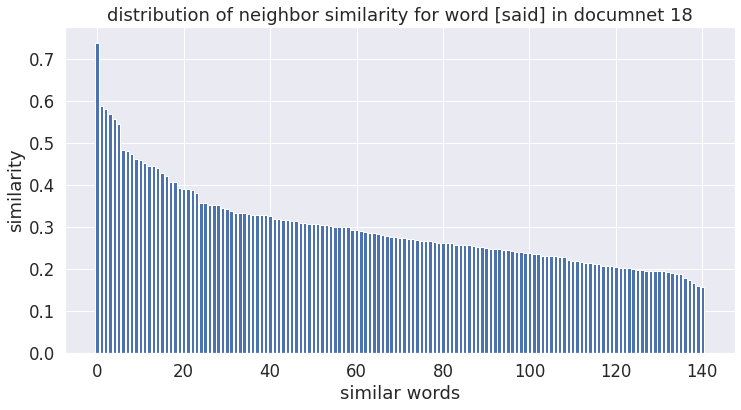

128   -->  basil
1738
[0.6295043, 0.6068193, 0.581912, 0.5661067, 0.5567499, 0.54128677, 0.51773894, 0.5121638, 0.49221802, 0.4738239, 0.46337944, 0.45356143, 0.45092076, 0.42871505, 0.40715936, 0.4011613, 0.39242762, 0.38152248, 0.38124597, 0.37897334, 0.3785314, 0.375315, 0.36915934, 0.35466164, 0.3524561, 0.3468042, 0.3454822, 0.34191138, 0.34086972, 0.33927113, 0.33863384, 0.3370652, 0.3370364, 0.33315122, 0.32910323, 0.32654333, 0.3235106, 0.3173815, 0.3134169, 0.31331277, 0.31254113, 0.31208688, 0.30957663, 0.30319872, 0.30222353, 0.3000018, 0.29753736, 0.29581648, 0.29255104, 0.29128316, 0.28952613, 0.28379118, 0.28362867, 0.28196168, 0.27904814, 0.27843925, 0.275334, 0.2752841, 0.27514815, 0.273731, 0.27299148, 0.26661187, 0.2659052, 0.26474312, 0.25892627, 0.25229645, 0.25106668, 0.24527454, 0.24339265, 0.24175844, 0.23817952, 0.23592016, 0.23524387, 0.23402697, 0.23120697, 0.23094809, 0.23047018, 0.229121, 0.22858188, 0.22807133, 0.22777703, 0.22711416, 0.22711296, 0.2255105,

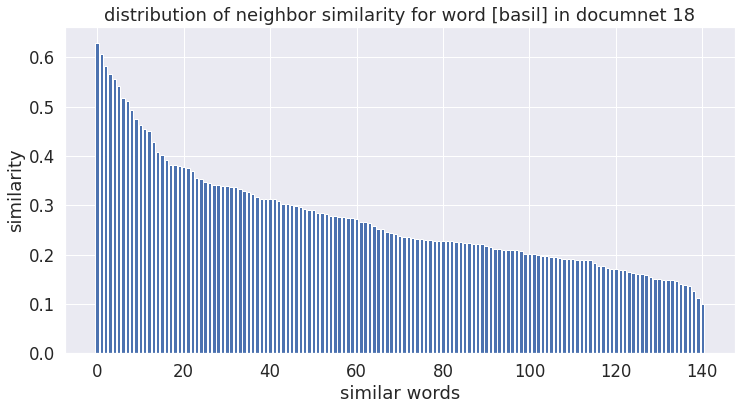

129   -->  papa
1738
[0.7503791, 0.7368579, 0.66415846, 0.64878756, 0.6395701, 0.54626083, 0.53278524, 0.530679, 0.501073, 0.4987011, 0.48266393, 0.4804482, 0.47328982, 0.46125507, 0.43814027, 0.43255335, 0.4268589, 0.42646343, 0.4254863, 0.41128194, 0.40696773, 0.40630668, 0.4058823, 0.39580515, 0.3852324, 0.3798936, 0.37731957, 0.37589222, 0.37548777, 0.37528792, 0.37189016, 0.3700577, 0.36766505, 0.3675628, 0.36744678, 0.36380273, 0.3594302, 0.35920513, 0.35851216, 0.35770625, 0.35618556, 0.35601228, 0.3548736, 0.34924197, 0.34687874, 0.3461995, 0.34398276, 0.34302706, 0.34268755, 0.34042132, 0.33968085, 0.3394958, 0.33948413, 0.33514577, 0.3348434, 0.33296806, 0.32973933, 0.32785982, 0.32687864, 0.32379967, 0.3236428, 0.32335907, 0.3221116, 0.3205859, 0.31968877, 0.3184028, 0.3172586, 0.31559628, 0.31517807, 0.31365806, 0.31245238, 0.3095126, 0.3085186, 0.3084095, 0.30419937, 0.3019497, 0.30191723, 0.3015933, 0.30089125, 0.30031863, 0.29862654, 0.29775962, 0.29643944, 0.29348516, 0

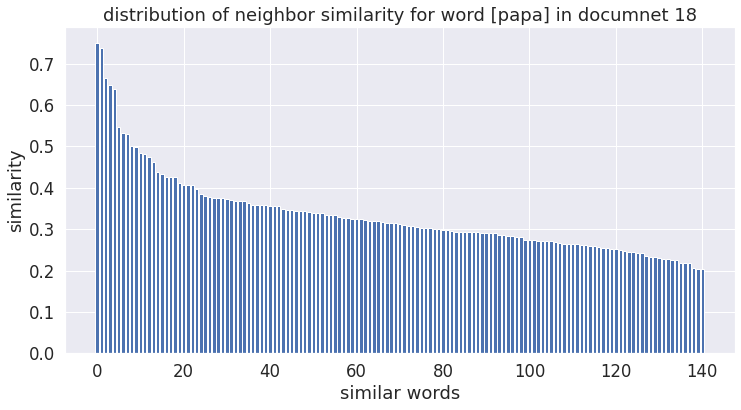

130   -->  ##christ
1738
[0.7677383, 0.72449285, 0.5930625, 0.5742068, 0.55975497, 0.51924884, 0.49734518, 0.4859317, 0.4745977, 0.4708041, 0.45857263, 0.44157523, 0.44027436, 0.42990032, 0.42443675, 0.4168956, 0.41146356, 0.40602705, 0.40594816, 0.40247923, 0.3823015, 0.373482, 0.3599493, 0.35826772, 0.35702485, 0.35538027, 0.35343757, 0.35259932, 0.3480684, 0.34255898, 0.34237415, 0.3412573, 0.33293104, 0.33180395, 0.3306039, 0.32752532, 0.32638127, 0.32501394, 0.32359937, 0.32307503, 0.32233334, 0.32228112, 0.32048333, 0.318857, 0.31639874, 0.3163749, 0.31550282, 0.31404373, 0.31155846, 0.31026262, 0.30951312, 0.3094946, 0.30597824, 0.30511767, 0.30451047, 0.30320066, 0.30318317, 0.30302677, 0.29996574, 0.2956326, 0.29219076, 0.2921102, 0.2915938, 0.29137295, 0.28966475, 0.2894863, 0.28941083, 0.2862494, 0.28440446, 0.28422493, 0.28326443, 0.28060353, 0.2805162, 0.27689517, 0.2759831, 0.27523366, 0.27429414, 0.27357453, 0.27333397, 0.2714006, 0.26731098, 0.2665049, 0.26621515, 0.264

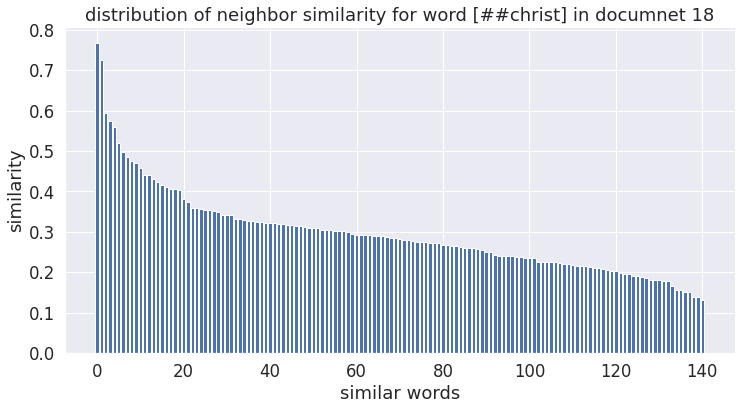

131   -->  ##idi
1738
[0.72002053, 0.71444345, 0.6059966, 0.5878912, 0.55364704, 0.5484926, 0.5317178, 0.51119924, 0.5055789, 0.4920109, 0.49032953, 0.487398, 0.47265404, 0.46968174, 0.4596314, 0.45362473, 0.4518502, 0.44758558, 0.44453835, 0.44437212, 0.44386876, 0.43875098, 0.43617836, 0.43533126, 0.4300747, 0.4256269, 0.42369813, 0.41900665, 0.41897014, 0.40819135, 0.404786, 0.40427342, 0.39952564, 0.39795858, 0.39795327, 0.39625594, 0.39280978, 0.3925759, 0.38862517, 0.38809365, 0.38735223, 0.3857895, 0.385733, 0.37933, 0.37889212, 0.37624812, 0.37599084, 0.37177116, 0.36381277, 0.36103153, 0.3600281, 0.35900962, 0.35848993, 0.3565991, 0.35375622, 0.35157976, 0.34837496, 0.34803522, 0.34669286, 0.34460306, 0.34171405, 0.3416223, 0.34067318, 0.33963057, 0.3383389, 0.33779627, 0.3363946, 0.33583143, 0.33268815, 0.3294031, 0.32457143, 0.32324958, 0.32279718, 0.3223884, 0.32135713, 0.32103902, 0.3186626, 0.31861782, 0.31786412, 0.31706542, 0.3156501, 0.31006798, 0.30795652, 0.30730796,

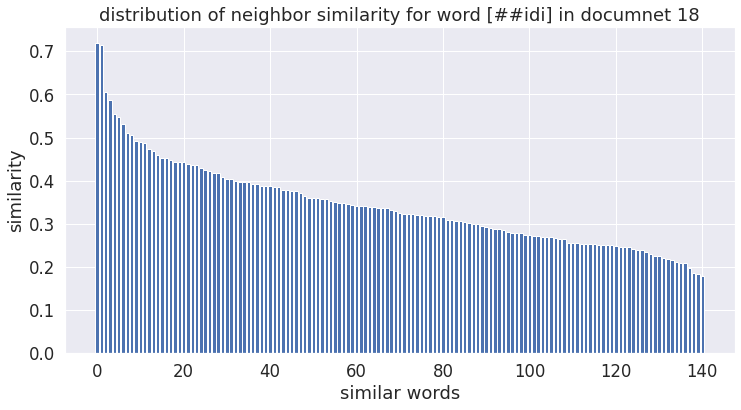

132   -->  ##s
1738
[0.68519986, 0.67818063, 0.6310579, 0.62219846, 0.596502, 0.57218796, 0.5341379, 0.51826966, 0.5148208, 0.4992748, 0.49671823, 0.44311297, 0.4405319, 0.42371905, 0.4087203, 0.3991593, 0.39721847, 0.3718108, 0.3668307, 0.36588737, 0.36492726, 0.36317885, 0.36215633, 0.3585059, 0.3562798, 0.35576338, 0.3510955, 0.3496399, 0.34871674, 0.34650886, 0.34088477, 0.33843145, 0.33713984, 0.33666486, 0.3364762, 0.33504754, 0.33170596, 0.33101034, 0.32783735, 0.3262757, 0.32439, 0.3220109, 0.3193869, 0.31903023, 0.31669563, 0.31535357, 0.30880836, 0.30785, 0.30765066, 0.30679092, 0.3067196, 0.3054796, 0.3050535, 0.3038214, 0.30371854, 0.302816, 0.30164018, 0.30105755, 0.30013114, 0.29836142, 0.29722732, 0.29701602, 0.29374284, 0.28938353, 0.2893662, 0.28934148, 0.2888545, 0.2865866, 0.2852605, 0.28213936, 0.2818057, 0.28177232, 0.27981824, 0.2788338, 0.27807027, 0.27790827, 0.276027, 0.2755225, 0.27493188, 0.2744308, 0.27390876, 0.27313593, 0.2730196, 0.27269873, 0.27123076, 0

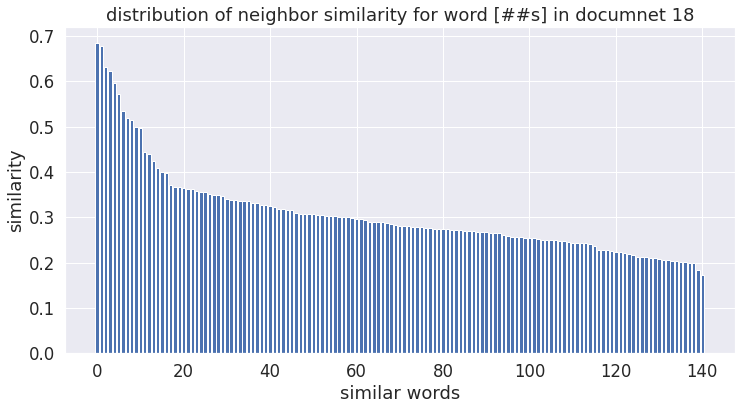

135   -->  chairman
1738
[0.73432064, 0.7041991, 0.64353466, 0.6065398, 0.5914091, 0.5864357, 0.581912, 0.5523125, 0.54617745, 0.51665163, 0.4918212, 0.4676004, 0.4641384, 0.45946658, 0.45899642, 0.45750237, 0.42459825, 0.41311866, 0.41093552, 0.40132707, 0.398907, 0.39753398, 0.39574927, 0.39508316, 0.39432, 0.38794905, 0.37638134, 0.3728577, 0.37177253, 0.36929125, 0.3681694, 0.36697036, 0.3624674, 0.36108392, 0.35996735, 0.35454428, 0.3527934, 0.35153556, 0.3507015, 0.34444073, 0.34296533, 0.34202844, 0.34196508, 0.34020197, 0.33976996, 0.33873358, 0.33864668, 0.33840415, 0.33558887, 0.33538747, 0.33536103, 0.33470476, 0.33136588, 0.33071718, 0.32958668, 0.328959, 0.32777178, 0.3233242, 0.32274562, 0.3225733, 0.32052657, 0.3191958, 0.31909385, 0.31872016, 0.31750864, 0.31709558, 0.3120247, 0.30869687, 0.30566126, 0.30553117, 0.30456126, 0.3016102, 0.30086893, 0.30058593, 0.30013588, 0.29970962, 0.2985893, 0.2972027, 0.29510182, 0.29483354, 0.29411265, 0.29317686, 0.2930175, 0.290705

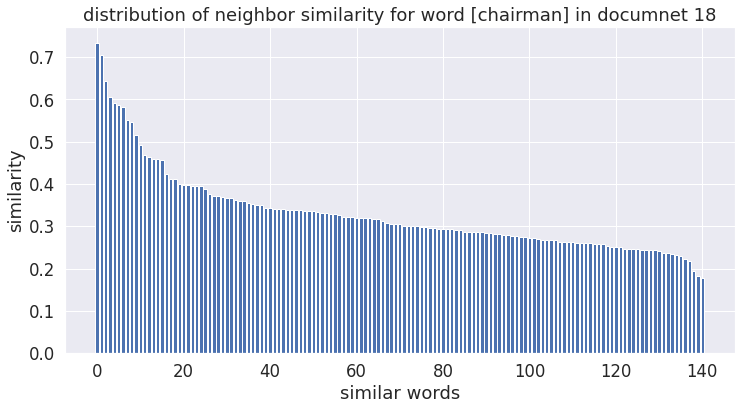

137   -->  papa
1738
[0.82936144, 0.76238346, 0.6424215, 0.62916493, 0.5661067, 0.539186, 0.5320207, 0.51665163, 0.5153083, 0.51445067, 0.4893726, 0.47524363, 0.47213146, 0.46884868, 0.46164304, 0.45330074, 0.45040458, 0.44513118, 0.44213432, 0.41637146, 0.40447077, 0.40410942, 0.40394735, 0.3979094, 0.39752766, 0.39063534, 0.38975844, 0.3895582, 0.3875129, 0.37827384, 0.377952, 0.37710154, 0.3763665, 0.37485588, 0.37284404, 0.37221423, 0.3665709, 0.3656755, 0.3628983, 0.35910028, 0.35821024, 0.3563897, 0.35563117, 0.35478044, 0.35349625, 0.3508011, 0.35008073, 0.34867653, 0.34818074, 0.34792536, 0.34778678, 0.34370267, 0.34141153, 0.34012008, 0.33994925, 0.33829615, 0.33822736, 0.337963, 0.33681422, 0.33664244, 0.33653274, 0.33629394, 0.3332921, 0.3314292, 0.32983774, 0.32947165, 0.32837713, 0.3254521, 0.32514185, 0.3246314, 0.32452488, 0.3234176, 0.32262242, 0.32064003, 0.3203413, 0.3168221, 0.3151881, 0.3148029, 0.31455335, 0.3127957, 0.3117996, 0.30972964, 0.30501807, 0.3042277, 0.

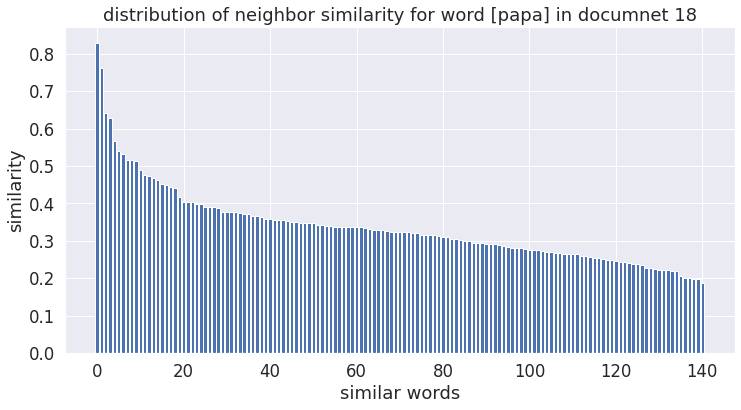

138   -->  ##christ
1738
[0.82936144, 0.7619703, 0.59445333, 0.5851847, 0.51782, 0.5121638, 0.5079933, 0.5019924, 0.49738696, 0.48014238, 0.45916712, 0.45750237, 0.45656508, 0.4522875, 0.44534287, 0.44079146, 0.42610523, 0.42228553, 0.41144046, 0.39272553, 0.39134696, 0.3846562, 0.37940657, 0.36965814, 0.36288413, 0.3627174, 0.36268896, 0.36076623, 0.3522535, 0.3517812, 0.34811527, 0.34721112, 0.34673917, 0.34578818, 0.34368628, 0.34138167, 0.34029973, 0.33957392, 0.3391782, 0.33689624, 0.33584648, 0.33300632, 0.33258867, 0.32893628, 0.32748967, 0.325329, 0.3241901, 0.32418525, 0.32373375, 0.32315734, 0.31945366, 0.316686, 0.3160625, 0.3153112, 0.31516916, 0.31416285, 0.31170613, 0.3112172, 0.30833626, 0.30669785, 0.30074716, 0.2993474, 0.29844856, 0.29643664, 0.29467744, 0.29464903, 0.29417664, 0.29410693, 0.29030108, 0.29028577, 0.2899177, 0.28807563, 0.28785133, 0.28631, 0.28495845, 0.28233707, 0.2795734, 0.27828407, 0.27791762, 0.2768969, 0.27649128, 0.27647376, 0.27595514, 0.27462

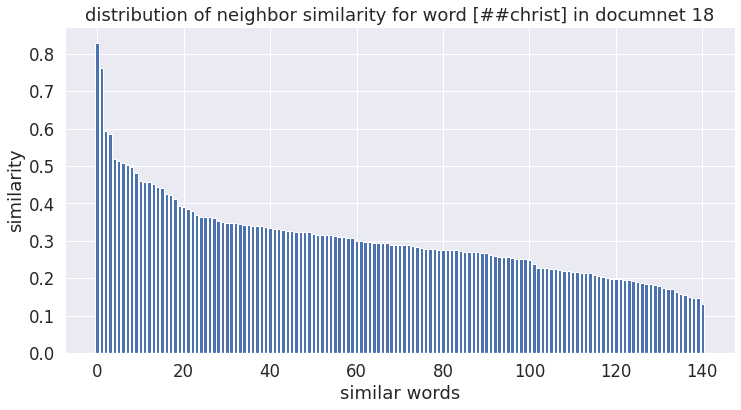

139   -->  ##idi
1738
[0.76238346, 0.7619703, 0.64402044, 0.59970367, 0.5567734, 0.53882384, 0.5255041, 0.52019346, 0.50418496, 0.4979323, 0.49221802, 0.4918212, 0.48312545, 0.4734429, 0.4595414, 0.45823365, 0.45516366, 0.45198768, 0.44605964, 0.44088808, 0.42975926, 0.4282261, 0.4263624, 0.41703343, 0.40844518, 0.4065377, 0.40616202, 0.4041971, 0.39986163, 0.39468563, 0.39031604, 0.3899131, 0.38829875, 0.388278, 0.38745773, 0.3863119, 0.38608634, 0.3857826, 0.38503933, 0.3842035, 0.3840881, 0.38401002, 0.38384232, 0.3807035, 0.3778699, 0.37756118, 0.37698063, 0.37668902, 0.37579924, 0.37344387, 0.36790192, 0.3663799, 0.36481845, 0.36340338, 0.36171678, 0.3602628, 0.35715735, 0.35359734, 0.3523387, 0.3512182, 0.35120624, 0.35088992, 0.34929258, 0.34925222, 0.34900594, 0.34897894, 0.34743917, 0.3473089, 0.34489048, 0.34262764, 0.34000075, 0.3396842, 0.33925796, 0.3347801, 0.33353013, 0.32887614, 0.32609832, 0.32512814, 0.3218962, 0.32150298, 0.3214594, 0.3175397, 0.31549555, 0.31185818,

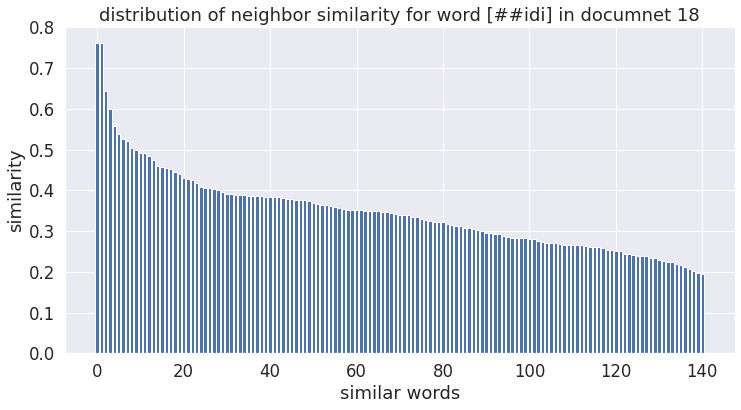

140   -->  ##s
1738
[0.7016213, 0.69026726, 0.6726104, 0.64554065, 0.62491876, 0.5975446, 0.57276344, 0.55804026, 0.5442443, 0.5002051, 0.4736418, 0.4686528, 0.46172023, 0.4413512, 0.43952817, 0.43647432, 0.4359283, 0.418288, 0.4170589, 0.41519874, 0.41217047, 0.40539578, 0.38772553, 0.3826155, 0.3708248, 0.37079933, 0.37037778, 0.367915, 0.3621366, 0.36195657, 0.36096916, 0.35998774, 0.35977694, 0.3561374, 0.3561184, 0.3551504, 0.35456958, 0.35421002, 0.35175636, 0.35115615, 0.35039866, 0.34955084, 0.34814167, 0.34606758, 0.34571323, 0.34568858, 0.34533757, 0.34474865, 0.343538, 0.3416019, 0.34121573, 0.34014988, 0.33929297, 0.33916137, 0.33735228, 0.33723637, 0.33686477, 0.3367563, 0.33643544, 0.33618867, 0.33506632, 0.33464026, 0.33277893, 0.33263475, 0.3326319, 0.33215106, 0.331959, 0.3315202, 0.32972407, 0.32744625, 0.32732028, 0.3270849, 0.3268402, 0.32599473, 0.32519746, 0.32500505, 0.32185626, 0.3204393, 0.31836015, 0.31823114, 0.31577152, 0.3154462, 0.31535107, 0.3134577, 0.31

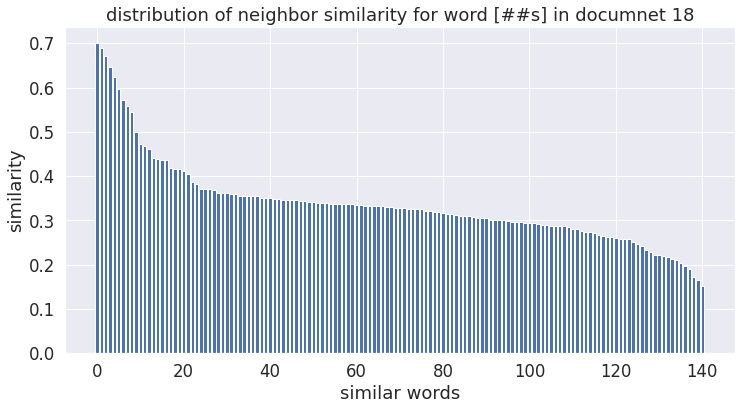

141   -->  ltd
1738
[0.7359457, 0.7041991, 0.6915164, 0.64402044, 0.6424215, 0.5999856, 0.59477144, 0.59445333, 0.5939677, 0.5452938, 0.54128677, 0.53519547, 0.478238, 0.47120705, 0.46574354, 0.4621657, 0.42547426, 0.41879028, 0.41842845, 0.41216838, 0.40370542, 0.40161932, 0.4015638, 0.4013188, 0.3972448, 0.39296705, 0.39285684, 0.39178836, 0.39021325, 0.3880308, 0.38544908, 0.3747682, 0.37433589, 0.36402947, 0.3639751, 0.36244732, 0.35442382, 0.3532313, 0.3516421, 0.35036528, 0.3503404, 0.3466062, 0.34570032, 0.34355226, 0.3435242, 0.34294575, 0.34056935, 0.3400827, 0.33973366, 0.337682, 0.33675236, 0.33352447, 0.33173865, 0.33153617, 0.33089414, 0.3303794, 0.33017784, 0.3268537, 0.32593232, 0.3226596, 0.32251468, 0.3222177, 0.32174402, 0.32146192, 0.3211728, 0.31977472, 0.31526983, 0.31336364, 0.3125211, 0.31244993, 0.31185266, 0.31102368, 0.30901945, 0.30880445, 0.30831027, 0.3049158, 0.3048197, 0.30286664, 0.30230123, 0.30228186, 0.3018288, 0.29972845, 0.29920572, 0.29887354, 0.29

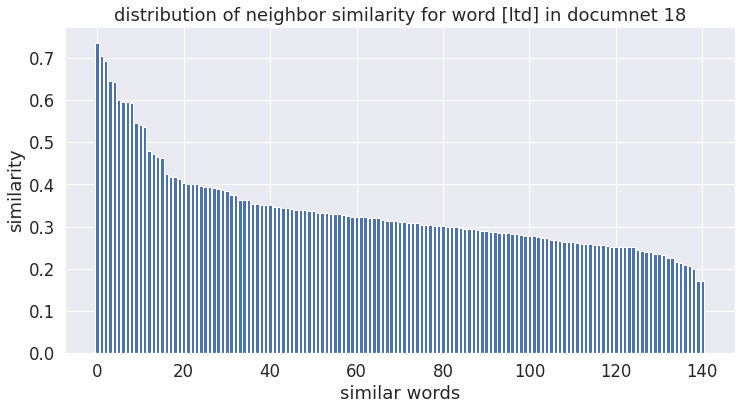

145   -->  major
1738
[0.76351136, 0.7420261, 0.6687782, 0.64353466, 0.63506866, 0.59477144, 0.51773894, 0.46984458, 0.46884868, 0.4625575, 0.4511474, 0.44088808, 0.42368457, 0.42228553, 0.41304597, 0.39968187, 0.39710316, 0.39367858, 0.38168544, 0.38014364, 0.38010007, 0.37252486, 0.3716643, 0.37002096, 0.3563339, 0.35316303, 0.35072336, 0.34329355, 0.34252423, 0.338894, 0.3386069, 0.33611944, 0.33371055, 0.33363163, 0.33282238, 0.33188504, 0.33004087, 0.32571518, 0.32261974, 0.32161686, 0.32152414, 0.31866938, 0.31859088, 0.3185239, 0.31828856, 0.31747884, 0.3164999, 0.31545484, 0.31447738, 0.3136328, 0.31090176, 0.30406177, 0.30319786, 0.3025367, 0.30223498, 0.3017856, 0.30141833, 0.3013832, 0.300817, 0.3008121, 0.29946375, 0.29924732, 0.29725775, 0.29712158, 0.29683205, 0.29585403, 0.2948742, 0.2942654, 0.29360577, 0.29028553, 0.28841344, 0.28753617, 0.28721642, 0.28698868, 0.28669548, 0.28545985, 0.2854581, 0.2847615, 0.28282732, 0.28119045, 0.28018114, 0.27966204, 0.27917475, 0.2

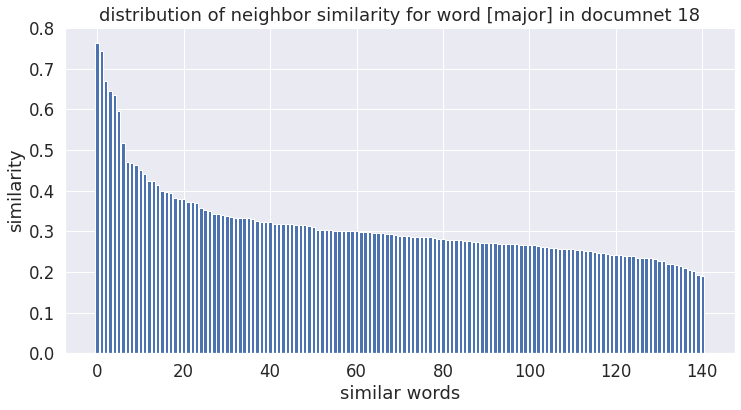

146   -->  shipping
1738
[0.76351136, 0.75254506, 0.6049986, 0.5999856, 0.59810543, 0.5748274, 0.54617745, 0.54115975, 0.5320207, 0.52019346, 0.51676565, 0.49738696, 0.48428804, 0.47567517, 0.4620365, 0.46118945, 0.45356143, 0.4422849, 0.43143618, 0.42174017, 0.40966916, 0.40656626, 0.3952847, 0.39400834, 0.3939845, 0.39320257, 0.3874491, 0.38199502, 0.3799889, 0.37930593, 0.37632412, 0.37211338, 0.3677761, 0.3592799, 0.3585412, 0.35809314, 0.35563076, 0.35454524, 0.34870398, 0.34729323, 0.34721133, 0.3470971, 0.3460911, 0.34573334, 0.33999476, 0.3389436, 0.33653942, 0.33593947, 0.33216932, 0.33118135, 0.33094755, 0.33020517, 0.33003494, 0.32890797, 0.32546675, 0.32504836, 0.32500628, 0.32337007, 0.3229069, 0.32223368, 0.32108527, 0.31947243, 0.31933653, 0.31882706, 0.318587, 0.31728113, 0.31636405, 0.31615832, 0.3140058, 0.3133222, 0.31051284, 0.31036222, 0.30810425, 0.3051474, 0.30491924, 0.30426407, 0.30280954, 0.30244046, 0.30240515, 0.302114, 0.30159146, 0.2992773, 0.29899937, 0.2

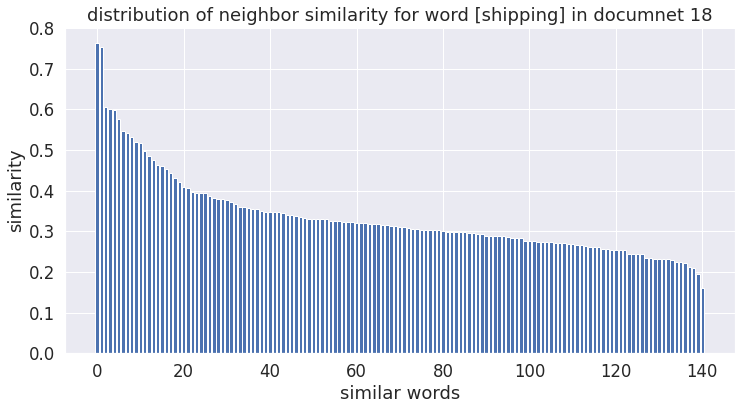

147   -->  company
1738
[0.75254506, 0.7420261, 0.7359457, 0.73432064, 0.68416095, 0.60715497, 0.539186, 0.50418496, 0.48331317, 0.4823274, 0.47843584, 0.46790257, 0.45997608, 0.45916712, 0.4543993, 0.45263034, 0.44950426, 0.4460503, 0.4431137, 0.43214148, 0.42871505, 0.42062762, 0.4184494, 0.41463968, 0.40985548, 0.40530038, 0.40469277, 0.40257156, 0.3989446, 0.39708945, 0.39480197, 0.3910521, 0.39088202, 0.38784474, 0.3863405, 0.38409156, 0.38002276, 0.3788206, 0.37848336, 0.3783422, 0.37463266, 0.37422568, 0.37290573, 0.37235087, 0.37178582, 0.36988828, 0.36858568, 0.36652023, 0.3650142, 0.36462075, 0.36313033, 0.36265597, 0.36253047, 0.3622668, 0.35856858, 0.35765344, 0.35612828, 0.35591137, 0.35316014, 0.3518579, 0.34687603, 0.3458324, 0.34286356, 0.34270447, 0.34000528, 0.33966273, 0.33914372, 0.33842444, 0.33823073, 0.33722192, 0.33624867, 0.33500826, 0.33330417, 0.3332994, 0.3308916, 0.33006948, 0.32714114, 0.32661015, 0.3254735, 0.32453495, 0.32346365, 0.32294685, 0.32259, 0.3

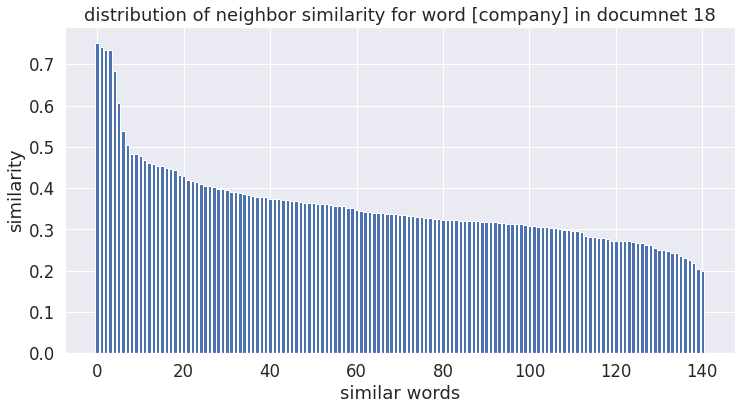

149   -->  london
1738
[0.6915164, 0.63506866, 0.62916493, 0.62500364, 0.61300474, 0.60715497, 0.6068193, 0.6065398, 0.59970367, 0.59810543, 0.5851847, 0.5799205, 0.5247664, 0.47087276, 0.46265233, 0.4504006, 0.43985373, 0.43354237, 0.42759794, 0.4244315, 0.4136626, 0.41119546, 0.40459734, 0.39230588, 0.38688576, 0.38577357, 0.38124067, 0.3767069, 0.3744205, 0.37065133, 0.36925817, 0.36739945, 0.36674473, 0.36564732, 0.36369455, 0.3634013, 0.3607537, 0.35206428, 0.35029453, 0.34748948, 0.3469162, 0.3444155, 0.34357134, 0.34342283, 0.34285548, 0.3427086, 0.33978203, 0.336843, 0.3341516, 0.3335284, 0.33272812, 0.3326537, 0.32590246, 0.32385123, 0.32335025, 0.32306492, 0.31971604, 0.31958866, 0.31904107, 0.31818354, 0.3148945, 0.3094691, 0.3091545, 0.30821282, 0.30716273, 0.30613124, 0.3055371, 0.30181015, 0.3006035, 0.2946081, 0.2942414, 0.29071885, 0.28983942, 0.28843224, 0.28707302, 0.28597984, 0.2839917, 0.2807715, 0.2805575, 0.27966252, 0.27736974, 0.27663782, 0.27376235, 0.2732022, 

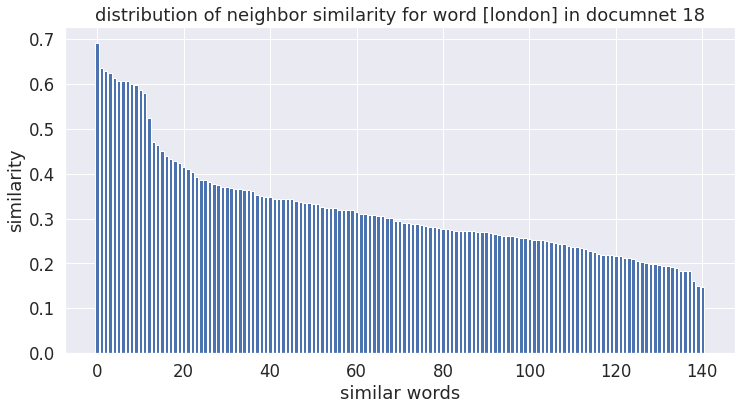

151   -->  recalling
1738
[0.7854185, 0.5603864, 0.55321956, 0.5341516, 0.5263448, 0.5059694, 0.49222127, 0.48523122, 0.4836622, 0.47335547, 0.46788323, 0.467292, 0.45364076, 0.45172125, 0.45092076, 0.44059145, 0.43958116, 0.4287447, 0.4240201, 0.42249107, 0.41966245, 0.41694504, 0.41368562, 0.4135695, 0.4131915, 0.41124046, 0.4101901, 0.40851113, 0.40795362, 0.40206754, 0.39986163, 0.39891392, 0.3964121, 0.39568228, 0.39432, 0.3937092, 0.39353895, 0.39230588, 0.390868, 0.38380036, 0.3828109, 0.38208073, 0.38128424, 0.3798704, 0.37696576, 0.37133604, 0.3711835, 0.36802137, 0.36778894, 0.36379215, 0.3563339, 0.35401517, 0.3533848, 0.35302454, 0.35249123, 0.35053834, 0.34784555, 0.3470971, 0.3458324, 0.34581965, 0.34141153, 0.34026968, 0.33910182, 0.33875275, 0.33696908, 0.33690855, 0.33584648, 0.33352447, 0.33152032, 0.32925636, 0.32666415, 0.32628024, 0.32563287, 0.3234293, 0.3192867, 0.3174786, 0.31622612, 0.31536147, 0.31465566, 0.31388414, 0.3104696, 0.30722246, 0.30547023, 0.305149

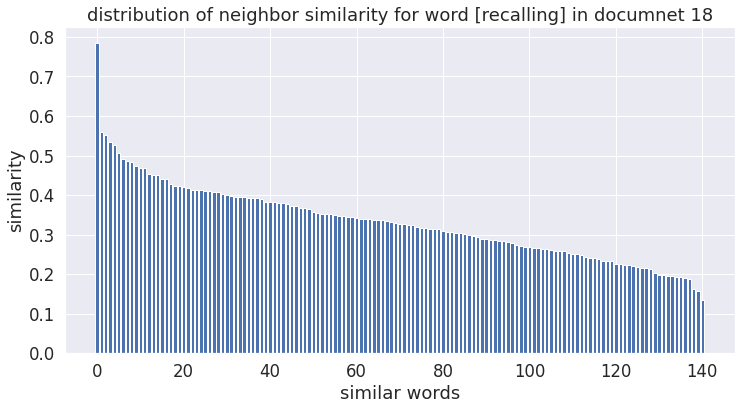

153   -->  mistake
1738
[0.6419363, 0.6346419, 0.62994075, 0.5831938, 0.5642182, 0.5416891, 0.5249698, 0.48855385, 0.48736337, 0.47207904, 0.46042764, 0.46006778, 0.4594996, 0.45024407, 0.45013952, 0.4455995, 0.44133717, 0.44126174, 0.43835342, 0.4377197, 0.43646818, 0.4351122, 0.43375444, 0.43244392, 0.42988014, 0.42906618, 0.4287522, 0.42737126, 0.4257453, 0.42246664, 0.41814888, 0.41728508, 0.41614428, 0.41566023, 0.41534758, 0.41388318, 0.41235295, 0.41104966, 0.4018303, 0.4014473, 0.40094155, 0.3972739, 0.393978, 0.38761503, 0.38725114, 0.38585424, 0.38425058, 0.38356292, 0.3833319, 0.38291055, 0.38278806, 0.38123462, 0.3763395, 0.37269127, 0.36880893, 0.3680092, 0.36459616, 0.362813, 0.36220756, 0.3618164, 0.36006075, 0.35952222, 0.35872656, 0.35829413, 0.35508808, 0.35371068, 0.35069382, 0.34987354, 0.34948662, 0.34917706, 0.34769148, 0.34728998, 0.34723207, 0.34685183, 0.34332937, 0.34204283, 0.34188604, 0.34113616, 0.33883768, 0.33747774, 0.3369491, 0.3359003, 0.334826, 0.3344

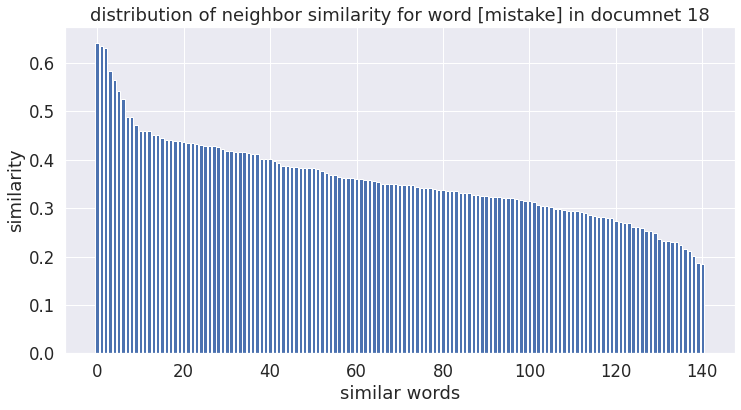

156   -->  past
1738
[0.62341964, 0.6135899, 0.6024009, 0.59806746, 0.5980107, 0.5844421, 0.5794642, 0.5702121, 0.5423222, 0.5283205, 0.52431023, 0.517601, 0.51681006, 0.5123753, 0.5014588, 0.48724765, 0.4861222, 0.4837529, 0.47903293, 0.47836384, 0.47443682, 0.473861, 0.4738436, 0.46736753, 0.46430004, 0.46080405, 0.45870522, 0.44800764, 0.44475177, 0.44459283, 0.43774813, 0.4362229, 0.4335241, 0.4307004, 0.42859858, 0.42378455, 0.42339033, 0.4227962, 0.4222198, 0.42162097, 0.42017764, 0.41538066, 0.412371, 0.40993136, 0.40689918, 0.40227255, 0.401989, 0.40192807, 0.399238, 0.3973657, 0.39705932, 0.39530706, 0.39436752, 0.3930946, 0.3914621, 0.39072317, 0.3905323, 0.38854575, 0.38714755, 0.38601893, 0.38352293, 0.38316742, 0.38248977, 0.38174286, 0.3801399, 0.37916863, 0.3747385, 0.37377602, 0.37081042, 0.3697129, 0.3692589, 0.36582708, 0.36503506, 0.36389893, 0.36323577, 0.36300695, 0.35799676, 0.3572082, 0.35576007, 0.35386696, 0.35129812, 0.3470739, 0.34455097, 0.34331998, 0.341994

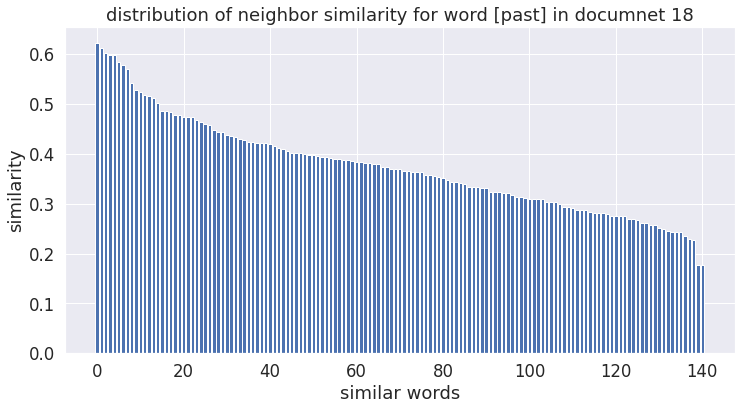

160   -->  number
1738
[0.77024734, 0.7380179, 0.5672983, 0.50807166, 0.49298203, 0.4909542, 0.4901213, 0.4686862, 0.467292, 0.45440376, 0.43935984, 0.43484622, 0.4249063, 0.42339134, 0.422692, 0.42243624, 0.4222843, 0.41914716, 0.41362578, 0.4084185, 0.39937666, 0.3986807, 0.39309993, 0.3916629, 0.39096594, 0.38949502, 0.3894832, 0.3863119, 0.3833854, 0.36858016, 0.36671168, 0.3645711, 0.3642034, 0.35745245, 0.35706747, 0.3553558, 0.35458237, 0.35454428, 0.35201296, 0.3518598, 0.34896395, 0.34871143, 0.34562212, 0.34481436, 0.34405145, 0.34303463, 0.34024304, 0.33802074, 0.337682, 0.33719337, 0.3353015, 0.33495644, 0.3318048, 0.33121145, 0.32772964, 0.32643312, 0.3261748, 0.32609606, 0.32545143, 0.32455492, 0.32335025, 0.32334572, 0.32329774, 0.32213187, 0.32165325, 0.31875455, 0.3168221, 0.31558445, 0.31493095, 0.31447738, 0.31316525, 0.31029838, 0.30999872, 0.30905384, 0.30847389, 0.30641142, 0.30311123, 0.2988783, 0.2940349, 0.29322106, 0.2928154, 0.28942004, 0.28631, 0.2849487, 0.

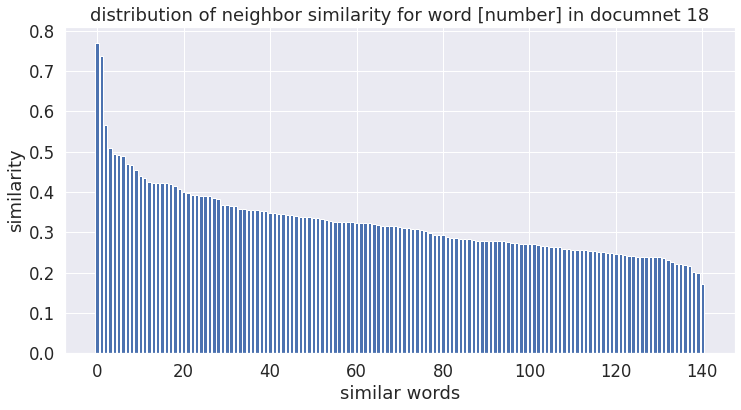

162   -->  reasons
1738
[0.77024734, 0.75806683, 0.5746437, 0.55321956, 0.54591775, 0.51823854, 0.5128805, 0.5117577, 0.48233145, 0.4686776, 0.46032208, 0.4534003, 0.44806722, 0.44632435, 0.44605964, 0.44434863, 0.44102645, 0.43786854, 0.4376151, 0.43606728, 0.43331635, 0.43067312, 0.42779398, 0.4162445, 0.41557738, 0.41350293, 0.41186383, 0.41142115, 0.41058743, 0.40022075, 0.398221, 0.39242762, 0.38649726, 0.3849554, 0.38185537, 0.37948138, 0.37940657, 0.377952, 0.37540895, 0.36925817, 0.36808634, 0.36656296, 0.36441207, 0.36121136, 0.35856652, 0.35442382, 0.35320413, 0.34907812, 0.34895563, 0.3440723, 0.3386773, 0.33651897, 0.33538747, 0.33455175, 0.32688275, 0.326794, 0.3263046, 0.32535645, 0.32484907, 0.32334825, 0.323048, 0.32250977, 0.3208548, 0.3195616, 0.31799394, 0.31704885, 0.31449693, 0.31385684, 0.3133222, 0.31323758, 0.30951595, 0.3074792, 0.30550092, 0.30355442, 0.3013832, 0.29843402, 0.29679158, 0.2967721, 0.29294866, 0.29232538, 0.29132122, 0.29081184, 0.28965786, 0.28

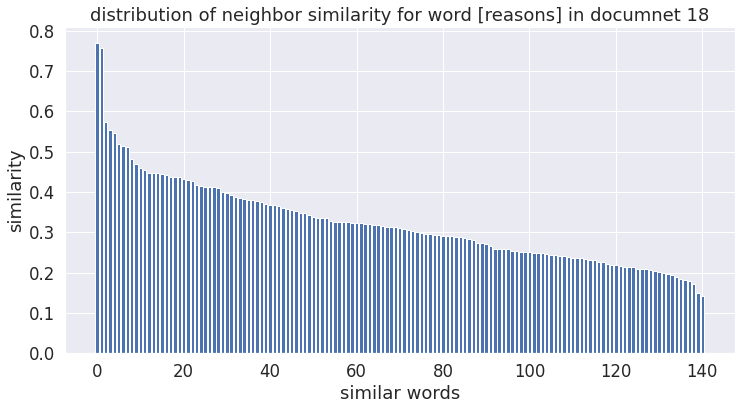

164   -->  ship
1738
[0.83641624, 0.67364407, 0.667872, 0.6549773, 0.6497823, 0.586712, 0.57196337, 0.56945217, 0.5630803, 0.55804765, 0.5567734, 0.5551847, 0.54935384, 0.54127026, 0.54115975, 0.5339741, 0.52877486, 0.52144456, 0.5166921, 0.5153083, 0.50953805, 0.5064389, 0.5060266, 0.5049789, 0.5022775, 0.5019924, 0.49529645, 0.4931843, 0.4875777, 0.48713017, 0.4866463, 0.4836622, 0.4796111, 0.47836778, 0.4773708, 0.47054082, 0.4699247, 0.4684386, 0.46574354, 0.46188673, 0.46032208, 0.4596219, 0.4585017, 0.45658746, 0.45647705, 0.45440376, 0.45263034, 0.45238706, 0.4504006, 0.44969368, 0.44700044, 0.44043058, 0.43772805, 0.43550327, 0.43454272, 0.42666203, 0.42252678, 0.4212972, 0.42084932, 0.42031503, 0.41700673, 0.4165793, 0.41469634, 0.41304597, 0.4126554, 0.40849167, 0.40657207, 0.40533972, 0.40210155, 0.40067, 0.39861476, 0.39676315, 0.39426255, 0.3934415, 0.39258683, 0.38603276, 0.38436344, 0.38374668, 0.38302264, 0.38283855, 0.38241905, 0.38157082, 0.38074493, 0.37849298, 0.376

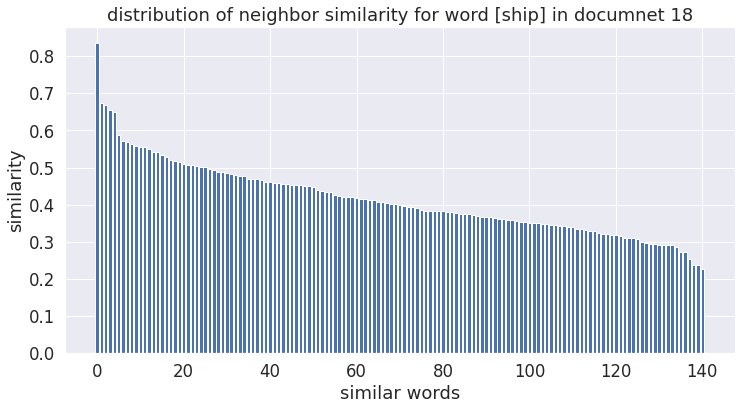

165   -->  ##own
1738
[0.83641624, 0.7245881, 0.6749631, 0.65241027, 0.6361109, 0.61441493, 0.6019089, 0.5916554, 0.5605688, 0.55933297, 0.5548132, 0.55222213, 0.54591775, 0.5458405, 0.53882384, 0.5341516, 0.5323516, 0.530017, 0.52861893, 0.5195398, 0.5141616, 0.51347053, 0.51028645, 0.50876796, 0.5079933, 0.50652564, 0.5022185, 0.5020106, 0.5012963, 0.49909014, 0.49705583, 0.49378186, 0.49283755, 0.4909542, 0.4893726, 0.48808944, 0.48671222, 0.48428804, 0.4823274, 0.48086607, 0.47919342, 0.4788705, 0.47379047, 0.47279465, 0.47131392, 0.46649048, 0.46608785, 0.46575904, 0.4621657, 0.46129826, 0.4592347, 0.4589851, 0.4507247, 0.4494359, 0.44860142, 0.44723886, 0.44252557, 0.4402816, 0.43471417, 0.43344605, 0.43105435, 0.42815423, 0.42759794, 0.4249305, 0.42094952, 0.41882774, 0.41850123, 0.41766962, 0.41636425, 0.41399556, 0.41390938, 0.41311866, 0.41097248, 0.40679282, 0.40673453, 0.4048781, 0.40222204, 0.40175542, 0.3987652, 0.39875156, 0.39347452, 0.39185575, 0.3905782, 0.3904084, 0.

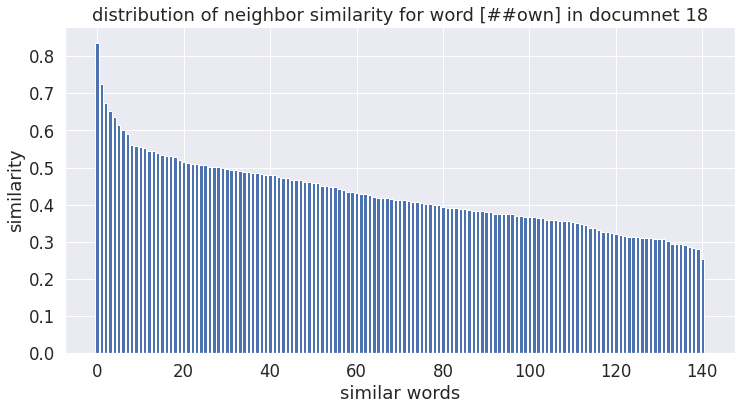

166   -->  ##ers
1738
[0.7528461, 0.6732394, 0.6683122, 0.6398784, 0.58824265, 0.5860692, 0.5819691, 0.57793796, 0.5535386, 0.5528659, 0.541955, 0.5250239, 0.5222107, 0.5142523, 0.50607735, 0.49250698, 0.49127734, 0.48854703, 0.48530445, 0.48193753, 0.4816954, 0.48076716, 0.46453425, 0.4627266, 0.4585667, 0.45548406, 0.4538865, 0.45321405, 0.45259023, 0.45165008, 0.45077917, 0.4489166, 0.44728106, 0.4466719, 0.44642553, 0.4463817, 0.44546804, 0.44490337, 0.44426706, 0.44295126, 0.43922666, 0.4388582, 0.43832886, 0.43807685, 0.43351254, 0.43255252, 0.42930293, 0.42773598, 0.42578742, 0.42509815, 0.4240497, 0.4219825, 0.41872597, 0.4176749, 0.4166578, 0.41631094, 0.41511646, 0.4132116, 0.4129089, 0.4057996, 0.4053929, 0.40370268, 0.40111762, 0.3976078, 0.39565748, 0.39400873, 0.39017224, 0.38892126, 0.3879365, 0.38628265, 0.3861894, 0.38579226, 0.3848378, 0.37537587, 0.37081182, 0.36720115, 0.36523765, 0.3640594, 0.36242342, 0.35836774, 0.35835192, 0.35769016, 0.35508287, 0.35415065, 0.3

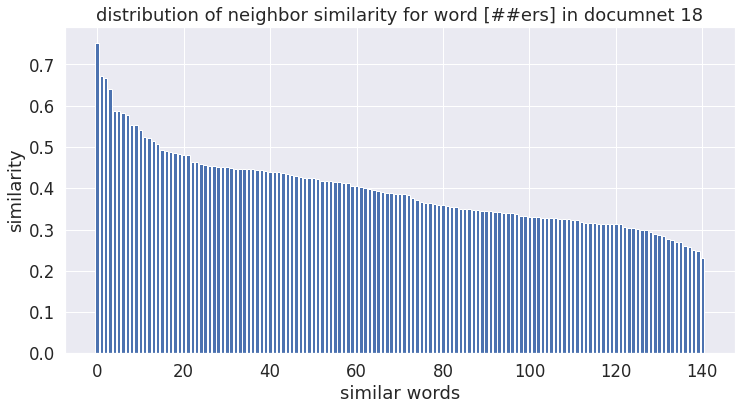

167   -->  worry
1738
[0.7166722, 0.61441493, 0.5746437, 0.5672983, 0.5470072, 0.5339741, 0.51375854, 0.5090758, 0.50648427, 0.50315213, 0.49475005, 0.492063, 0.4834279, 0.48115116, 0.46476635, 0.4586944, 0.45636702, 0.45246443, 0.45172125, 0.45042312, 0.45036995, 0.44483006, 0.44083744, 0.43198252, 0.42879653, 0.42692405, 0.42357767, 0.41804463, 0.40945092, 0.40732735, 0.40380806, 0.4037181, 0.40106994, 0.4001124, 0.39753398, 0.3972536, 0.39407286, 0.3938839, 0.39155135, 0.3906945, 0.38796288, 0.3878557, 0.38422084, 0.38075936, 0.38038492, 0.3763665, 0.37485358, 0.37474713, 0.37149495, 0.37076536, 0.37065133, 0.37007117, 0.36988828, 0.36828148, 0.3671942, 0.3663799, 0.3639751, 0.3605336, 0.3599685, 0.35889637, 0.35865074, 0.35817128, 0.35450375, 0.35313612, 0.35277775, 0.35259432, 0.35166925, 0.35114896, 0.3507416, 0.3453395, 0.3442446, 0.34368628, 0.34203056, 0.34200162, 0.34048104, 0.34019622, 0.3381989, 0.33812287, 0.3341169, 0.33399773, 0.3311929, 0.3275216, 0.3252547, 0.32250437,

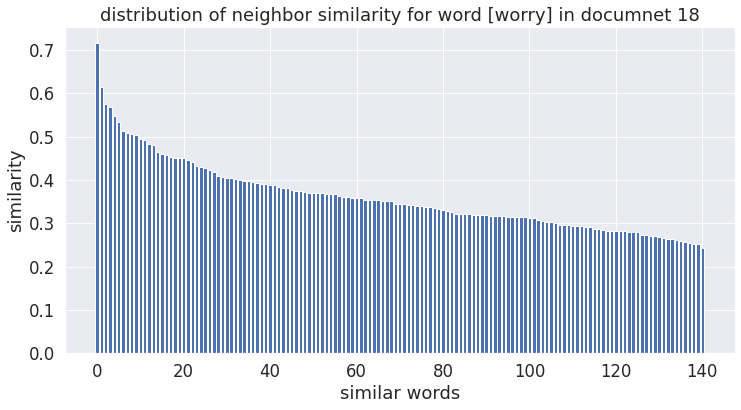

169   -->  repeating
1738
[0.7854185, 0.72814703, 0.6456473, 0.6361109, 0.61376905, 0.6089401, 0.5779153, 0.56945217, 0.5450334, 0.51823854, 0.5160034, 0.51375854, 0.50770974, 0.5057422, 0.5002722, 0.49720186, 0.49298203, 0.48005426, 0.47662225, 0.46394235, 0.45800823, 0.4573906, 0.45186615, 0.45112318, 0.4500628, 0.44868088, 0.44552636, 0.44149077, 0.4398985, 0.43726975, 0.43510604, 0.43158075, 0.42950356, 0.42924064, 0.4282844, 0.4263624, 0.42039585, 0.420312, 0.41825354, 0.41820502, 0.41747236, 0.4167086, 0.41555852, 0.4129937, 0.41297087, 0.41253644, 0.4117399, 0.40983924, 0.40641308, 0.40394077, 0.4036784, 0.40306264, 0.40257156, 0.40242404, 0.4019373, 0.40159422, 0.39891112, 0.39739418, 0.39575553, 0.3951351, 0.38975844, 0.38969135, 0.38886923, 0.38869894, 0.38794905, 0.38766652, 0.38742253, 0.3867637, 0.38613775, 0.38599432, 0.38577357, 0.38544908, 0.38476124, 0.3845271, 0.3840809, 0.38311192, 0.38238326, 0.3820231, 0.38125622, 0.3804018, 0.37928313, 0.37698454, 0.37633753, 0.37

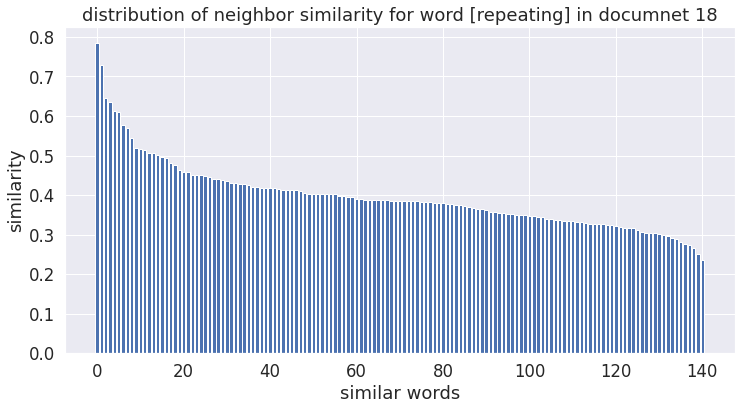

171   -->  mistake
1738
[0.72814703, 0.72741437, 0.6723037, 0.5603864, 0.55395925, 0.5305976, 0.51347053, 0.5090758, 0.49931577, 0.49529645, 0.4901213, 0.47295022, 0.4686776, 0.46646664, 0.46630013, 0.46005642, 0.4551644, 0.45264816, 0.45105088, 0.44982928, 0.44338524, 0.43624014, 0.43332353, 0.43309176, 0.4278927, 0.42666245, 0.41933712, 0.41874674, 0.41745102, 0.4139812, 0.4138392, 0.41356918, 0.40756252, 0.4051226, 0.4043584, 0.4032095, 0.40178066, 0.40090132, 0.39919806, 0.39776453, 0.39550248, 0.3950786, 0.3932637, 0.3921064, 0.39172843, 0.39041054, 0.38906622, 0.38780105, 0.38667786, 0.38581952, 0.3821286, 0.38013703, 0.37993953, 0.3796097, 0.3788206, 0.37749076, 0.37668902, 0.37656394, 0.37542522, 0.37230474, 0.37178016, 0.37089813, 0.36771083, 0.36620417, 0.36586463, 0.3632742, 0.36326966, 0.36302897, 0.36129355, 0.36124197, 0.36048168, 0.35821024, 0.35696456, 0.35655028, 0.35579458, 0.3547359, 0.35084727, 0.35031438, 0.34990388, 0.34905678, 0.34814483, 0.3468139, 0.3459245, 0.

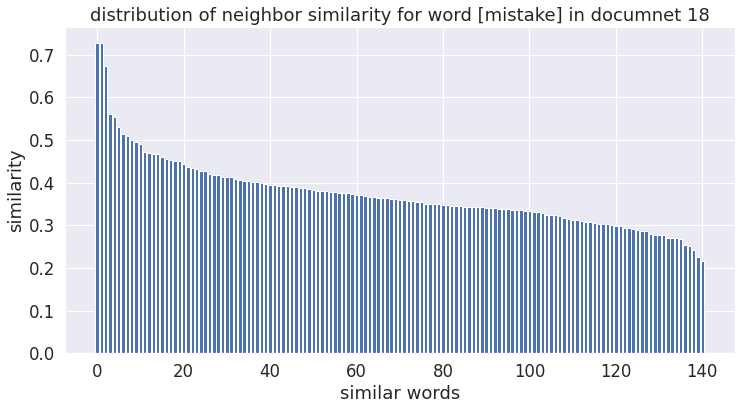

174   -->  past
1738
[0.6723037, 0.61376905, 0.58365315, 0.5605688, 0.5551847, 0.5059694, 0.5050849, 0.49582654, 0.49538344, 0.49472037, 0.48727256, 0.4834279, 0.47281265, 0.47212723, 0.46741164, 0.46265233, 0.46249095, 0.45969415, 0.45697993, 0.45553643, 0.4549919, 0.45453045, 0.4503827, 0.44874752, 0.44220102, 0.44213432, 0.43606728, 0.4332075, 0.43315774, 0.4318571, 0.4282261, 0.42695498, 0.42610523, 0.4213361, 0.41965225, 0.41873673, 0.41780007, 0.4159737, 0.41540715, 0.41362578, 0.41093552, 0.40718687, 0.4047948, 0.40464276, 0.4013188, 0.40055376, 0.39923996, 0.39882976, 0.3980397, 0.39710316, 0.3963421, 0.3939845, 0.3934258, 0.3902312, 0.38784474, 0.386761, 0.38329017, 0.3832221, 0.38124597, 0.37993225, 0.37525162, 0.37503964, 0.3749773, 0.37496552, 0.3730859, 0.37066346, 0.37058118, 0.36925313, 0.36776567, 0.36759633, 0.3650554, 0.36350027, 0.3625238, 0.35881758, 0.35863048, 0.35788685, 0.3574069, 0.35714144, 0.35699844, 0.3567511, 0.3567222, 0.35625327, 0.35295266, 0.35168126, 

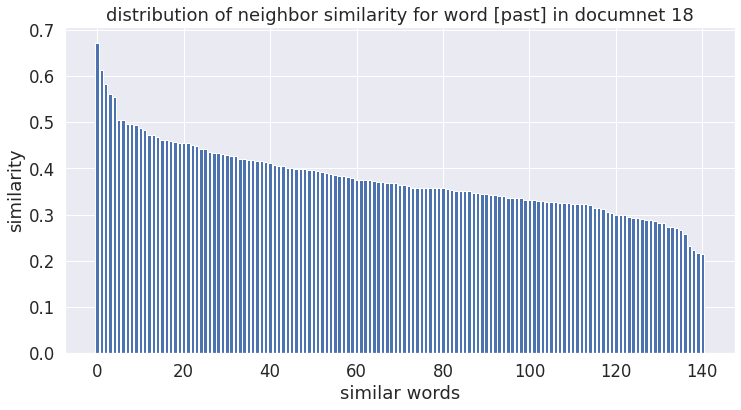

176   -->  ordering
1738
[0.67364407, 0.65241027, 0.60910845, 0.6084175, 0.6016017, 0.59227496, 0.58229125, 0.5779153, 0.5645524, 0.5431097, 0.5263448, 0.5256072, 0.5234914, 0.521127, 0.5197011, 0.5195259, 0.50792587, 0.5036149, 0.49931577, 0.4985667, 0.49582654, 0.4913782, 0.49091387, 0.48677328, 0.48560768, 0.4828626, 0.468489, 0.468477, 0.46747056, 0.467236, 0.46660823, 0.4635294, 0.46225888, 0.4589194, 0.45728078, 0.45271114, 0.45221406, 0.45071837, 0.44821683, 0.4479065, 0.44582182, 0.44387543, 0.44241348, 0.43801767, 0.4377542, 0.4376151, 0.4345914, 0.43271232, 0.42920777, 0.42879492, 0.42876709, 0.42829987, 0.42711294, 0.426098, 0.42298895, 0.42216063, 0.42098042, 0.41945854, 0.4192779, 0.41579783, 0.41402134, 0.41388127, 0.4134591, 0.40817133, 0.40732735, 0.40656626, 0.40626955, 0.40527937, 0.40362275, 0.40119153, 0.3975632, 0.3964171, 0.39592546, 0.3956316, 0.39157143, 0.39147818, 0.38401002, 0.37981868, 0.3791624, 0.37819514, 0.3776505, 0.37520406, 0.3732417, 0.37070107, 0.37

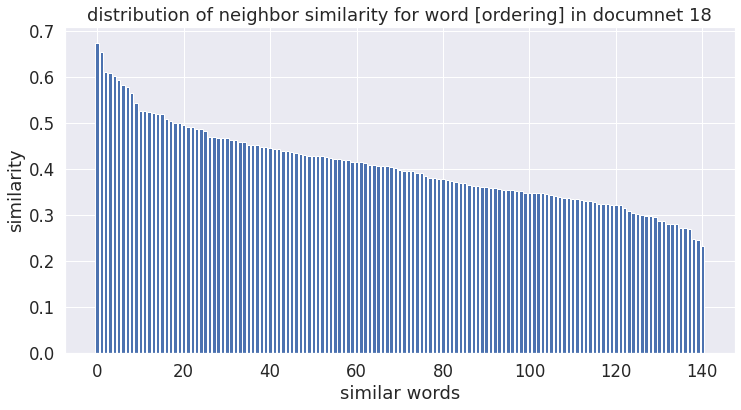

177   -->  new
1738
[0.70723486, 0.6903253, 0.6874894, 0.6671716, 0.6571411, 0.6405724, 0.6222646, 0.6172654, 0.61035895, 0.5897082, 0.5888365, 0.5874088, 0.5865921, 0.5827701, 0.5813162, 0.58031714, 0.5797503, 0.57241106, 0.5671366, 0.5640014, 0.5572842, 0.551728, 0.5503435, 0.5496645, 0.54841626, 0.5414851, 0.54033494, 0.53926885, 0.5388411, 0.5365613, 0.52818704, 0.52609265, 0.5218005, 0.52053845, 0.51885957, 0.51812506, 0.5164738, 0.5159942, 0.5090331, 0.50885093, 0.5058486, 0.48930362, 0.48746, 0.48426282, 0.48320937, 0.481165, 0.48094806, 0.48078144, 0.47986203, 0.47596276, 0.47091243, 0.4677464, 0.467245, 0.466218, 0.46539116, 0.4628502, 0.45997936, 0.44837558, 0.44610298, 0.44533426, 0.4447219, 0.44055775, 0.43956882, 0.4376169, 0.43634316, 0.4343285, 0.4330476, 0.43194515, 0.42290065, 0.41833067, 0.41768667, 0.41378045, 0.41346502, 0.40592885, 0.4004411, 0.39798105, 0.39797395, 0.39434266, 0.39068183, 0.3871517, 0.3847223, 0.382131, 0.37991768, 0.37974602, 0.37103721, 0.368743

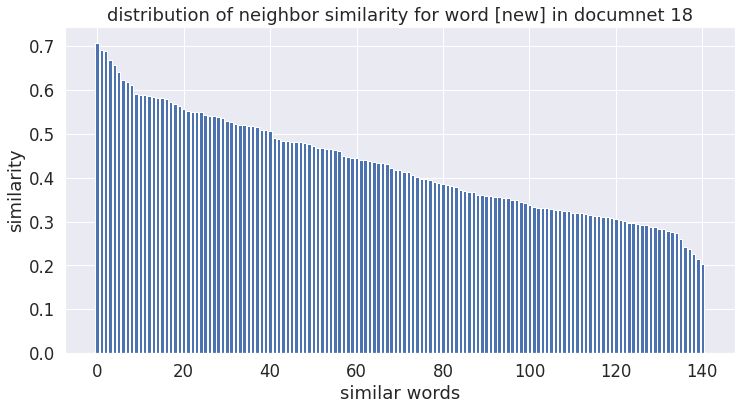

178   -->  ships
1738
[0.7354945, 0.6904499, 0.68552613, 0.66833246, 0.6674052, 0.6548872, 0.6178275, 0.614306, 0.60941, 0.5938475, 0.58171403, 0.58155334, 0.5680816, 0.56775796, 0.56725544, 0.5660778, 0.56096685, 0.5577035, 0.54986215, 0.5468435, 0.54510176, 0.53227925, 0.524094, 0.5186251, 0.51729655, 0.5144768, 0.51242423, 0.51124877, 0.50969857, 0.50944674, 0.5079538, 0.5037799, 0.5002797, 0.49280623, 0.49243033, 0.48574424, 0.4849187, 0.4796635, 0.4756716, 0.47481194, 0.46895173, 0.46818134, 0.4673224, 0.45654473, 0.4557708, 0.45402843, 0.45183897, 0.44985378, 0.44846517, 0.445018, 0.44462562, 0.44181797, 0.43348283, 0.43026042, 0.43012527, 0.42571798, 0.42562306, 0.42378578, 0.42028552, 0.4181626, 0.4172623, 0.41715282, 0.41131634, 0.41019118, 0.40829659, 0.40784854, 0.40742248, 0.4052795, 0.40207574, 0.40081358, 0.400716, 0.39928555, 0.39816856, 0.3972211, 0.39285332, 0.3914218, 0.39009765, 0.3898952, 0.3872853, 0.3863268, 0.38478127, 0.38391572, 0.38114738, 0.3755386, 0.3746841

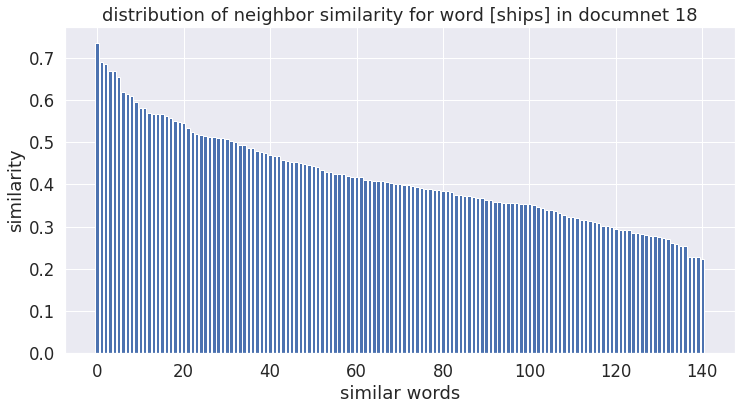

180   -->  cargo
1738
[0.7315475, 0.6838022, 0.67554784, 0.6316053, 0.62728965, 0.6029751, 0.5787893, 0.5664348, 0.55567384, 0.5469024, 0.5442578, 0.54060733, 0.5348112, 0.5277116, 0.52677, 0.52375937, 0.521127, 0.5176315, 0.51725715, 0.5166921, 0.5155698, 0.5154704, 0.51360536, 0.5131919, 0.51092917, 0.5084098, 0.5044519, 0.502395, 0.49542522, 0.49440995, 0.49306315, 0.49283755, 0.4906533, 0.48351157, 0.4811673, 0.48057717, 0.47831738, 0.47783238, 0.47632504, 0.47630066, 0.47031808, 0.46748203, 0.46516725, 0.45848322, 0.45429403, 0.45259732, 0.45113876, 0.4510238, 0.45029557, 0.4489991, 0.44504112, 0.44458318, 0.43417376, 0.43155247, 0.42743915, 0.42737886, 0.40966916, 0.40646783, 0.4051226, 0.4047948, 0.40475535, 0.40455946, 0.4019593, 0.40038788, 0.3978364, 0.39759296, 0.39255136, 0.39083043, 0.38776162, 0.38605696, 0.3845271, 0.38207763, 0.3812176, 0.3687934, 0.36858568, 0.36851823, 0.35848966, 0.35283217, 0.3468749, 0.3463977, 0.34544057, 0.3449579, 0.341542, 0.34138227, 0.337861,

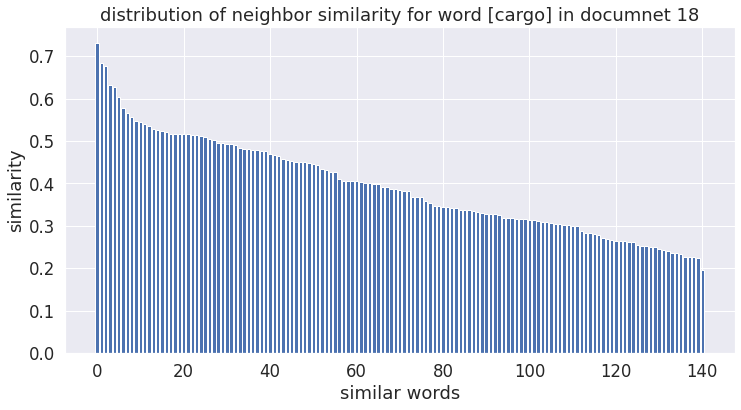

181   -->  rates
1738
[0.75025344, 0.7315475, 0.6390426, 0.58426017, 0.5248151, 0.52191937, 0.5216063, 0.5186788, 0.5041188, 0.50216764, 0.49150592, 0.49025947, 0.4822396, 0.47838753, 0.4782409, 0.4761774, 0.47401607, 0.47214785, 0.4712173, 0.47034854, 0.4686587, 0.4556889, 0.45533305, 0.447541, 0.4393972, 0.4357061, 0.4348711, 0.43248522, 0.43228245, 0.4289939, 0.42409572, 0.42371708, 0.421152, 0.4161663, 0.41604024, 0.4134591, 0.413053, 0.41061747, 0.40924802, 0.406381, 0.40573335, 0.40535596, 0.40175542, 0.40128866, 0.3982044, 0.39776665, 0.39308855, 0.39289075, 0.3924968, 0.38827443, 0.38690245, 0.38541436, 0.38469228, 0.384609, 0.38257793, 0.38146806, 0.36795807, 0.3677852, 0.36454722, 0.3621004, 0.360264, 0.3602004, 0.35669833, 0.35352772, 0.3530873, 0.3524644, 0.3518579, 0.35110593, 0.35007557, 0.34991062, 0.34975946, 0.34152693, 0.34138852, 0.33956733, 0.3350621, 0.33206075, 0.3311131, 0.32681388, 0.32615417, 0.32279727, 0.32075417, 0.31997764, 0.31921622, 0.3184493, 0.31577116

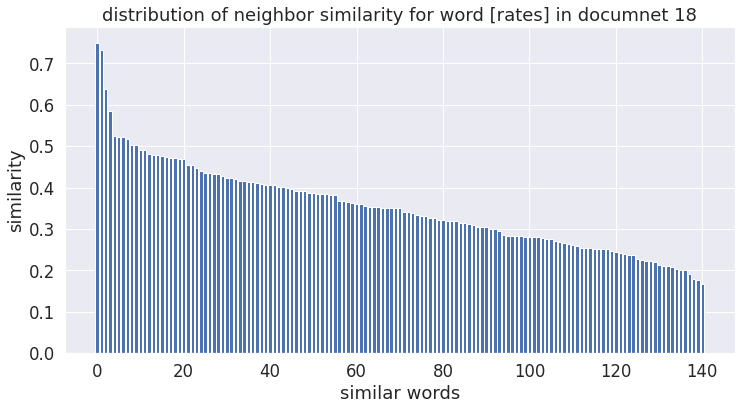

183   -->  rising
1738
[0.75025344, 0.698149, 0.6521567, 0.6316053, 0.61433625, 0.5877683, 0.55359983, 0.55240333, 0.5443015, 0.5351463, 0.52493966, 0.52072394, 0.5127243, 0.5045359, 0.50142336, 0.49314886, 0.49245733, 0.481843, 0.48141044, 0.47389355, 0.47056904, 0.4669786, 0.46278286, 0.46163058, 0.46078098, 0.45778364, 0.4577782, 0.4575342, 0.45680434, 0.45480448, 0.45156395, 0.44976628, 0.44852227, 0.4466151, 0.44606835, 0.44315672, 0.44223806, 0.44210976, 0.43746403, 0.43335652, 0.42801246, 0.42796397, 0.42212352, 0.42098042, 0.41800794, 0.41744146, 0.4134837, 0.4074734, 0.4044444, 0.40207738, 0.39996648, 0.3987257, 0.39569807, 0.39467043, 0.39154145, 0.3907193, 0.38974774, 0.3888039, 0.38526845, 0.38076824, 0.38015404, 0.37993953, 0.37698117, 0.37617767, 0.37116167, 0.36972737, 0.36916, 0.36759633, 0.36624432, 0.36092114, 0.35996264, 0.35651582, 0.355074, 0.3509576, 0.35018727, 0.34856614, 0.34270447, 0.3376318, 0.33614707, 0.33602968, 0.3290471, 0.3276789, 0.32505456, 0.3249974,

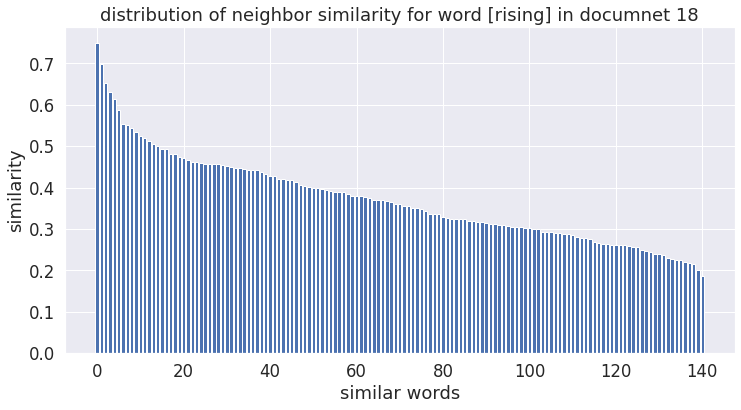

188   -->  delivered
1738
[0.60910845, 0.6030612, 0.5737871, 0.56920403, 0.5664348, 0.55317247, 0.5162971, 0.5159175, 0.50901157, 0.49965248, 0.49646232, 0.49288207, 0.49168116, 0.49080697, 0.49025947, 0.4859573, 0.48234528, 0.46874595, 0.4592347, 0.45143384, 0.44976628, 0.44969368, 0.44526047, 0.44405514, 0.43814778, 0.4377829, 0.43746123, 0.43514797, 0.43323502, 0.430564, 0.42644176, 0.42471904, 0.41994965, 0.41921946, 0.41555852, 0.4153505, 0.41456735, 0.40976012, 0.4039567, 0.40196356, 0.39924985, 0.39853075, 0.3980397, 0.39708385, 0.39641622, 0.3956324, 0.38581952, 0.38502878, 0.38311166, 0.38202396, 0.3798704, 0.37955278, 0.37638447, 0.3718683, 0.3692418, 0.36297596, 0.36272246, 0.36157542, 0.361111, 0.35975635, 0.3578326, 0.35682672, 0.35053378, 0.34896332, 0.34630162, 0.3415076, 0.34148467, 0.34085375, 0.34077662, 0.33940294, 0.3385931, 0.33729896, 0.3353568, 0.33526704, 0.33515716, 0.33486414, 0.33003494, 0.32529867, 0.3217851, 0.32079503, 0.3199522, 0.31832016, 0.31581557, 0.

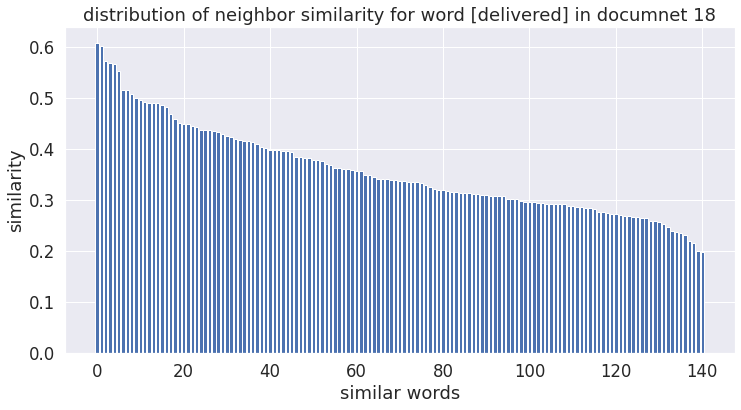

191   -->  market
1738
[0.82393634, 0.7677437, 0.7169461, 0.62728965, 0.61433625, 0.59168875, 0.59026855, 0.58426017, 0.56602055, 0.5643894, 0.55050266, 0.5359975, 0.5253382, 0.5146868, 0.5110322, 0.5093473, 0.50901157, 0.5023644, 0.5016689, 0.50062686, 0.49728355, 0.4949843, 0.4941213, 0.49088472, 0.48965028, 0.48458183, 0.48457414, 0.48438263, 0.47628134, 0.4762016, 0.47451296, 0.46899897, 0.4688114, 0.46711683, 0.46624386, 0.4661954, 0.4612478, 0.45892075, 0.4586516, 0.45758748, 0.4551644, 0.44574544, 0.4457385, 0.44362596, 0.4430774, 0.4412568, 0.43821603, 0.4358701, 0.43404764, 0.43223995, 0.4319775, 0.42920777, 0.42816567, 0.42044437, 0.41979676, 0.41399556, 0.40963584, 0.40640157, 0.40491688, 0.404887, 0.40165466, 0.39414257, 0.39218584, 0.3851349, 0.38329017, 0.38187194, 0.37928313, 0.3759296, 0.37500086, 0.37491375, 0.37112632, 0.36717832, 0.36148062, 0.35953474, 0.35765344, 0.35338274, 0.3526855, 0.35216266, 0.3516599, 0.35050315, 0.34966585, 0.34822568, 0.34729323, 0.3443538

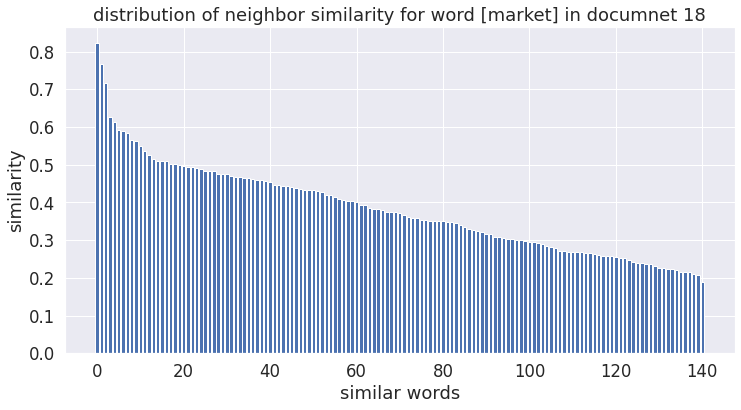

193   -->  softened
1738
[0.82393634, 0.74823344, 0.66514647, 0.6521567, 0.56104213, 0.5398973, 0.52666473, 0.5216063, 0.51845884, 0.49440995, 0.49288207, 0.49031794, 0.4735018, 0.46896648, 0.4682756, 0.46706527, 0.46553662, 0.46480697, 0.46164358, 0.45523798, 0.45188403, 0.44483453, 0.44298714, 0.4424202, 0.44109157, 0.4395234, 0.43867838, 0.4340241, 0.42982683, 0.42934734, 0.42793304, 0.40959942, 0.40872294, 0.4066956, 0.40573734, 0.40340564, 0.4024709, 0.40104055, 0.3995272, 0.39814737, 0.39375287, 0.39259118, 0.39181584, 0.39140347, 0.38667786, 0.38565546, 0.3847161, 0.3837662, 0.38375136, 0.37999934, 0.37312496, 0.36429656, 0.3638633, 0.3607613, 0.36051792, 0.35900313, 0.35692686, 0.3564477, 0.3551407, 0.35474434, 0.35143661, 0.349577, 0.34890833, 0.34667838, 0.34045172, 0.3361249, 0.33397406, 0.33251873, 0.3263305, 0.32496318, 0.32308167, 0.32291353, 0.32201934, 0.31985518, 0.31582028, 0.31525478, 0.31415245, 0.31415045, 0.31062365, 0.3073472, 0.30576125, 0.30085415, 0.29951102, 

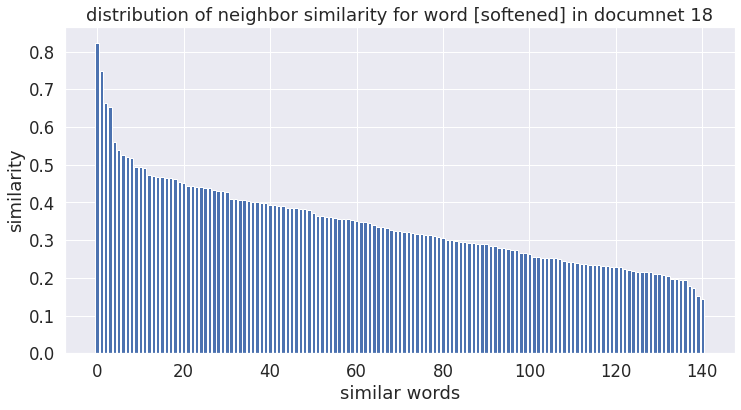

195   -->  lend
1738
[0.7519179, 0.7418396, 0.6749631, 0.6497823, 0.63965386, 0.6288945, 0.59227496, 0.58449054, 0.5686344, 0.5662532, 0.54930496, 0.53492475, 0.53067017, 0.5304071, 0.5281436, 0.5276439, 0.52668095, 0.51528466, 0.5080731, 0.50770974, 0.5063308, 0.50437576, 0.5034675, 0.49694547, 0.4876187, 0.48733532, 0.48351157, 0.48234528, 0.48049033, 0.48029733, 0.46741164, 0.4550398, 0.45198768, 0.45165247, 0.44384873, 0.44303936, 0.4412568, 0.44102645, 0.44038704, 0.43843758, 0.43450177, 0.43177143, 0.43168545, 0.43144113, 0.42615628, 0.4202928, 0.41933712, 0.4166171, 0.41368562, 0.40986586, 0.40964025, 0.40447077, 0.40432906, 0.40430146, 0.40185478, 0.39861277, 0.3976425, 0.3972536, 0.39402544, 0.39309993, 0.3925829, 0.39134696, 0.38972104, 0.38636303, 0.38546, 0.3811573, 0.3796327, 0.37585804, 0.37433589, 0.37162477, 0.37101123, 0.3708952, 0.3694377, 0.36850873, 0.36726862, 0.36602408, 0.36386824, 0.36369455, 0.3624013, 0.35865456, 0.35837847, 0.35731322, 0.35091668, 0.35076773,

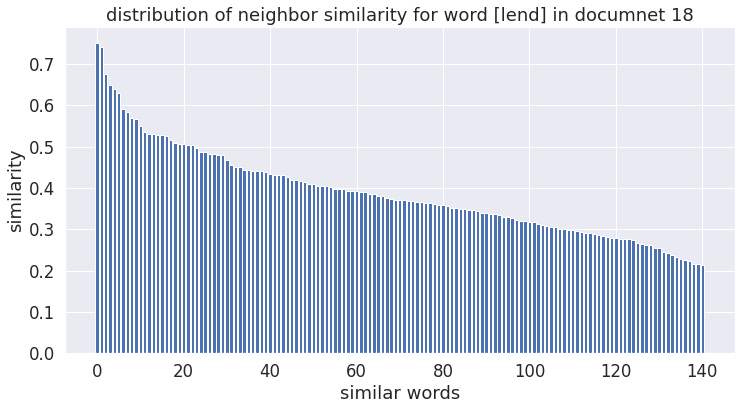

196   -->  ##ers
1738
[0.7519179, 0.7245881, 0.677809, 0.667872, 0.64165413, 0.6115546, 0.6049371, 0.60355985, 0.6016017, 0.5952232, 0.5873778, 0.5805128, 0.57872343, 0.5773716, 0.5702714, 0.5669265, 0.56122535, 0.55850935, 0.554739, 0.5522634, 0.5481302, 0.5467973, 0.5399138, 0.5371876, 0.5365767, 0.5353823, 0.5286627, 0.52645683, 0.5230104, 0.5169265, 0.5162047, 0.51510763, 0.5057422, 0.50315213, 0.5024409, 0.49087837, 0.4876497, 0.48629698, 0.48336673, 0.48293507, 0.4803633, 0.47452876, 0.47271878, 0.47009677, 0.46859556, 0.463967, 0.456065, 0.45560864, 0.45553643, 0.4534003, 0.4517988, 0.45143384, 0.4503433, 0.4486773, 0.44827726, 0.4468565, 0.4460503, 0.44504112, 0.44379354, 0.44362596, 0.44100857, 0.4356364, 0.43380272, 0.43332353, 0.4330896, 0.43175793, 0.42975926, 0.42946643, 0.4271047, 0.4249063, 0.42429334, 0.41963738, 0.41796884, 0.41683176, 0.41642037, 0.4135695, 0.4118283, 0.4115891, 0.40836808, 0.4075786, 0.403059, 0.40093723, 0.39841688, 0.39752766, 0.39706767, 0.3932025

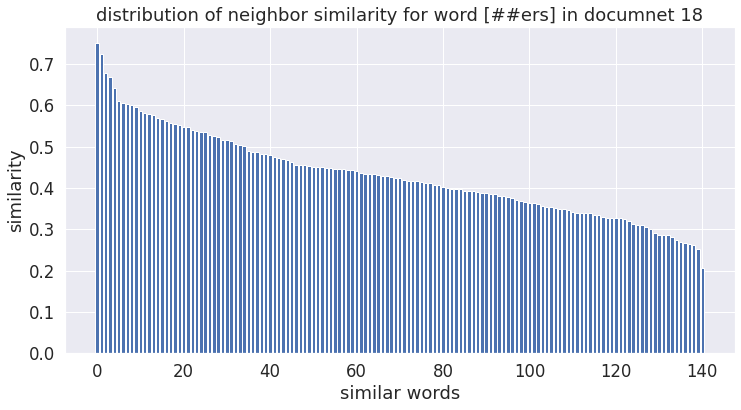

198   -->  made
1738
[0.6327578, 0.62636685, 0.5904633, 0.5830057, 0.5805128, 0.5739713, 0.56594026, 0.5639307, 0.5297859, 0.52786887, 0.5240309, 0.51903063, 0.50952154, 0.5093875, 0.5065017, 0.4920903, 0.4907958, 0.48460636, 0.4828626, 0.48086607, 0.47932026, 0.4742331, 0.47305664, 0.46476635, 0.46045527, 0.4576836, 0.44868088, 0.4418315, 0.43216562, 0.4283236, 0.42777765, 0.4275847, 0.42580518, 0.42252678, 0.42243624, 0.41874674, 0.41350293, 0.40964025, 0.40892747, 0.40810943, 0.40795362, 0.4053697, 0.40193433, 0.40061906, 0.40061903, 0.3956324, 0.39206332, 0.3876889, 0.3870936, 0.38512614, 0.37999934, 0.37989753, 0.37871155, 0.37861326, 0.3750022, 0.37491375, 0.37231517, 0.3700388, 0.36925313, 0.3675709, 0.36564136, 0.3629893, 0.36241585, 0.3620119, 0.35986552, 0.35805824, 0.3576399, 0.35604316, 0.3539454, 0.35314384, 0.35296813, 0.35273373, 0.3508091, 0.35074767, 0.35053676, 0.35007712, 0.3499815, 0.3499442, 0.34936953, 0.34842607, 0.34769487, 0.34680718, 0.3466691, 0.34599105, 0.3

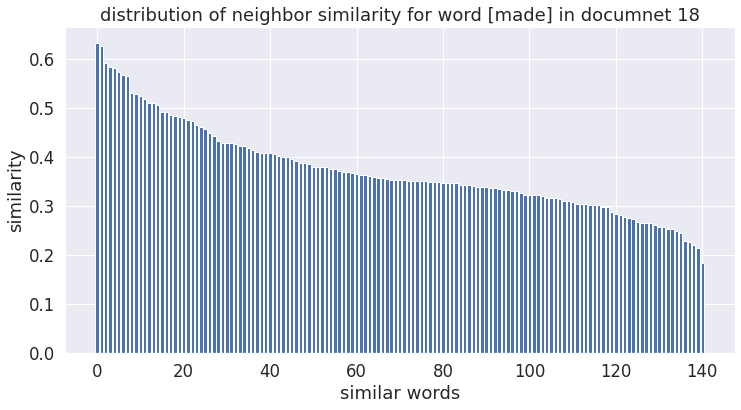

199   -->  credit
1738
[0.7418396, 0.677809, 0.6591443, 0.6573794, 0.643154, 0.6413242, 0.6310802, 0.60762143, 0.59468687, 0.5936439, 0.58866763, 0.5861795, 0.583609, 0.58229125, 0.57935786, 0.5630803, 0.56063426, 0.5602661, 0.55933297, 0.55168116, 0.54756856, 0.5374257, 0.52786887, 0.5275811, 0.5267142, 0.52535725, 0.52520907, 0.5199095, 0.5176315, 0.5159175, 0.51565033, 0.5074712, 0.5071016, 0.5023962, 0.5020679, 0.50062686, 0.49854672, 0.49720186, 0.49706897, 0.4902868, 0.48509753, 0.48424506, 0.48158556, 0.48098788, 0.47868586, 0.4701259, 0.4695627, 0.46630013, 0.4611876, 0.45685515, 0.4503827, 0.4487158, 0.4486724, 0.4471615, 0.44108018, 0.43958116, 0.43787536, 0.43594557, 0.43466136, 0.42029902, 0.41910627, 0.41614568, 0.41557738, 0.41444135, 0.41379207, 0.40757412, 0.40631405, 0.40573734, 0.40535596, 0.4052968, 0.40106994, 0.39956525, 0.3983118, 0.39468563, 0.39208668, 0.3916629, 0.3888039, 0.3859291, 0.38540575, 0.3838554, 0.382159, 0.38046983, 0.37970018, 0.37849203, 0.3770866

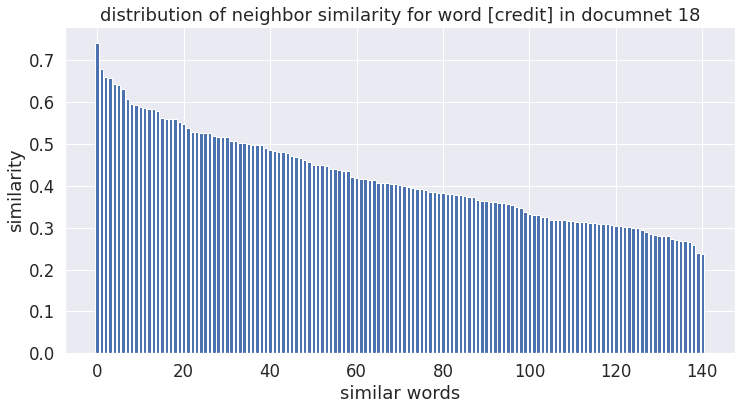

201   -->  scarce
1738
[0.6573794, 0.6216037, 0.6115546, 0.5922625, 0.5904633, 0.5869622, 0.58075356, 0.57911766, 0.56332105, 0.56317335, 0.5537443, 0.54416764, 0.53658724, 0.53589714, 0.52861893, 0.5263248, 0.52396744, 0.5234914, 0.5217992, 0.5117577, 0.51135707, 0.5078261, 0.5075636, 0.50648427, 0.5064389, 0.50437576, 0.5034542, 0.4989853, 0.498618, 0.4985823, 0.49651295, 0.48196602, 0.47489437, 0.4687724, 0.46854252, 0.46530968, 0.45746413, 0.45495385, 0.45286065, 0.4503705, 0.44874752, 0.44664133, 0.44385582, 0.44351846, 0.44059145, 0.4398985, 0.4371848, 0.43576384, 0.43484622, 0.43341145, 0.43316758, 0.430564, 0.41684517, 0.41473353, 0.41390494, 0.41233766, 0.40827665, 0.40798625, 0.40756252, 0.40720898, 0.40511948, 0.40388522, 0.40344706, 0.40227604, 0.40165466, 0.39216653, 0.3915, 0.39083043, 0.39066756, 0.38980734, 0.3857826, 0.3854612, 0.38434795, 0.37540257, 0.37118655, 0.37104943, 0.37038055, 0.36907187, 0.3657277, 0.3650828, 0.35996264, 0.35708755, 0.3564477, 0.35610276, 0.

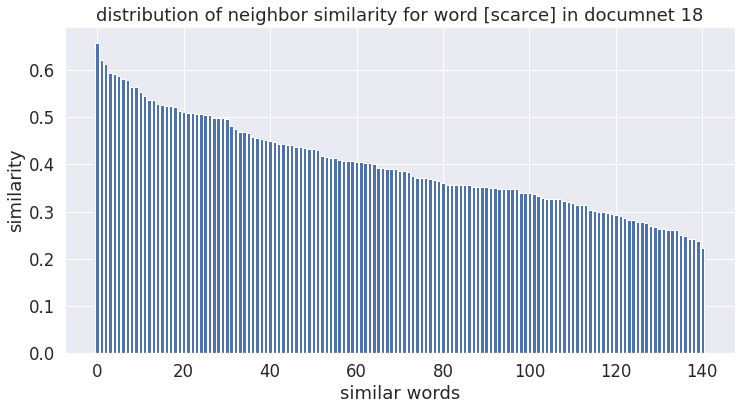

203   -->  many
1738
[0.82437414, 0.79021937, 0.7364994, 0.71083516, 0.679309, 0.6671829, 0.66422534, 0.6635179, 0.6633386, 0.65740514, 0.65641195, 0.65601486, 0.6548004, 0.6517043, 0.6493908, 0.64372, 0.6424928, 0.64147544, 0.6253709, 0.6236975, 0.6199354, 0.61895174, 0.6174841, 0.6141311, 0.6113452, 0.61083925, 0.6084645, 0.6052909, 0.60327667, 0.601845, 0.59663534, 0.5959089, 0.5950236, 0.5935767, 0.59036744, 0.58694, 0.58645, 0.5814776, 0.5789805, 0.5749668, 0.56602055, 0.56452274, 0.5621793, 0.5614268, 0.56063426, 0.5551902, 0.536813, 0.5353823, 0.5348112, 0.52828175, 0.5075636, 0.4907958, 0.49031794, 0.48148802, 0.48141044, 0.47752166, 0.4761774, 0.4729344, 0.47279465, 0.46874595, 0.468477, 0.46563688, 0.46215084, 0.45647705, 0.45174962, 0.44303936, 0.42974246, 0.42951858, 0.419565, 0.4147287, 0.4147178, 0.4085524, 0.40153784, 0.40126625, 0.39919806, 0.3951351, 0.39480197, 0.39285317, 0.38479638, 0.38242143, 0.38240826, 0.37525162, 0.36923438, 0.3673361, 0.35798776, 0.35587746, 0

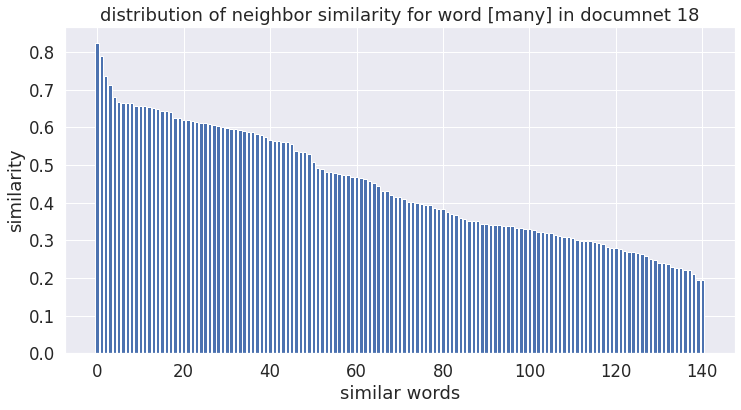

204   -->  businesses
1738
[0.82437414, 0.73693836, 0.7018478, 0.6789284, 0.6739725, 0.6649072, 0.6647216, 0.66252935, 0.6617014, 0.65573585, 0.6453479, 0.64478934, 0.64133215, 0.6402459, 0.6363395, 0.6358752, 0.6316213, 0.6190996, 0.615016, 0.61214983, 0.6101582, 0.60151273, 0.5981351, 0.58764124, 0.57935786, 0.5626967, 0.55850935, 0.55682313, 0.5454441, 0.5354638, 0.5353657, 0.5253382, 0.5245037, 0.5241603, 0.52221394, 0.51725715, 0.50414175, 0.50344676, 0.50283396, 0.5012963, 0.49508476, 0.4913782, 0.49080697, 0.48877332, 0.4876187, 0.48522127, 0.4839052, 0.4822396, 0.48222572, 0.4732427, 0.4684386, 0.46530968, 0.4615496, 0.45537412, 0.44852227, 0.4459071, 0.4449761, 0.4438495, 0.44298714, 0.439993, 0.4377961, 0.42062762, 0.41629928, 0.41260964, 0.4053697, 0.40302432, 0.40160137, 0.39624274, 0.39400876, 0.38865864, 0.38162997, 0.37542522, 0.3744433, 0.37013775, 0.3701113, 0.36999893, 0.36461586, 0.36266056, 0.35948324, 0.35837394, 0.35803178, 0.35515878, 0.35079205, 0.34732908, 0.34

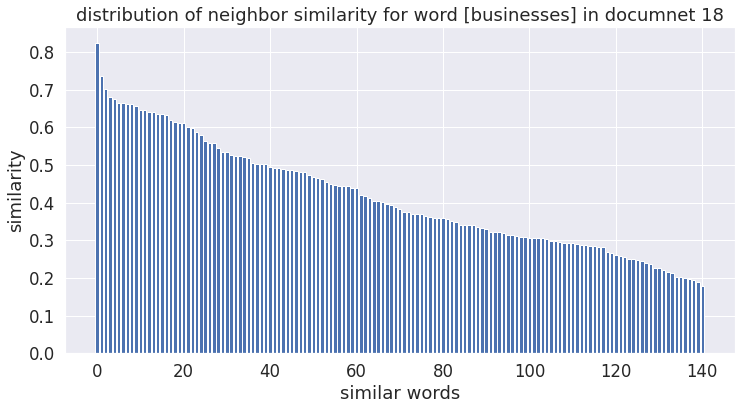

206   -->  grown
1738
[0.79021937, 0.76913846, 0.7174163, 0.7067474, 0.70506454, 0.6761992, 0.6739725, 0.65675765, 0.6362153, 0.6212681, 0.6148256, 0.61377335, 0.60783964, 0.60164464, 0.6006527, 0.59369403, 0.5923957, 0.5840997, 0.5830057, 0.57830745, 0.5702525, 0.5685667, 0.5610806, 0.55769837, 0.55359983, 0.55277514, 0.55050266, 0.54868805, 0.5476459, 0.54652864, 0.54618645, 0.5460328, 0.5427166, 0.5426329, 0.54060113, 0.53448564, 0.53204304, 0.5306238, 0.52861667, 0.52805656, 0.5270106, 0.5267142, 0.52666473, 0.5266324, 0.5230104, 0.5205667, 0.5171101, 0.51092917, 0.51052314, 0.5098791, 0.5041188, 0.5016153, 0.4985823, 0.49478656, 0.49294227, 0.489686, 0.48585972, 0.48369092, 0.47758964, 0.47483593, 0.47056592, 0.47021732, 0.46649048, 0.46102798, 0.45750415, 0.45069697, 0.4479065, 0.4479022, 0.44423658, 0.44338524, 0.43726975, 0.43347076, 0.43168545, 0.43071455, 0.42090994, 0.41525006, 0.41456735, 0.41179383, 0.40849167, 0.4037181, 0.40214473, 0.40009353, 0.39894146, 0.39039275, 0.3

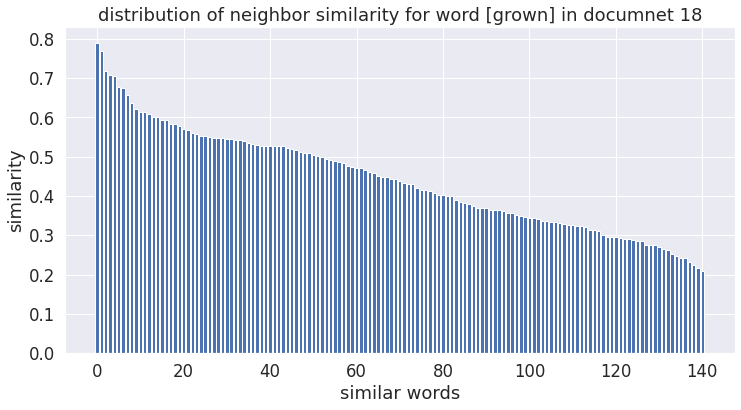

208   -->  reluctant
1738
[0.7412116, 0.7364994, 0.7067474, 0.69453394, 0.67923707, 0.6649072, 0.6527417, 0.6513059, 0.63563806, 0.6330061, 0.6210882, 0.6111145, 0.60924, 0.6035069, 0.59666574, 0.59399354, 0.59341776, 0.58288515, 0.5826808, 0.57750124, 0.5646993, 0.55653715, 0.5540543, 0.53887403, 0.53779703, 0.536138, 0.5321262, 0.51920104, 0.5120863, 0.51135707, 0.5074712, 0.50380284, 0.50142336, 0.50130826, 0.49514332, 0.49455714, 0.4935693, 0.49302483, 0.49202266, 0.48524702, 0.48413107, 0.47838753, 0.47727156, 0.4762016, 0.4706934, 0.4674601, 0.46726596, 0.46480697, 0.45029557, 0.44798002, 0.44570145, 0.43995392, 0.43471566, 0.42604938, 0.42580518, 0.4192779, 0.41642037, 0.4153505, 0.40625548, 0.40537226, 0.40353602, 0.40084526, 0.39776453, 0.39149067, 0.38853508, 0.38369498, 0.38308042, 0.38012904, 0.3787604, 0.37757808, 0.37592918, 0.37439138, 0.36878067, 0.3651011, 0.35765672, 0.35732436, 0.356468, 0.35625327, 0.3558189, 0.35309204, 0.34917617, 0.34783047, 0.34699538, 0.3452198

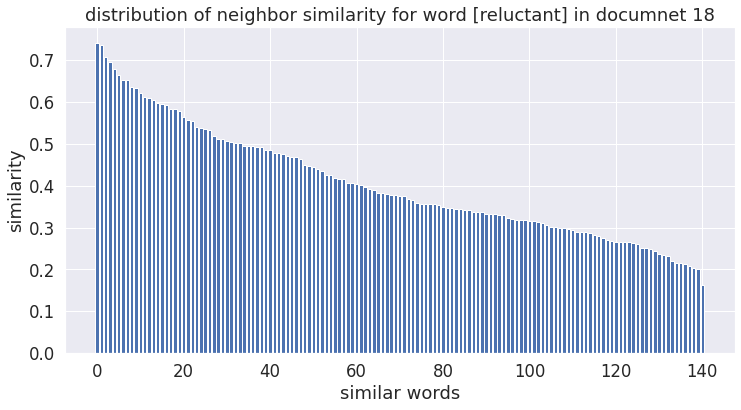

210   -->  sign
1738
[0.7747459, 0.7526635, 0.7412116, 0.7409127, 0.7393892, 0.73318607, 0.71605134, 0.7048515, 0.683257, 0.65405345, 0.6517043, 0.6455755, 0.61918205, 0.6149467, 0.6101582, 0.6091449, 0.59754854, 0.58322656, 0.57633185, 0.56429344, 0.56379145, 0.5627147, 0.5610806, 0.56067526, 0.5589225, 0.557374, 0.55075055, 0.5499667, 0.5174947, 0.51088864, 0.5023962, 0.4982787, 0.49273455, 0.46720594, 0.46292162, 0.4624769, 0.46110475, 0.45671922, 0.45505255, 0.45476103, 0.4510238, 0.4503433, 0.44069722, 0.4342399, 0.43126017, 0.43112832, 0.42879492, 0.42816567, 0.41848078, 0.413053, 0.4108866, 0.4044444, 0.40227604, 0.3953659, 0.39402544, 0.38644665, 0.38502878, 0.38434887, 0.3831617, 0.3829313, 0.38061944, 0.38048443, 0.37993014, 0.37656376, 0.37425002, 0.37371087, 0.36753988, 0.36723864, 0.36129355, 0.35692686, 0.3566411, 0.35663414, 0.35632038, 0.35426316, 0.35339773, 0.35268915, 0.35166925, 0.3503015, 0.34842607, 0.3479892, 0.34592962, 0.34240523, 0.3406071, 0.33503264, 0.33483

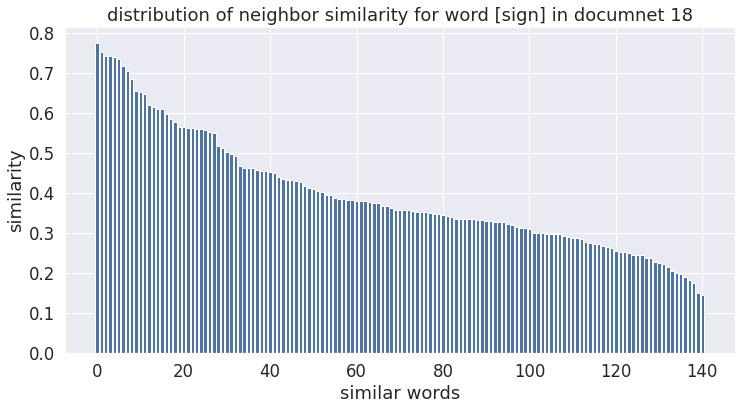

212   -->  long
1738
[0.84189355, 0.80795825, 0.80478597, 0.7747459, 0.7688643, 0.75565284, 0.7237871, 0.7237365, 0.71083516, 0.69820535, 0.6894514, 0.68525946, 0.67923707, 0.6756588, 0.6642659, 0.66252935, 0.66056544, 0.6593348, 0.655416, 0.6464138, 0.64440334, 0.63611114, 0.63222635, 0.61597764, 0.61377335, 0.61365414, 0.6085049, 0.5920054, 0.5888529, 0.5778656, 0.5758574, 0.5549672, 0.554417, 0.55302095, 0.5426203, 0.5380836, 0.53521425, 0.5314707, 0.5274555, 0.52535725, 0.5249853, 0.51510763, 0.51360536, 0.51157385, 0.4866606, 0.48585236, 0.4856298, 0.48438263, 0.4832058, 0.4712173, 0.46877033, 0.46788865, 0.46657023, 0.46654844, 0.46535924, 0.46330196, 0.46278286, 0.45286065, 0.4465043, 0.44038704, 0.4299168, 0.42982683, 0.4249305, 0.42471904, 0.4186234, 0.41579783, 0.40657207, 0.40477568, 0.40237033, 0.40098915, 0.39163485, 0.3783044, 0.376539, 0.37605193, 0.37298042, 0.36496252, 0.3629893, 0.36282182, 0.35988048, 0.3584295, 0.35769534, 0.3572979, 0.35714144, 0.35703355, 0.355464

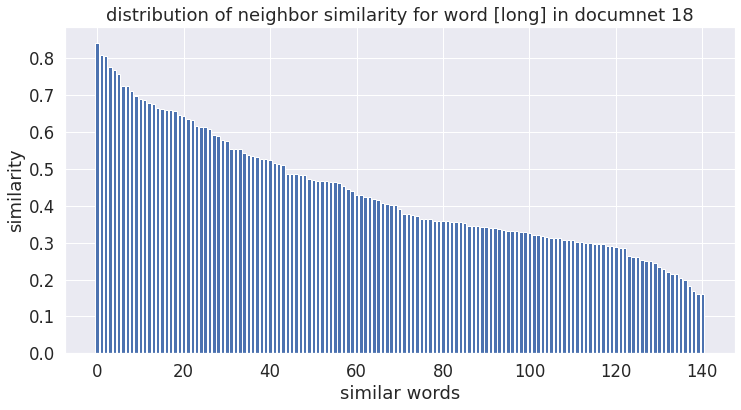

214   -->  term
1738
[0.84189355, 0.7988486, 0.74225664, 0.7419268, 0.7407821, 0.72704667, 0.71605134, 0.7059624, 0.69822276, 0.69449997, 0.6857003, 0.6671829, 0.6647216, 0.64631945, 0.6443091, 0.6316111, 0.6224967, 0.6172244, 0.6152499, 0.61225, 0.60828054, 0.60186636, 0.60010016, 0.59399354, 0.56446517, 0.5638648, 0.56352097, 0.55769837, 0.54503536, 0.5394958, 0.52643055, 0.51565033, 0.51126915, 0.5084098, 0.4974561, 0.49504393, 0.49132913, 0.48629698, 0.48457414, 0.47734925, 0.46980244, 0.4623605, 0.46096218, 0.45915452, 0.45736426, 0.45680434, 0.45533305, 0.45073068, 0.43843758, 0.43817925, 0.4364557, 0.43195945, 0.42567647, 0.42376575, 0.42216063, 0.42192066, 0.42188022, 0.42136094, 0.41923577, 0.4160138, 0.41514665, 0.40976012, 0.40959942, 0.40388522, 0.40222204, 0.38842332, 0.38157082, 0.37219054, 0.37196934, 0.3673113, 0.35900366, 0.358471, 0.3543512, 0.34936953, 0.34585026, 0.34550616, 0.34394005, 0.34000528, 0.33736598, 0.3368765, 0.32693586, 0.32492614, 0.32384142, 0.3224324

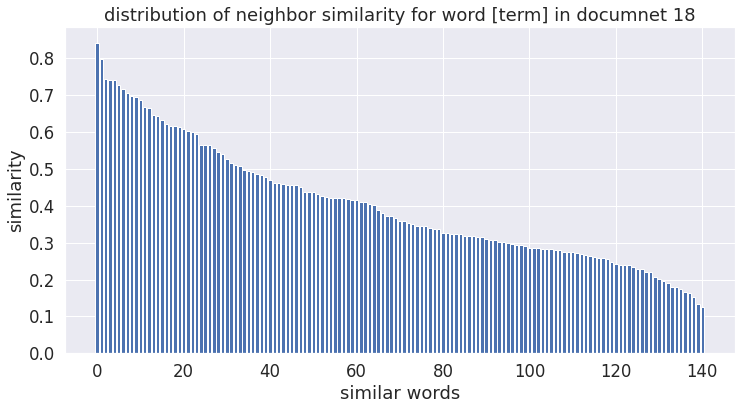

215   -->  contracts
1738
[0.7988486, 0.7688643, 0.7409127, 0.73830616, 0.7312688, 0.7242278, 0.71339595, 0.7018478, 0.7016816, 0.69260037, 0.67467463, 0.6584645, 0.6455612, 0.6427765, 0.63872874, 0.6363913, 0.6363615, 0.63018703, 0.6253709, 0.623497, 0.62203145, 0.6210882, 0.61130226, 0.59349537, 0.59295046, 0.58866763, 0.5813681, 0.57858527, 0.5545227, 0.5497206, 0.5399138, 0.5270106, 0.50848556, 0.5080731, 0.5035273, 0.502395, 0.4975103, 0.48560768, 0.47628134, 0.47019026, 0.46578595, 0.4616763, 0.45746413, 0.45626044, 0.4556889, 0.45219892, 0.4467154, 0.4458498, 0.44526047, 0.44064885, 0.43833843, 0.4322016, 0.42722905, 0.42094952, 0.42040804, 0.41800794, 0.41700673, 0.40716207, 0.4024709, 0.39662188, 0.3951085, 0.39200443, 0.38453686, 0.37913805, 0.37460065, 0.37341326, 0.36348975, 0.36117536, 0.3609535, 0.36011007, 0.35374877, 0.35273373, 0.35192615, 0.3515681, 0.35003173, 0.34814483, 0.34435493, 0.34395808, 0.34345788, 0.3363253, 0.33515957, 0.33435678, 0.3322275, 0.3254637, 0.3

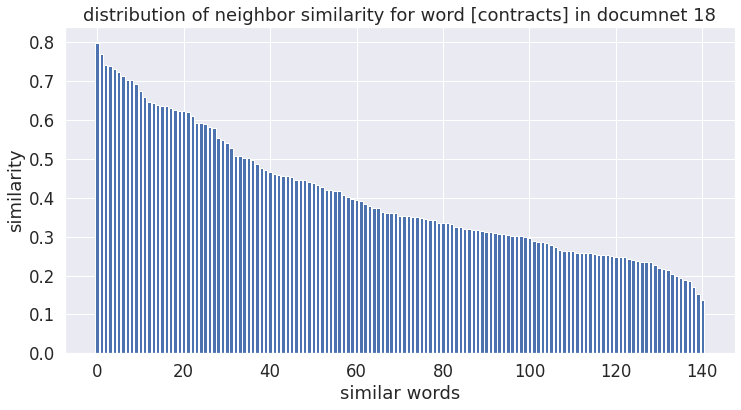

217   -->  help
1738
[0.8222714, 0.8065429, 0.75505143, 0.73776907, 0.7339686, 0.7312688, 0.7281967, 0.7237365, 0.7233697, 0.7059624, 0.69645166, 0.683257, 0.6374847, 0.6349746, 0.6236975, 0.61932266, 0.60924, 0.5992633, 0.58945835, 0.58764124, 0.5685224, 0.55950665, 0.5527642, 0.5480902, 0.54457706, 0.54060113, 0.5401316, 0.53956944, 0.5254593, 0.5071016, 0.50401664, 0.498815, 0.49617845, 0.4912579, 0.4870093, 0.48692656, 0.48127738, 0.4803633, 0.47577143, 0.47439122, 0.4727794, 0.47111285, 0.4709145, 0.4612478, 0.45848322, 0.4505197, 0.4445369, 0.44210976, 0.43464398, 0.41233766, 0.40608984, 0.40340564, 0.40217, 0.40119153, 0.4000456, 0.39908725, 0.39861277, 0.3982044, 0.3923108, 0.38957205, 0.38870567, 0.38434696, 0.3817262, 0.37819082, 0.37773305, 0.37601835, 0.3735344, 0.37066764, 0.36675274, 0.36561486, 0.36326966, 0.3620119, 0.35596702, 0.35401314, 0.34762466, 0.34670532, 0.3448561, 0.33940294, 0.33869416, 0.33861145, 0.33586198, 0.3357279, 0.3338577, 0.3321659, 0.3289447, 0.326

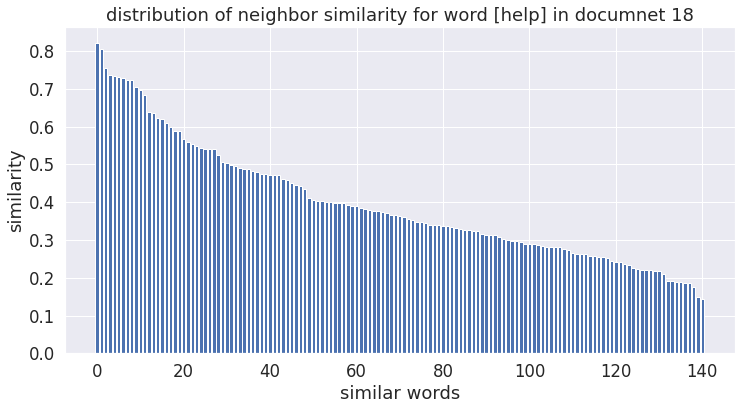

218   -->  guarantee
1738
[0.8222714, 0.76313376, 0.7504977, 0.7481437, 0.7393892, 0.7214161, 0.71635866, 0.69820535, 0.69449997, 0.69260037, 0.6817312, 0.6527417, 0.6454543, 0.6141311, 0.6025699, 0.60151273, 0.5897098, 0.5641843, 0.55291045, 0.54792345, 0.537651, 0.5345607, 0.52805656, 0.5192205, 0.5039506, 0.5026953, 0.5026659, 0.5022495, 0.501096, 0.4902868, 0.48297137, 0.48057717, 0.47633108, 0.47451296, 0.47389355, 0.470141, 0.4622317, 0.46188146, 0.45853484, 0.44827726, 0.44758266, 0.447541, 0.42898872, 0.42711294, 0.42704862, 0.42523664, 0.41554374, 0.41545337, 0.41350916, 0.41182336, 0.41123343, 0.41035816, 0.39988744, 0.3921998, 0.39172843, 0.39140347, 0.39067435, 0.38980734, 0.38972104, 0.38787055, 0.38613775, 0.38499552, 0.37983602, 0.37980822, 0.37868682, 0.37562585, 0.37413, 0.37411475, 0.3718683, 0.36942235, 0.36815554, 0.36787027, 0.36661023, 0.3645541, 0.36429214, 0.3606224, 0.35162738, 0.34966236, 0.34853786, 0.34327367, 0.33868057, 0.3346726, 0.33224583, 0.3314399, 0.

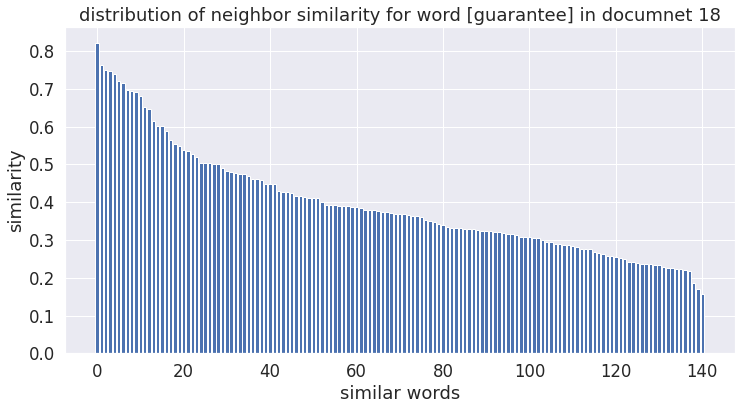

220   -->  loan
1738
[0.76313376, 0.73830616, 0.72704667, 0.7114121, 0.7043497, 0.69645166, 0.6956868, 0.68525946, 0.67005646, 0.6455755, 0.6453479, 0.6322639, 0.63024664, 0.6174841, 0.61468184, 0.6007676, 0.5969355, 0.5936439, 0.58995706, 0.58288515, 0.5787893, 0.5709325, 0.56544685, 0.5643894, 0.5554994, 0.5467988, 0.5466566, 0.5456263, 0.53448564, 0.5281436, 0.5271994, 0.5219482, 0.5147475, 0.50792587, 0.4998532, 0.49965248, 0.49245733, 0.4904369, 0.48877108, 0.48596567, 0.48565638, 0.47034854, 0.4696827, 0.46447095, 0.463967, 0.46164358, 0.4585017, 0.45647705, 0.45535696, 0.45267826, 0.45264816, 0.4479553, 0.44787455, 0.43344605, 0.4300822, 0.42600363, 0.4246276, 0.41780788, 0.41681772, 0.40499339, 0.4049172, 0.40344706, 0.40306315, 0.40159422, 0.40061915, 0.39615914, 0.39348945, 0.3922459, 0.3902312, 0.38560864, 0.38378894, 0.38350767, 0.3806197, 0.37773633, 0.37600017, 0.3734252, 0.3656681, 0.36493352, 0.35341743, 0.3533408, 0.35053608, 0.347108, 0.34364194, 0.3407079, 0.3365949,

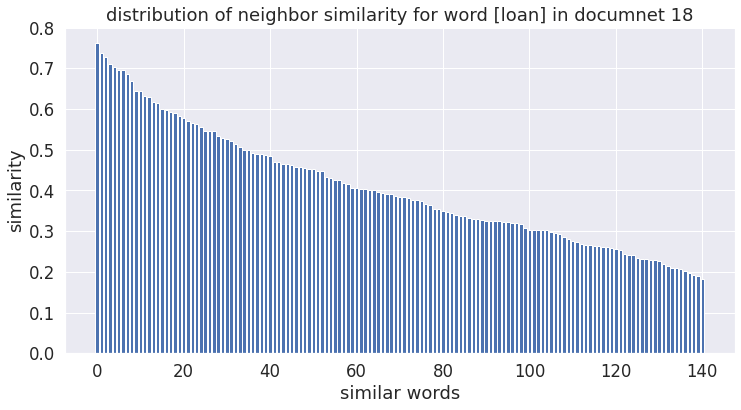

223   -->  paid
1738
[0.8354073, 0.80795825, 0.77535033, 0.7526635, 0.7481437, 0.7407821, 0.7339686, 0.7242278, 0.7196499, 0.7114121, 0.69453394, 0.6674155, 0.66025126, 0.6517502, 0.6479639, 0.6436455, 0.6424928, 0.6381068, 0.63361627, 0.63051987, 0.615016, 0.5923957, 0.5889564, 0.5672647, 0.5630115, 0.56158346, 0.5581808, 0.554546, 0.5517012, 0.54756856, 0.53819394, 0.5331359, 0.5327614, 0.5276099, 0.52493966, 0.5177351, 0.5146868, 0.5107079, 0.5100664, 0.5044519, 0.50288856, 0.50208616, 0.49746147, 0.49644053, 0.49218503, 0.4803816, 0.4782409, 0.47722393, 0.4735018, 0.46768358, 0.4580529, 0.45473313, 0.4517988, 0.44946778, 0.4438243, 0.44351846, 0.43514797, 0.43387288, 0.43177143, 0.4310115, 0.43051723, 0.42549762, 0.42055714, 0.4194541, 0.41388127, 0.41212207, 0.40257603, 0.39976758, 0.39914334, 0.38996655, 0.38512614, 0.38476124, 0.38427985, 0.38179874, 0.38042143, 0.37747216, 0.37692672, 0.3738535, 0.37178016, 0.36802125, 0.3656643, 0.36498743, 0.36238274, 0.3620934, 0.35698873, 0

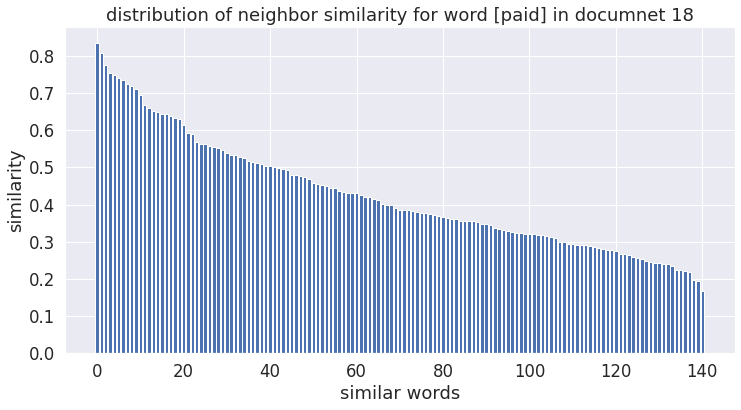

228   -->  state
1738
[0.80109996, 0.73400867, 0.7119545, 0.7017299, 0.679309, 0.664924, 0.6517502, 0.643154, 0.6398057, 0.6363913, 0.6358752, 0.63566685, 0.6349746, 0.63222635, 0.6306664, 0.61688197, 0.614931, 0.6035069, 0.60186636, 0.6007676, 0.59754854, 0.5973929, 0.5952232, 0.5932169, 0.5897098, 0.58860934, 0.58784646, 0.5840997, 0.5823182, 0.57821846, 0.5721073, 0.570809, 0.5707469, 0.56437474, 0.56332105, 0.54841924, 0.5453733, 0.5430708, 0.5425851, 0.5359975, 0.53492475, 0.5277116, 0.5259772, 0.5240309, 0.5231106, 0.5184938, 0.51616263, 0.50831413, 0.4985667, 0.49748266, 0.49705583, 0.49262118, 0.4903355, 0.48449582, 0.4796111, 0.47703674, 0.4682756, 0.467414, 0.45934147, 0.4577782, 0.45204726, 0.43214148, 0.4289939, 0.42644176, 0.4232884, 0.42236543, 0.42054155, 0.41773117, 0.41758648, 0.41717768, 0.41661602, 0.41449296, 0.41439056, 0.413996, 0.4043584, 0.40306264, 0.39829805, 0.39399612, 0.3916927, 0.38573232, 0.38199502, 0.38038492, 0.37760127, 0.37689263, 0.37579924, 0.37503

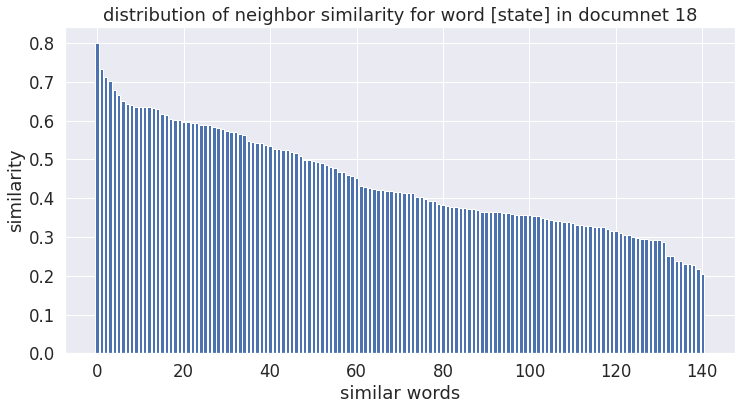

229   -->  subsidies
1738
[0.80109996, 0.7822065, 0.7650484, 0.7156399, 0.70776117, 0.70219886, 0.7016816, 0.6591443, 0.64478934, 0.6381068, 0.63611114, 0.63009, 0.6300454, 0.6241675, 0.61895174, 0.6151577, 0.6086857, 0.60414237, 0.60010016, 0.5992633, 0.58927643, 0.58605397, 0.5826808, 0.57818365, 0.5773716, 0.56949866, 0.5685667, 0.56722605, 0.5662532, 0.56544685, 0.56317335, 0.56098354, 0.5499667, 0.54980713, 0.54792345, 0.5455154, 0.53591776, 0.5311078, 0.52921045, 0.5275403, 0.5195398, 0.5093796, 0.5033604, 0.50181586, 0.4952098, 0.49458265, 0.49011916, 0.48458183, 0.47838518, 0.47836778, 0.47831738, 0.47673225, 0.47557652, 0.4742331, 0.4694672, 0.468489, 0.46154732, 0.4531033, 0.45188403, 0.44922188, 0.4442463, 0.4392553, 0.43746403, 0.43329042, 0.43323502, 0.43133217, 0.42494658, 0.42409572, 0.42003348, 0.41429085, 0.40441447, 0.4041971, 0.4030984, 0.40152168, 0.3930254, 0.39134166, 0.3863405, 0.3836954, 0.37903112, 0.3783555, 0.37467515, 0.37286332, 0.37150455, 0.36856014, 0.36

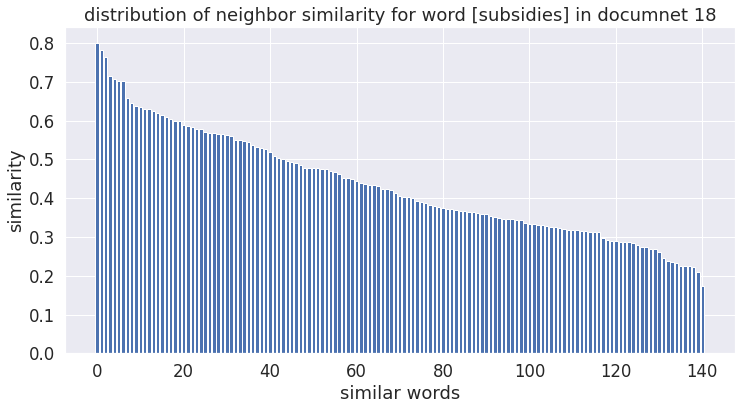

231   -->  shipyard
1738
[0.7822065, 0.7699657, 0.73693836, 0.73400867, 0.7017019, 0.67596626, 0.67467463, 0.6718707, 0.6642659, 0.66422534, 0.6635654, 0.6359085, 0.6334262, 0.6316111, 0.63051987, 0.63024664, 0.6221775, 0.616121, 0.58449054, 0.583609, 0.57293403, 0.5685224, 0.56650263, 0.56429344, 0.5641843, 0.56031835, 0.55561143, 0.5540543, 0.55204207, 0.5518942, 0.5476459, 0.5371876, 0.52122, 0.513515, 0.49815667, 0.49728355, 0.49565488, 0.49472663, 0.49427035, 0.4941365, 0.49378186, 0.49081418, 0.48850122, 0.47632504, 0.47467497, 0.46942636, 0.4650632, 0.46404594, 0.46188673, 0.46128154, 0.4589194, 0.45834115, 0.4500865, 0.44336498, 0.4408806, 0.43867838, 0.4377829, 0.43341145, 0.4277978, 0.4272534, 0.41520584, 0.4134837, 0.41092008, 0.4102223, 0.40632772, 0.40343988, 0.4003187, 0.39896297, 0.39655876, 0.3931067, 0.38827443, 0.38099173, 0.37848336, 0.37618858, 0.37344387, 0.36263946, 0.35804603, 0.35604316, 0.3556509, 0.35208732, 0.34858504, 0.3465516, 0.344505, 0.3347652, 0.333628

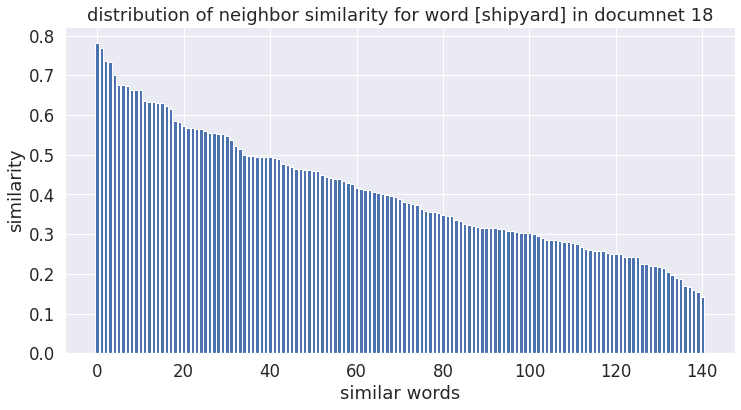

232   -->  ##s
1738
[0.7699657, 0.7097878, 0.70776117, 0.70241916, 0.66888386, 0.65573585, 0.655416, 0.64165413, 0.64147544, 0.6398057, 0.6382826, 0.63018703, 0.625805, 0.6224967, 0.60493326, 0.59181726, 0.58179045, 0.57788545, 0.5751994, 0.5673217, 0.56596637, 0.56564146, 0.5656047, 0.5589225, 0.5517012, 0.5473041, 0.54457706, 0.5426329, 0.5346091, 0.534566, 0.52884436, 0.52520907, 0.5219482, 0.50635445, 0.5063308, 0.5022495, 0.49832746, 0.49812564, 0.49602354, 0.48612556, 0.48277426, 0.47919342, 0.47727156, 0.47214258, 0.47054082, 0.4682338, 0.46307704, 0.45101148, 0.45076102, 0.44651684, 0.4464833, 0.44385582, 0.44074416, 0.4354127, 0.4324951, 0.4319775, 0.43126488, 0.42743915, 0.41372526, 0.4119116, 0.40985548, 0.40626955, 0.40488225, 0.3970937, 0.3915058, 0.3876889, 0.38257793, 0.37948024, 0.36972737, 0.3692418, 0.36584163, 0.36274743, 0.35931912, 0.3553127, 0.3523387, 0.34977925, 0.349577, 0.34726846, 0.3466062, 0.34526795, 0.34331673, 0.34329355, 0.34216088, 0.3401631, 0.3385900

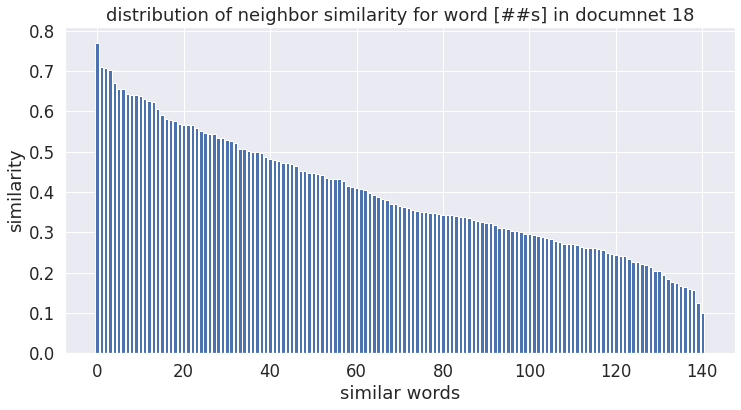

234   -->  falling
1738
[0.7156399, 0.7119545, 0.6844957, 0.67886233, 0.6674287, 0.6674155, 0.6334262, 0.62710655, 0.6189549, 0.61552596, 0.61365414, 0.6050258, 0.60164464, 0.59666574, 0.5869622, 0.5840675, 0.57972693, 0.5749668, 0.5602661, 0.56009793, 0.55818903, 0.5562941, 0.55291045, 0.55240333, 0.5497206, 0.5480902, 0.5473041, 0.54503536, 0.5414816, 0.5398973, 0.5354638, 0.5271994, 0.5210396, 0.51903063, 0.5174947, 0.5131936, 0.5053608, 0.502324, 0.5016689, 0.49833065, 0.49322012, 0.49294335, 0.48968273, 0.48576063, 0.48336673, 0.48288646, 0.47271323, 0.47238988, 0.47157085, 0.467236, 0.46631336, 0.45463794, 0.4540555, 0.45402685, 0.45165247, 0.44756526, 0.4474507, 0.43211102, 0.4318981, 0.42978194, 0.42760825, 0.42694533, 0.42630306, 0.41850123, 0.4117857, 0.4086266, 0.4060892, 0.40573335, 0.4041183, 0.40038788, 0.39716083, 0.39563322, 0.39532357, 0.39424554, 0.39237148, 0.38854164, 0.3865098, 0.38388765, 0.38311192, 0.38311166, 0.3761144, 0.37540895, 0.3739922, 0.37088776, 0.3663

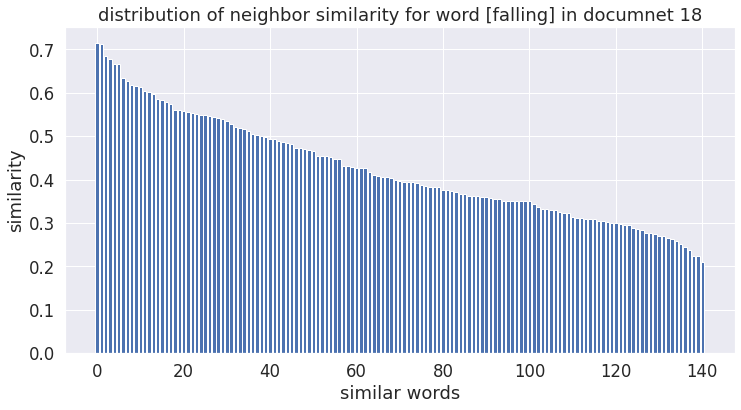

236   -->  also
1738
[0.6772733, 0.6692575, 0.6205311, 0.6056136, 0.60351646, 0.5922625, 0.5917721, 0.582548, 0.5312651, 0.52645683, 0.52062535, 0.5151398, 0.50952154, 0.5092153, 0.5060266, 0.5020106, 0.49471098, 0.48717743, 0.48509753, 0.48449582, 0.48233145, 0.48049033, 0.47970808, 0.47750956, 0.47157085, 0.4686862, 0.46563688, 0.4635848, 0.46154732, 0.45750415, 0.45101684, 0.45099938, 0.45071837, 0.4431929, 0.4354127, 0.42357767, 0.4170742, 0.41684735, 0.40664914, 0.40535676, 0.40370396, 0.39655876, 0.39592332, 0.39339542, 0.39063767, 0.39061582, 0.38829875, 0.38766652, 0.3744433, 0.3738292, 0.3714038, 0.37133604, 0.37097502, 0.36827904, 0.3673651, 0.36525917, 0.36048168, 0.3575873, 0.3567511, 0.3565929, 0.35462964, 0.35405618, 0.34673917, 0.34374452, 0.34368187, 0.34223163, 0.34086335, 0.3364749, 0.33629394, 0.3361309, 0.335087, 0.32877505, 0.32753247, 0.32711887, 0.32657507, 0.3240478, 0.32356644, 0.3217851, 0.32056808, 0.31947678, 0.31916463, 0.31875163, 0.318356, 0.31667376, 0.3

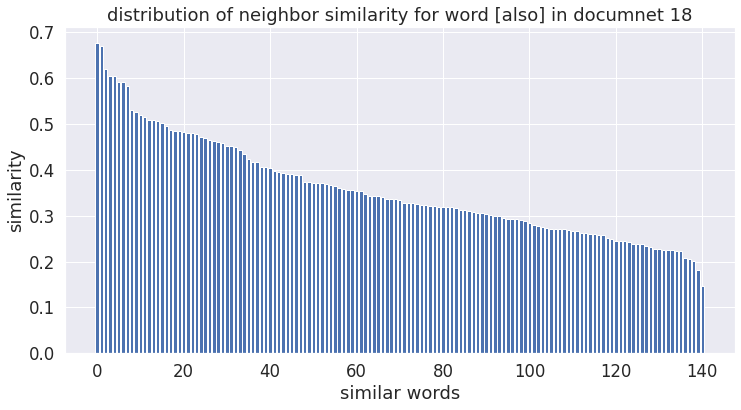

238   -->  new
1738
[0.73877096, 0.7380166, 0.7303242, 0.69882846, 0.6857616, 0.67596626, 0.65740514, 0.6422845, 0.6316213, 0.6288945, 0.625805, 0.6152499, 0.614931, 0.6086857, 0.6085049, 0.6006527, 0.59816444, 0.5969355, 0.59468687, 0.59295046, 0.57703906, 0.5683255, 0.5672426, 0.56528306, 0.56158346, 0.5605022, 0.5549048, 0.5522634, 0.5431097, 0.5414816, 0.52916014, 0.5254593, 0.52287364, 0.52144456, 0.51868117, 0.5186089, 0.5162971, 0.5154704, 0.5145992, 0.51088864, 0.5055977, 0.5046396, 0.5026659, 0.49849662, 0.49789575, 0.49514332, 0.49284637, 0.49263197, 0.48808944, 0.48717743, 0.48242146, 0.47489437, 0.46822873, 0.46624386, 0.46513045, 0.46410337, 0.46394235, 0.46207333, 0.46072382, 0.4414892, 0.44027135, 0.43260098, 0.42212352, 0.42205238, 0.419141, 0.40797928, 0.40196845, 0.40061906, 0.39923996, 0.39472187, 0.39457852, 0.39454424, 0.39375287, 0.3924968, 0.3921064, 0.39017564, 0.38639516, 0.3840397, 0.38047722, 0.3792007, 0.37572312, 0.37502366, 0.3730049, 0.3641455, 0.35794884

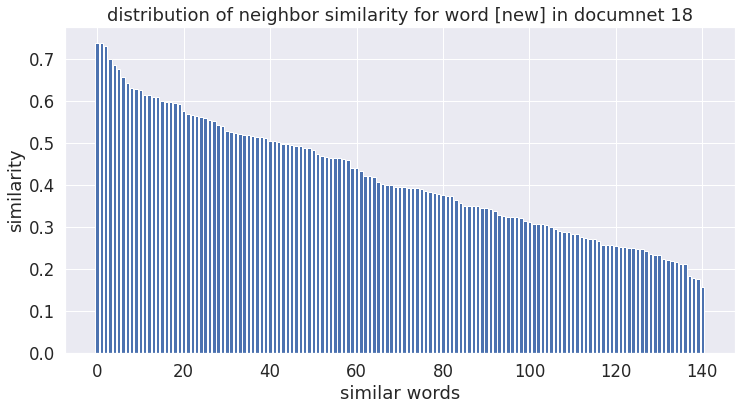

239   -->  ships
1738
[0.75307965, 0.7303242, 0.67789817, 0.6617014, 0.6549773, 0.63965386, 0.63872874, 0.6359085, 0.6310802, 0.6300454, 0.6084175, 0.60355985, 0.6029751, 0.5969888, 0.5916554, 0.58995706, 0.58860934, 0.58826107, 0.5870034, 0.58179045, 0.5789805, 0.5737871, 0.57127583, 0.5638648, 0.55691886, 0.5549672, 0.53614485, 0.5306238, 0.52841055, 0.52454036, 0.52396744, 0.5153981, 0.5122928, 0.5098284, 0.509223, 0.5074687, 0.49972767, 0.49368346, 0.49322012, 0.49218503, 0.49150592, 0.4912579, 0.49123192, 0.48734578, 0.47138336, 0.46874055, 0.46726596, 0.46504152, 0.4635848, 0.46188146, 0.46110475, 0.45042416, 0.44701737, 0.44592336, 0.4457385, 0.44289094, 0.43963522, 0.4377008, 0.43192697, 0.42924064, 0.4158813, 0.41540715, 0.41528046, 0.41229582, 0.41148067, 0.4074734, 0.40558004, 0.40481824, 0.40178066, 0.39758503, 0.39229447, 0.38883036, 0.3874491, 0.3870936, 0.38384232, 0.37655497, 0.37579754, 0.37454388, 0.37234464, 0.37153846, 0.36893222, 0.36666328, 0.36089152, 0.35970053,

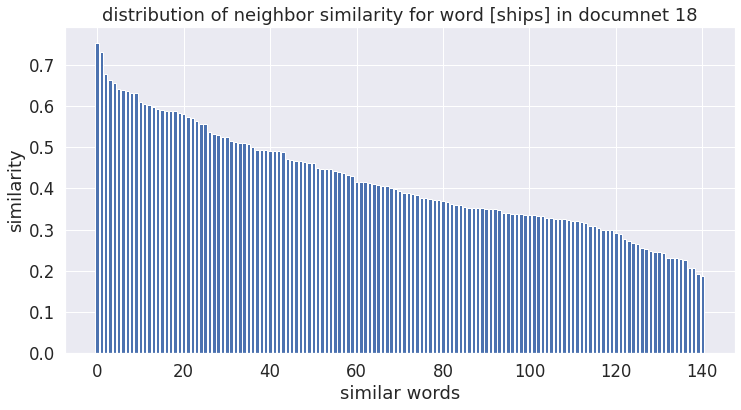

241   -->  become
1738
[0.83654344, 0.78722113, 0.76913846, 0.7467102, 0.6906096, 0.6327578, 0.6291483, 0.6027555, 0.5995629, 0.59816444, 0.59304833, 0.5845741, 0.5814776, 0.5714676, 0.5562941, 0.51616263, 0.5120863, 0.5078261, 0.49972767, 0.49706897, 0.49471098, 0.49458265, 0.48815498, 0.48192942, 0.47452876, 0.46974236, 0.46748203, 0.46223795, 0.4580529, 0.45798868, 0.45537412, 0.45503002, 0.45017448, 0.4500865, 0.44651684, 0.4465043, 0.44606835, 0.44119784, 0.43173462, 0.4294107, 0.42793304, 0.42099324, 0.42044437, 0.41514665, 0.41421437, 0.40859947, 0.40608984, 0.40499339, 0.40456495, 0.40430146, 0.40128866, 0.39969277, 0.39924985, 0.3975632, 0.39673054, 0.39575607, 0.3946116, 0.39175266, 0.39126837, 0.3910424, 0.39073482, 0.38886923, 0.38796288, 0.38723356, 0.38657862, 0.38644665, 0.38453686, 0.38234305, 0.3755091, 0.37334806, 0.37155116, 0.37089813, 0.36592796, 0.3606224, 0.35542595, 0.35450023, 0.34723252, 0.34060133, 0.33771807, 0.3353015, 0.3343718, 0.3279507, 0.32649916, 0.32

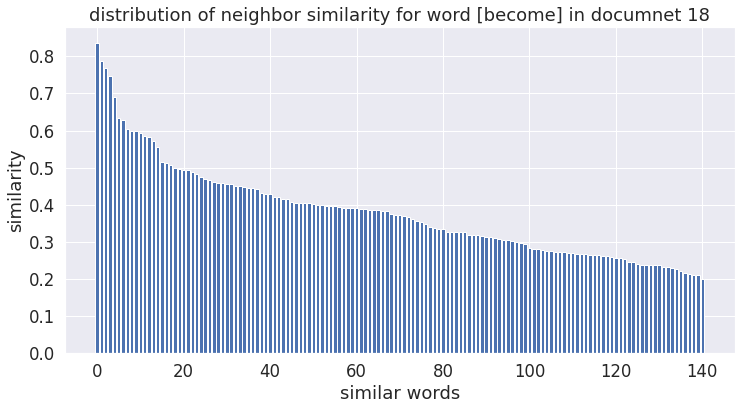

242   -->  much
1738
[0.8847691, 0.83654344, 0.7776296, 0.7551857, 0.7174163, 0.6888324, 0.6857616, 0.68397665, 0.67890954, 0.6635179, 0.6522492, 0.6306664, 0.62272996, 0.6189549, 0.60414237, 0.60351646, 0.58826107, 0.5861795, 0.5831058, 0.58075356, 0.5715857, 0.5674014, 0.56650263, 0.56596637, 0.56594026, 0.56191033, 0.56122535, 0.5603577, 0.5539354, 0.55302095, 0.55299103, 0.54299664, 0.54060733, 0.5327614, 0.5321262, 0.5320486, 0.5304071, 0.52596617, 0.52427936, 0.52221394, 0.5111546, 0.5022185, 0.498815, 0.4954542, 0.49132913, 0.49088472, 0.4895897, 0.48713017, 0.48596567, 0.48345998, 0.48326576, 0.48260218, 0.47536734, 0.47227928, 0.47019026, 0.4635294, 0.4575342, 0.45614868, 0.45505255, 0.45478347, 0.448295, 0.44758266, 0.44703394, 0.44035542, 0.43228245, 0.43161356, 0.43030378, 0.42950356, 0.42421225, 0.4231342, 0.40774274, 0.4039567, 0.39814737, 0.3872192, 0.38446963, 0.38353038, 0.3821286, 0.38075936, 0.37784314, 0.37496552, 0.3721379, 0.37082613, 0.36695558, 0.36340338, 0.359

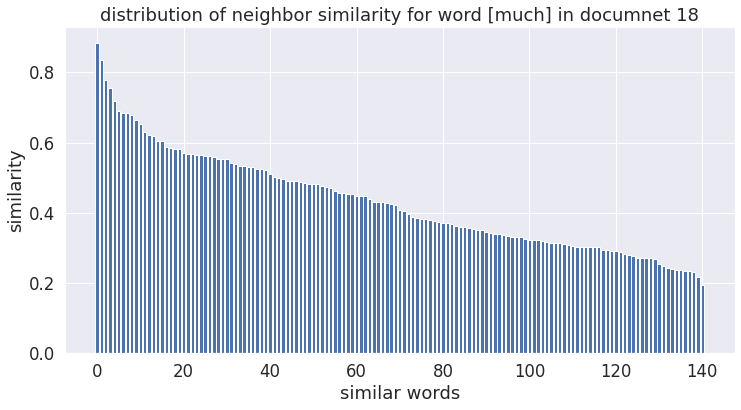

244   -->  expensive
1738
[0.7641269, 0.7551857, 0.7380166, 0.70219886, 0.67789817, 0.6718707, 0.6674287, 0.664924, 0.66056544, 0.65641195, 0.6513059, 0.6479639, 0.6413242, 0.6402459, 0.63742965, 0.6291483, 0.6267319, 0.623497, 0.6216037, 0.6212681, 0.6173173, 0.6095757, 0.60828054, 0.5951412, 0.5932883, 0.59181726, 0.5838108, 0.58322656, 0.57091665, 0.5686344, 0.56811404, 0.56448674, 0.5554994, 0.5527642, 0.5510789, 0.5481302, 0.54691887, 0.54207337, 0.5406152, 0.5345607, 0.5335362, 0.52502906, 0.5197011, 0.5155698, 0.5060122, 0.5045359, 0.49849904, 0.49422628, 0.48965028, 0.48671222, 0.4859573, 0.48485592, 0.4847258, 0.48273778, 0.47970808, 0.47957522, 0.4773708, 0.47401607, 0.46108732, 0.45923555, 0.4576836, 0.45678744, 0.4450872, 0.44469306, 0.44381088, 0.443435, 0.43251154, 0.42934734, 0.42805594, 0.42746395, 0.42436475, 0.41113776, 0.40654743, 0.40055376, 0.39234304, 0.38869894, 0.3778699, 0.37564465, 0.36646378, 0.36589512, 0.36332393, 0.36302897, 0.35910028, 0.35739988, 0.35504

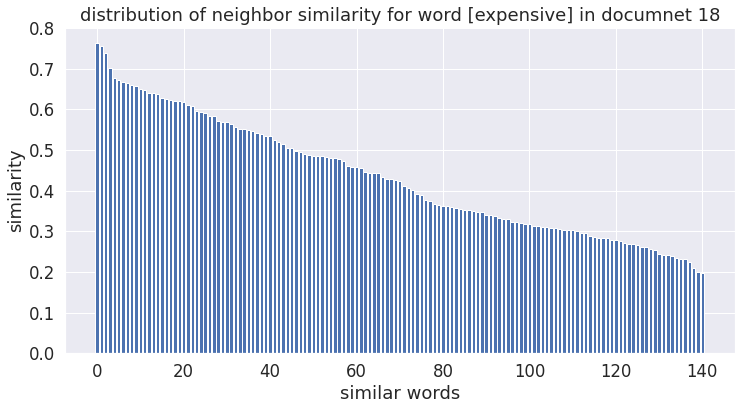

248   -->  capacity
1738
[0.7066148, 0.63563806, 0.6173173, 0.5981351, 0.5920054, 0.58694, 0.58686656, 0.5813681, 0.5809727, 0.5792212, 0.57818365, 0.56067526, 0.5581808, 0.5427166, 0.5425851, 0.53956944, 0.52643055, 0.5251126, 0.52250385, 0.513515, 0.51242626, 0.5098284, 0.5068617, 0.5026953, 0.502324, 0.50216603, 0.5018183, 0.49742937, 0.4954542, 0.49263197, 0.48161757, 0.48015034, 0.47868586, 0.47065818, 0.4696827, 0.45977148, 0.45076102, 0.449611, 0.44903433, 0.44710383, 0.44119784, 0.43316758, 0.43155247, 0.42380035, 0.420397, 0.41683176, 0.4116969, 0.40924802, 0.4091922, 0.40915477, 0.4046318, 0.3984658, 0.39569807, 0.38911062, 0.38202396, 0.38187194, 0.3810429, 0.3776505, 0.37101123, 0.36957198, 0.3653368, 0.36485884, 0.3589673, 0.35552147, 0.35297275, 0.35178676, 0.3499442, 0.3477372, 0.34593254, 0.34543848, 0.3454057, 0.3448635, 0.34389967, 0.34309426, 0.3417707, 0.34090874, 0.34007218, 0.3351946, 0.33102027, 0.32560834, 0.32431558, 0.32238215, 0.32201934, 0.3198005, 0.3191639

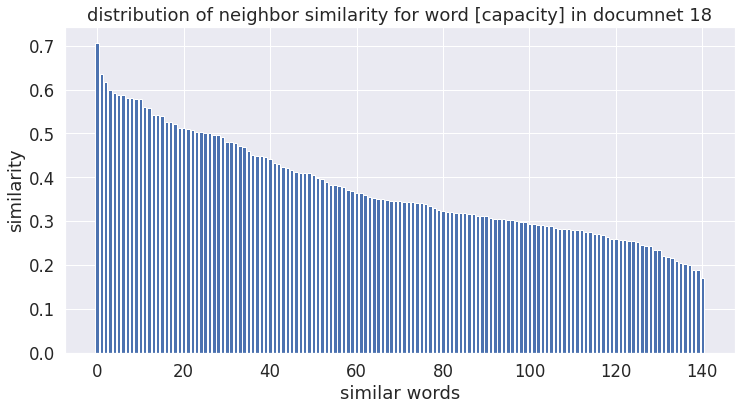

250   -->  build
1738
[0.67715013, 0.64304316, 0.64133215, 0.616121, 0.5809727, 0.5709325, 0.5672426, 0.56448674, 0.56446517, 0.5621793, 0.557374, 0.55691886, 0.5545227, 0.554417, 0.5371547, 0.52921045, 0.5173155, 0.5107079, 0.50831413, 0.50635445, 0.49168116, 0.48862404, 0.4870093, 0.48524702, 0.47758964, 0.47633108, 0.4701259, 0.46619776, 0.45608467, 0.45556855, 0.4550398, 0.4508835, 0.44773003, 0.4471203, 0.44404784, 0.440458, 0.43417376, 0.43313366, 0.43271232, 0.42989433, 0.42551816, 0.4231342, 0.41796884, 0.41678327, 0.41549206, 0.40769088, 0.39918938, 0.39563322, 0.39218584, 0.3907193, 0.3889002, 0.3885221, 0.3800414, 0.37825647, 0.3657248, 0.36454722, 0.36235833, 0.36171848, 0.35542595, 0.35024202, 0.34051135, 0.33855608, 0.3329575, 0.3310864, 0.32606554, 0.32496318, 0.31996214, 0.3174235, 0.3173806, 0.31589395, 0.3123559, 0.3096292, 0.3086596, 0.3079555, 0.30470002, 0.304499, 0.29670334, 0.2956223, 0.29543698, 0.29300088, 0.2917513, 0.29061058, 0.2840684, 0.28240427, 0.2817568

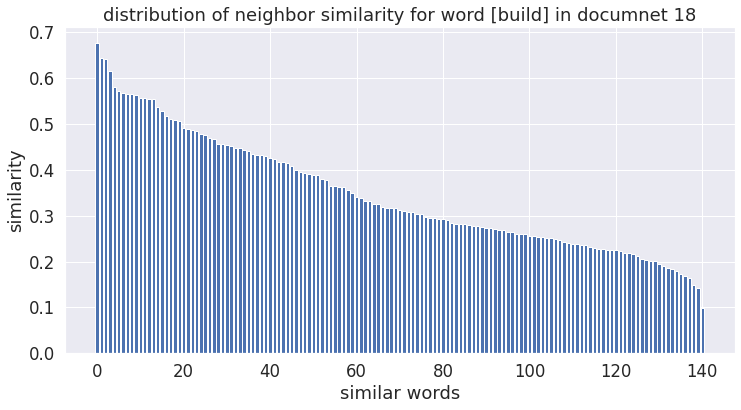

254   -->  cut
1738
[0.67886233, 0.6481722, 0.60783964, 0.6059347, 0.5951412, 0.587106, 0.58686656, 0.5831058, 0.57821846, 0.57750124, 0.5714676, 0.5706049, 0.5630115, 0.56098354, 0.5551902, 0.5380836, 0.5351463, 0.5207864, 0.50487393, 0.5006274, 0.49997866, 0.4966772, 0.49273455, 0.49081418, 0.48692656, 0.48522127, 0.48227072, 0.48196602, 0.4768702, 0.4737373, 0.47305664, 0.47302213, 0.46578595, 0.46382636, 0.46207333, 0.45853484, 0.45608467, 0.45595092, 0.45523798, 0.4525936, 0.4487158, 0.44787455, 0.44701737, 0.43220145, 0.4278414, 0.42567647, 0.4242013, 0.40535676, 0.40533388, 0.400948, 0.3970937, 0.39212635, 0.3896814, 0.38868552, 0.38823605, 0.38632464, 0.3851349, 0.37614435, 0.3743435, 0.3700239, 0.3694377, 0.36765307, 0.3663164, 0.36545348, 0.36302048, 0.3602196, 0.35986078, 0.35889637, 0.35857242, 0.35819277, 0.35580987, 0.3548787, 0.35352772, 0.35129833, 0.35109615, 0.34925094, 0.3481186, 0.3468749, 0.34624046, 0.34501278, 0.34354073, 0.3415076, 0.3398078, 0.337839, 0.3357619

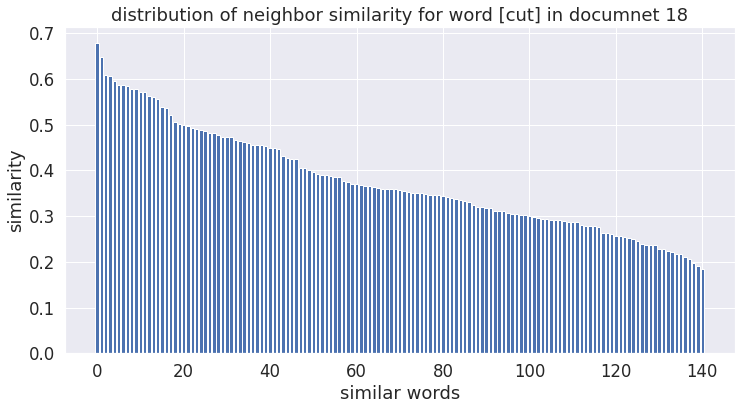



total tokens before removing stopwords: ['with', 'demand', 'outs', '##trip', '##ping', 'capacity', 'and', 'freight', 'rates', 'rising', ',', 'the', 'new', 'year', 'might', 'seem', 'ripe', 'for', 'a', 'flood', 'of', 'orders', 'for', 'new', 'bulk', '-', 'cargo', 'ships', '-', 'a', 'flood', 'reminiscent', 'of', 'those', 'in', 'the', 'early', '1970', "'", 's', 'and', 'the', 'early', '1980', "'", 's', '.', 'but', 'that', 'will', 'not', 'be', 'the', 'case', 'this', 'time', ',', 'many', 'people', 'in', 'the', 'industry', 'say', '.', 'instead', ',', 'some', 'experts', 'and', 'executives', 'say', ',', 'the', 'emphasis', 'in', 'the', 'next', 'few', 'years', 'will', 'be', 'on', 'finding', 'ways', 'to', 'extend', 'the', 'life', 'of', 'the', 'current', 'fleet', 'of', 'freighter', '##s', 'and', 'tanker', '##s', '.', "'", "'", 'the', 'world', 'will', 'have', 'to', 'be', 'content', 'with', 'the', 'existing', 'fleet', 'of', 'elderly', 'ladies', '-', 'war', '##ts', ',', 'face', 'lifts', 'and', 'all', 

In [66]:

#temporary ignore removing stopwords. 
# stopwords = [] # by removing this line, stopwords will be removed from the documents
print(tokenizer.tokenize(sentences[doc_num]))
print('tokens in  doc {} are {}'.format(doc_num, tokenizer.tokenize(sentences[doc_num])))
total_tokens = tokenizer.tokenize(sentences[doc_num])[0:min(max_length, len(sentences[doc_num]))]
print('size of the document before removing stopwords is ', len(total_tokens))
word_neighbor_similarity_dict = dict()
for ind, word in zip(total_tokens, range(1,len(total_tokens))):
  if ind not in stopwords and ind not in string.punctuation:
    plt.figure(word)
    print(word, '  --> ', ind)
    
    value_list = list()
    temp = sorted(find_similar(last_layer[doc_num], word,  tokenizer.tokenize(sentences[doc_num])).items(), key=lambda kv: kv[1], reverse=True)
    for d in temp:
      value_list.append(d[1])
      ## plot data
    #remove the actual word from the similarity
    value_list = value_list[1:]
    print(value_list)
    word_neighbor_similarity_dict[ind] = value_list
    print('variance is {}'.format(np.var(value_list)))
    print('Average is {}'.format(np.average(value_list)))
    plt.bar(range(0, len(value_list)), value_list)
    plt.xlabel('similar words')
    plt.ylabel('similarity')
    plt.title('distribution of neighbor similarity for word [{}] in documnet {}'.format(ind, doc_num))
    plt.show()
    # plt.savefig('/content/Images/'+ind+'.png')
print()
print()

print('total tokens before removing stopwords: {}'.format(total_tokens))
print('total tokens after removing stopwords: {}'.format(word_neighbor_similarity_dict.keys()))

In [67]:
##Calculate the gradient descent of the similarity distribution
# print(word_neighbor_similarity_dict)
gradient_word_similarity_dict = dict()
total_size = len(word_neighbor_similarity_dict['capacity']) # top is an example of tokens in the dictionary to find the length of each vector
print(total_size-total_size%10)
length =np.arange(0, total_size)

for word in word_neighbor_similarity_dict:
  # print(word_neighbor_similarity_dict[word])
  # print(length)
  # new_list = [word_neighbor_similarity_dict[word][x:x+jump] for x in range(0, len(word_neighbor_similarity_dict['top']), jump)]
  new_list = [word_neighbor_similarity_dict[word][x:x+jump] for x in range(0, total_size-total_size%jump, jump)]
  tm_list = list()
  for vec in new_list:
    m1, b1 = np.polyfit(np.arange(0, len(vec)), vec, 1)
    tm_list.append(m1)
  gradient_word_similarity_dict[word] = tm_list
for ele in gradient_word_similarity_dict.items():
  print(ele)
#convert dict to a numpy array

140
('demand', [-0.0364704430103301, -0.07197543978691096, -0.010410994291305431, -0.011718809604644682, -0.008890807628631526, -0.005682572722434962, -0.0012230277061461069, -0.0002287477254867081, -0.002730563282966557, -0.0011897683143615354, -0.0009233653545378638, -0.0019189417362212573, -0.00017496943473812432, -0.0015100389719008643, -0.0001846700906753066, -0.00046086311340329955, -0.0013903081417083272, -0.0022931396961211907, -0.0006142407655715204, -0.0006401389837264723, -0.0004865527153014573, -0.001739308238029428, -0.0015485137701033934, -0.0016242861747741363, -0.0029864609241485457, -0.0013429969549178364, -0.0007100701332091936, -0.0018872469663619804, -0.001434490084648062, -0.0013470053672790254, -0.001474052667617788, -0.001999258995056134, -0.00012761354446411127, -0.004374995827674843, -0.0020016580820083345, -0.0023234188556670705, -0.00044994056224820906, -0.004437014460563604, -0.0024662762880324853, -0.002034768462181105, -0.0010337084531783754, -0.0013640969

[[-0.03647044 -0.07197544 -0.01041099 ... -0.00229314 -0.00061424
  -0.00064014]
 [-0.02323025 -0.031542   -0.02501297 ... -0.00300971 -0.00187433
  -0.00033663]
 [-0.03217438 -0.02311787 -0.01500338 ... -0.00240254 -0.00250323
  -0.00492644]
 ...
 [-0.01305515 -0.01516408 -0.00343162 ... -0.00105907 -0.00116864
  -0.00739026]
 [-0.01790899 -0.02259424 -0.00138873 ... -0.00513281 -0.00168324
  -0.00573823]
 [-0.03551134 -0.00941435 -0.00432405 ... -0.00172041 -0.00155057
  -0.00306022]]
[[0.39191443 0.29589648 0.46869194 ... 0.49309545 0.49815044 0.49807245]
 [0.3808172  0.34073959 0.37206141 ... 0.48426106 0.49019642 0.49823904]
 [0.32455991 0.37131076 0.41538218 ... 0.48632164 0.4857487  0.47197477]
 ...
 [0.38563523 0.36797227 0.4694354  ... 0.49055646 0.48957973 0.43447359]
 [0.3762112  0.34571021 0.49019855 ... 0.46383201 0.48812068 0.45958359]
 [0.30017999 0.44413464 0.47425601 ... 0.48974958 0.49076129 0.48177238]]
list of cluster words are: 
cluster 0 is ['demand', 'outs', '##t

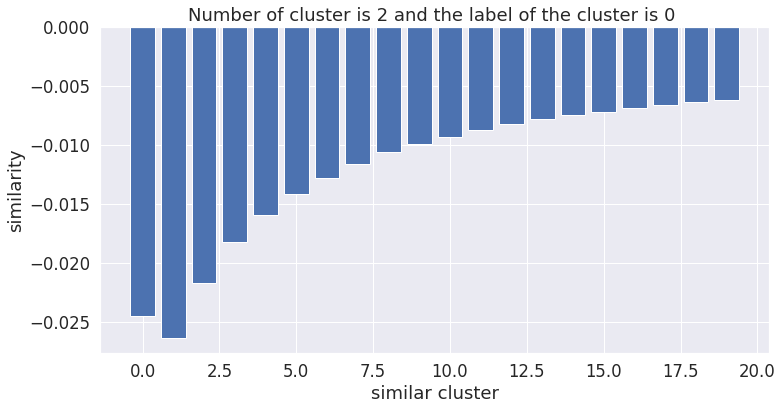

tmp_list shape is  (69, 20)  and the lenght is 20
Number of cluster is 1 and the label of the cluster is 1 


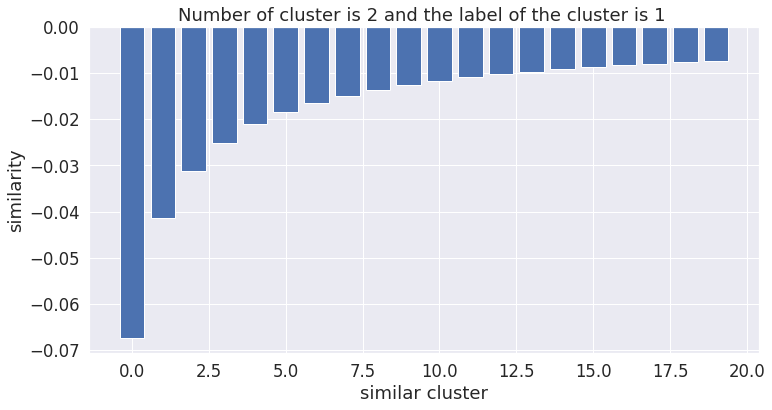

For n_clusters = 2 The average silhouette_score is : 0.30783943670289327
list of cluster words are: 
cluster 0 is ['freight', 'year', 'cargo', 'ships', 'emphasis', 'years', 'ladies', 'basil', 'chairman', 'major', 'london', 'mistake', 'ordering', 'delivered', 'lend', 'made', 'credit', 'scarce', 'grown', 'sign', 'long', 'term', 'contracts', 'help', 'guarantee', 'loan', 'paid', 'subsidies', 'falling', 'also']
cluster 1 is ['capacity', 'rates', 'rising', 'might', 'seem', 'ripe', 'bulk', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'many', 'experts', 'executives', 'next', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'elderly', 'face', 'lifts', 'said', 'papa', '##christ', '##idi', 'shipping', 'recalling', 'past', 'number', 'reasons', 'ship', '##own', 'worry', 'repeating', 'market', 'softened', 'businesses', 'state', 'much', 'cut']
cluster 2 is ['demand', 'outs', '##trip', '##ping', 'new', 'flood', 'orders', 'people', 'industry', 'say', 'instead', 'extend', '

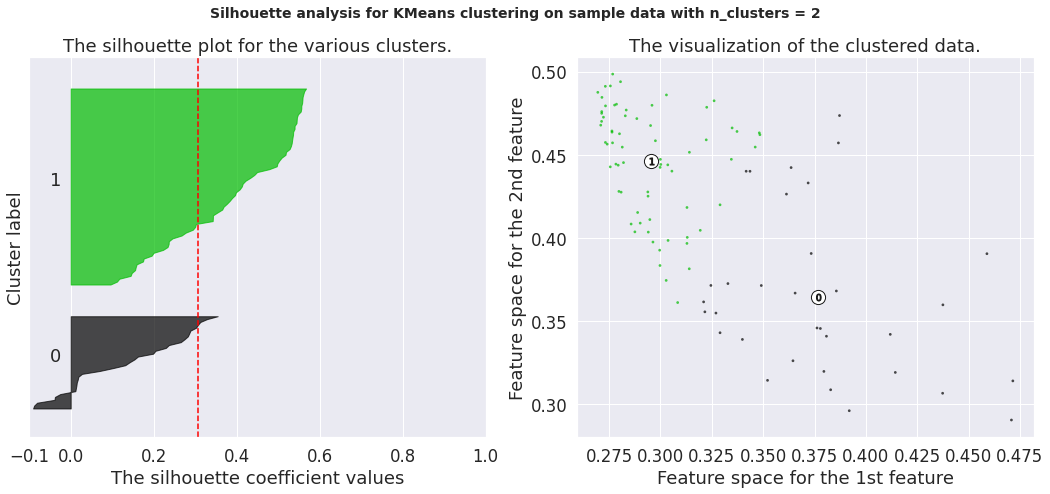

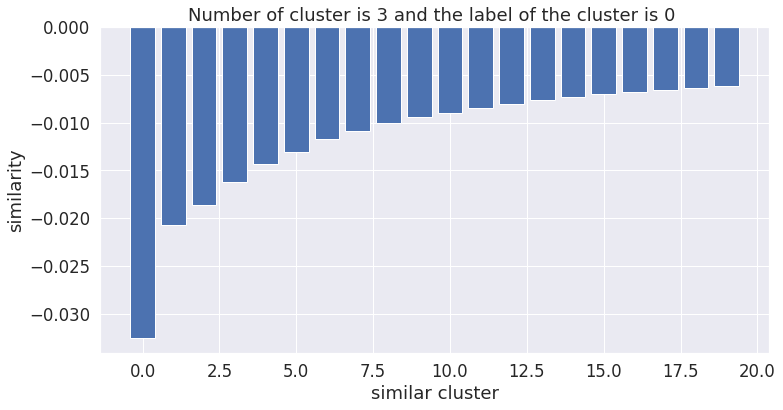

tmp_list shape is  (46, 20)  and the lenght is 20
Number of cluster is 2 and the label of the cluster is 1 


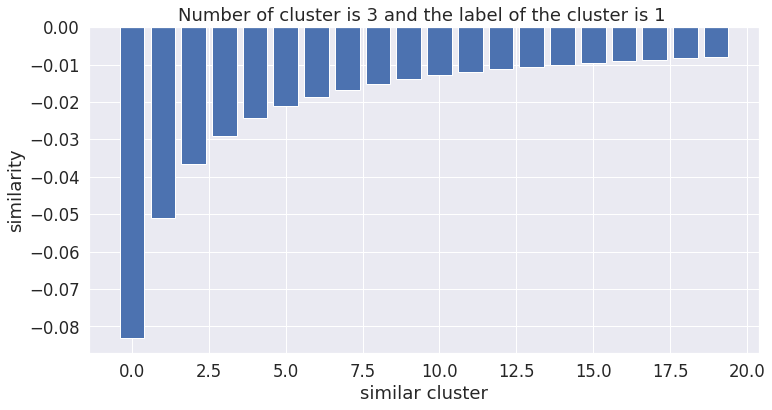

tmp_list shape is  (26, 20)  and the lenght is 20
Number of cluster is 2 and the label of the cluster is 2 


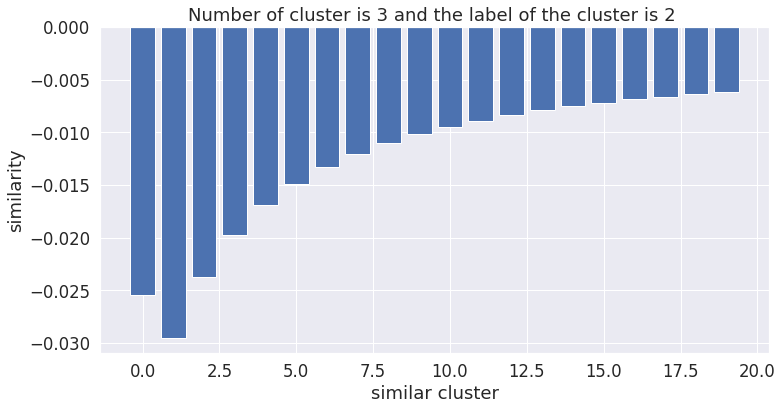

For n_clusters = 3 The average silhouette_score is : 0.25832203713630697
list of cluster words are: 
cluster 0 is ['freight', 'ships', 'emphasis', 'years', 'basil', 'chairman', 'london', 'ordering', 'delivered', 'lend', 'made', 'scarce', 'reluctant', 'sign', 'long', 'term', 'contracts', 'help', 'guarantee', 'loan', 'paid', 'subsidies', 'falling', 'also']
cluster 1 is ['demand', 'outs', 'new', 'orders', 'industry', 'say', 'instead', 'extend', 'current', 'existing', '##ts', 'ltd', 'company', 'shipyard', 'become', 'expensive', 'build']
cluster 2 is ['capacity', 'year', 'might', 'seem', 'ripe', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'experts', 'executives', 'next', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'ladies', 'said', '##christ', 'shipping', 'recalling', 'number', 'reasons', '##own', 'worry', 'repeating', 'credit', 'businesses', 'cut']
cluster 3 is ['##trip', '##ping', 'rates', 'rising', 'flood', 'bulk', 'cargo', 'many', 'people', '##s', 'co

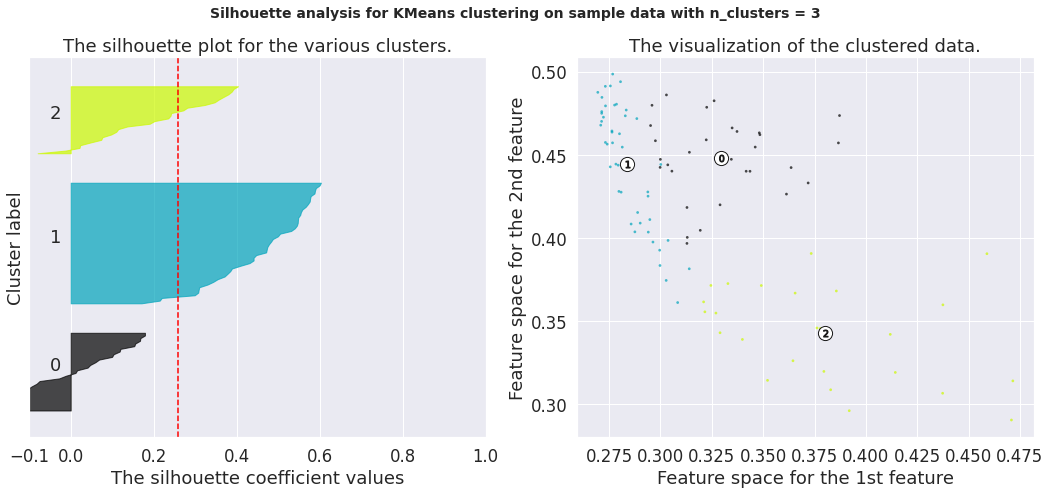

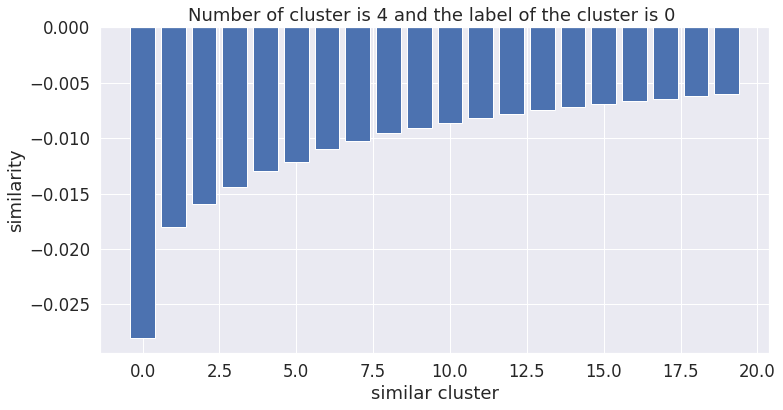

tmp_list shape is  (17, 20)  and the lenght is 20
Number of cluster is 3 and the label of the cluster is 1 


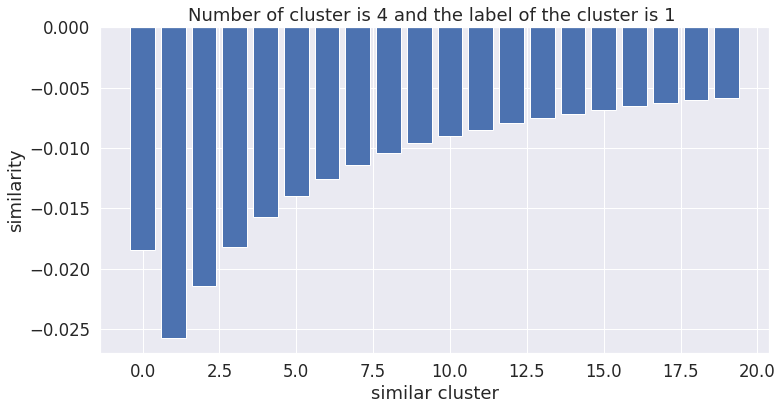

tmp_list shape is  (34, 20)  and the lenght is 20
Number of cluster is 3 and the label of the cluster is 2 


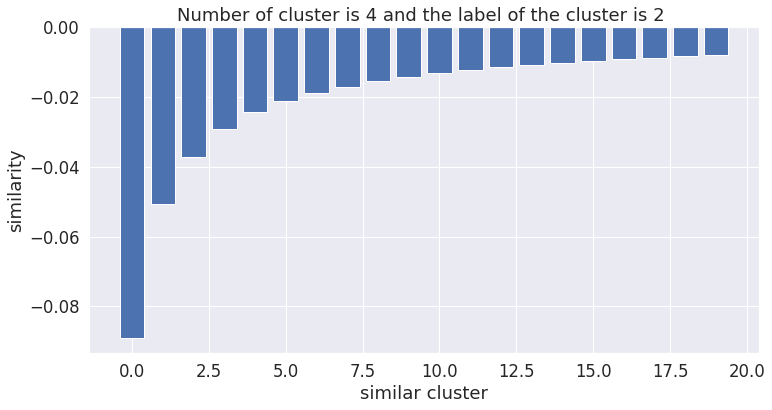

tmp_list shape is  (27, 20)  and the lenght is 20
Number of cluster is 3 and the label of the cluster is 3 


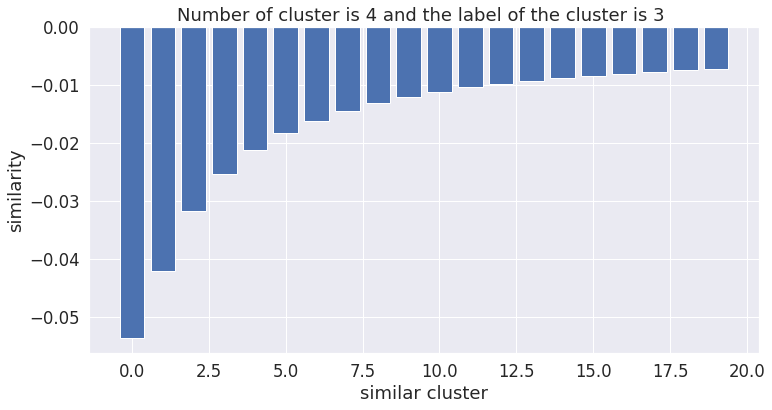

For n_clusters = 4 The average silhouette_score is : 0.21320325131682552
list of cluster words are: 
cluster 0 is ['freight', 'year', 'ladies', 'made', 'credit', 'grown', 'sign', 'subsidies', 'also']
cluster 1 is ['##trip', '##ping', 'rates', 'rising', 'flood', 'bulk', 'cargo', 'many', 'people', '##s', 'content', 'elderly', 'war', 'face', 'lifts', 'papa', '##idi', 'ltd', 'major', 'mistake', 'past', 'ship', '##ers', 'market', 'softened', 'state', 'much']
cluster 2 is ['capacity', 'might', 'seem', 'ripe', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'experts', 'executives', 'next', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'said', '##christ', 'shipping', 'recalling', 'number', 'reasons', '##own', 'worry', 'repeating', 'businesses']
cluster 3 is ['demand', 'outs', 'new', 'orders', 'industry', 'say', 'instead', 'extend', 'current', 'existing', '##ts', 'company', 'shipyard', 'become', 'expensive', 'build']
cluster 4 is ['ships', 'emphasis', 'years', 'bas

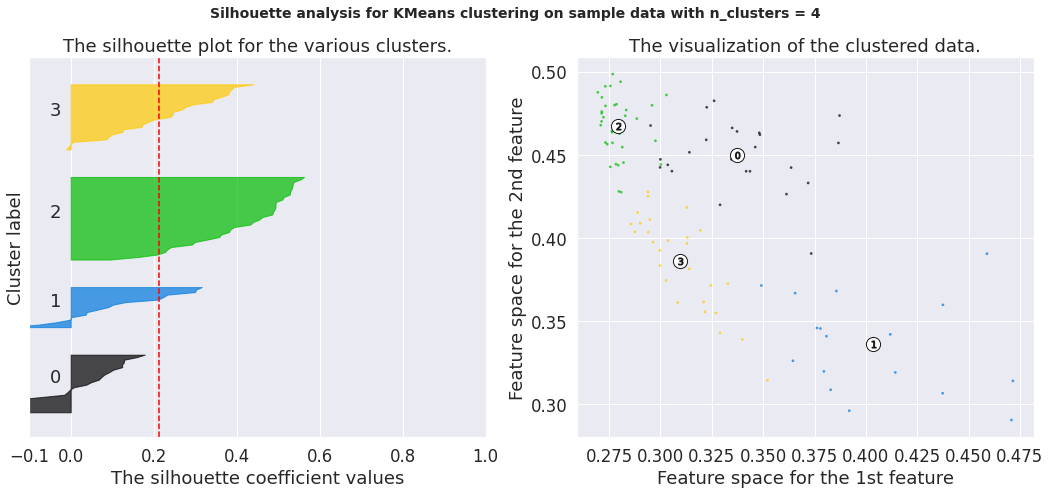

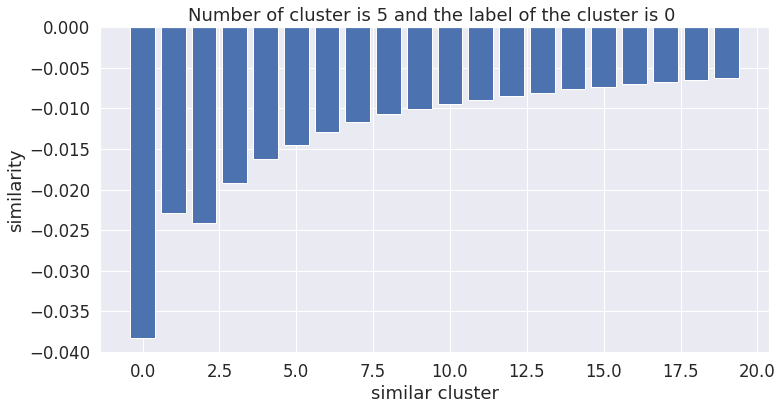

tmp_list shape is  (27, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 1 


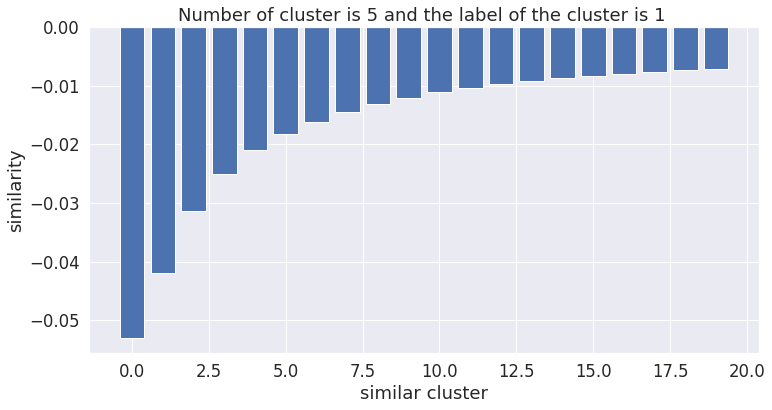

tmp_list shape is  (30, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 2 


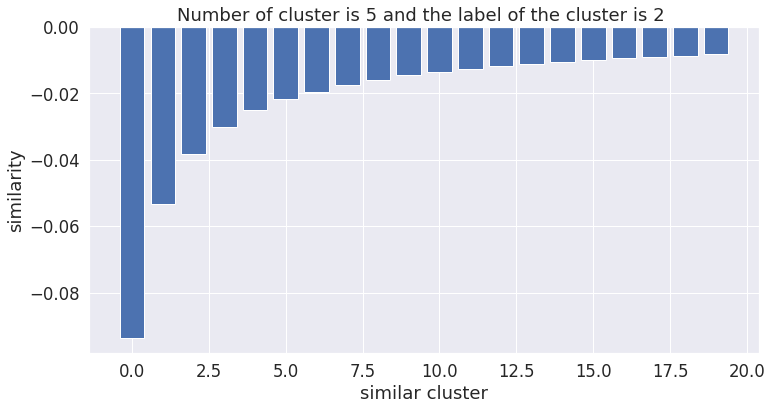

tmp_list shape is  (16, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 3 


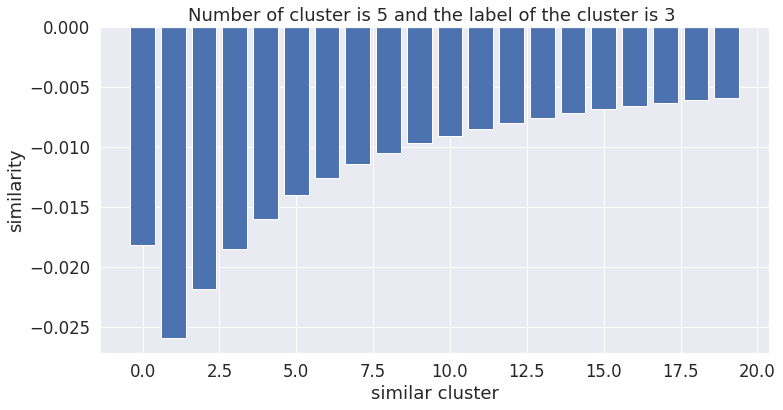

tmp_list shape is  (20, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 4 


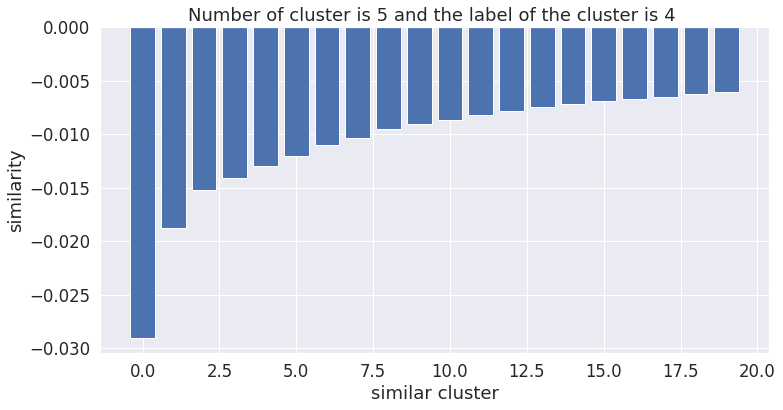

For n_clusters = 5 The average silhouette_score is : 0.2295351769221699
list of cluster words are: 
cluster 0 is ['freight', 'year', 'ladies', 'made', 'credit', 'grown', 'subsidies', 'also']
cluster 1 is ['emphasis', 'basil', 'chairman', 'london', 'delivered', 'scarce', 'reluctant', 'sign', 'long', 'contracts', 'help', 'guarantee', 'loan', 'paid', 'falling']
cluster 2 is ['##trip', 'rates', 'rising', 'flood', 'bulk', 'cargo', 'many', 'people', 'elderly', 'war', 'face', 'lifts', 'papa', '##idi', 'major', 'mistake', 'past', 'ship', '##ers', 'market', 'softened', 'state', 'much']
cluster 3 is ['demand', '##ping', 'industry', 'extend', '##s', 'content', 'existing', 'ltd', 'shipyard', 'become', 'expensive', 'build']
cluster 4 is ['capacity', 'might', 'seem', 'ripe', 'ships', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'experts', 'executives', 'next', 'years', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'said', '##christ', 'shipping', 'recalling', 'number'

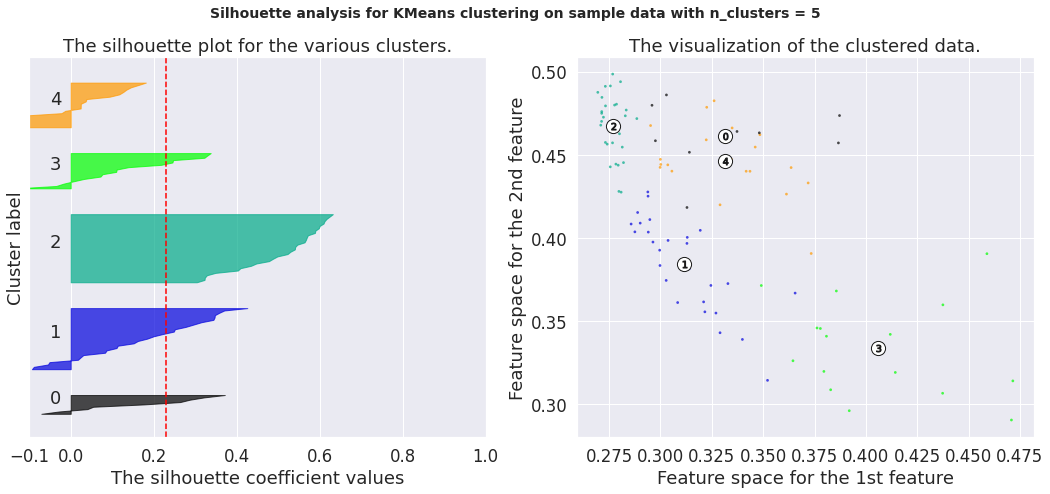

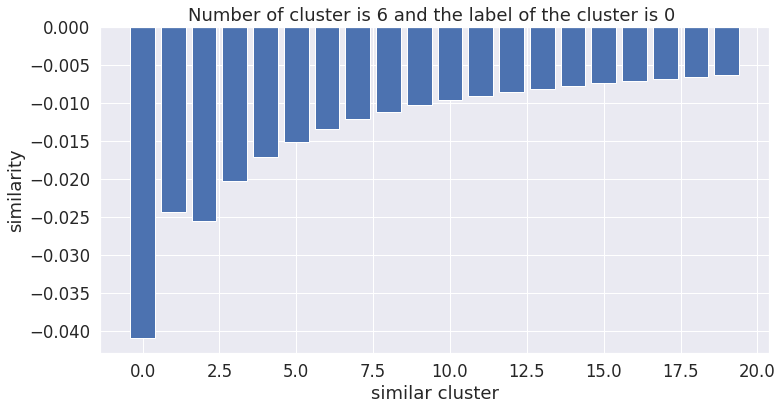

tmp_list shape is  (15, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 1 


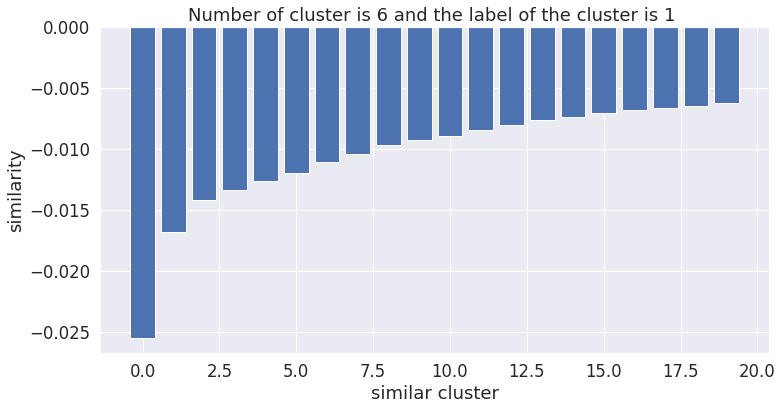

tmp_list shape is  (23, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 2 


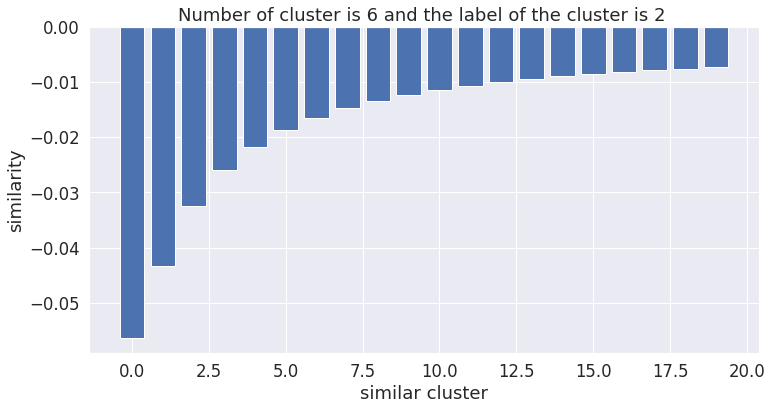

tmp_list shape is  (12, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 3 


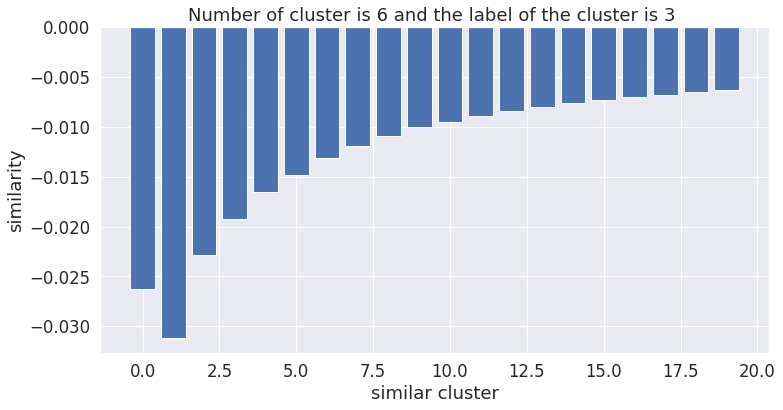

tmp_list shape is  (36, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 4 


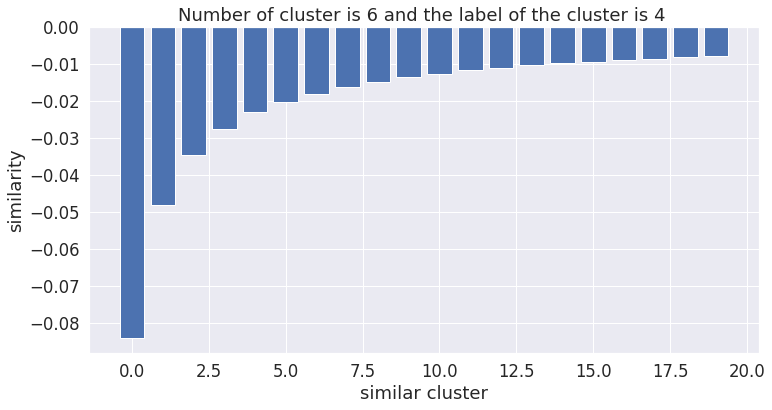

tmp_list shape is  (8, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 5 


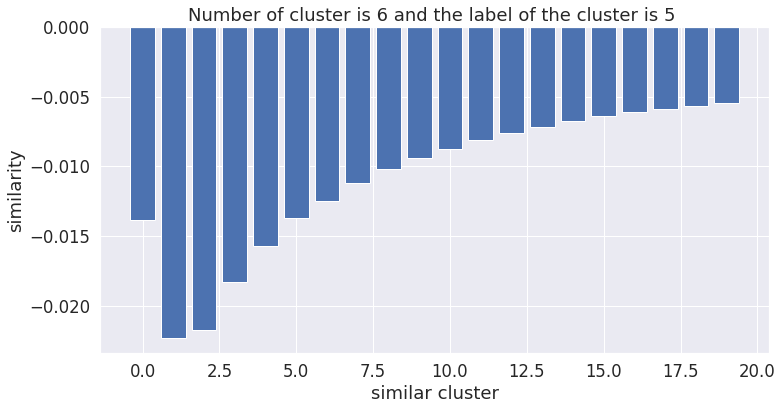

For n_clusters = 6 The average silhouette_score is : 0.2139372092579659


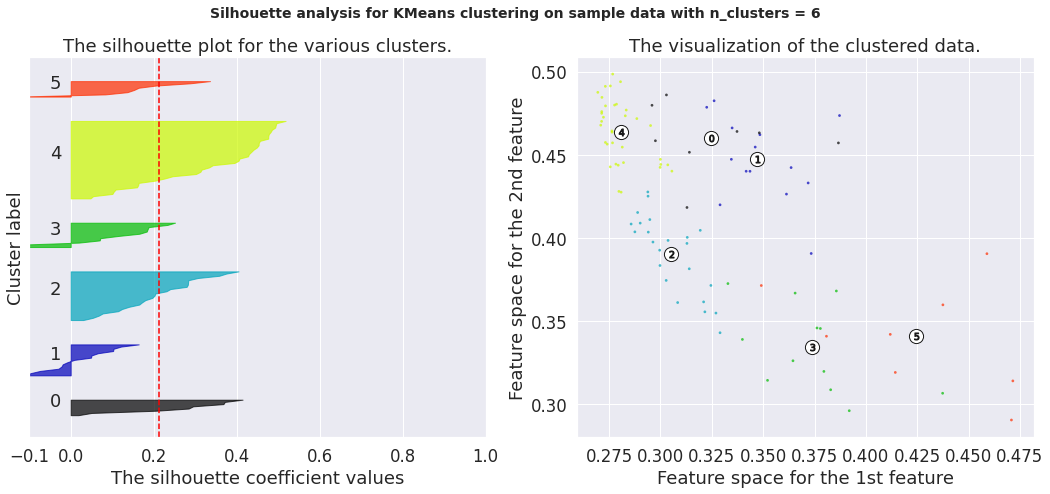

In [68]:
#clustering by kmean. it creates different clusters in each iteration

X =np.array(list(gradient_word_similarity_dict.values()))
word_list = list(gradient_word_similarity_dict.keys())
new_X = X[:,0:Max_Feature_Size]
print(new_X)
#applying sigmoid function to the features
# sigmoid  function to apply on each vector as a activation function
def sigmoid(vec_):
  z = array(vec_)
  z = z/np.linalg.norm(z)
  g = 1 / (1 + exp(-z))
  return g

for ind in range(0,new_X.shape[0]):
  new_X[ind] = sigmoid(new_X[ind])
print(new_X)

total_dict = dict()
total_centers = dict()
silhouette_avg_list = list()
# centroids_dict = dict()
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(new_X)
    # centroids = clusterer.cluster_centers_
    # centroids_dict[n_clusters] = centroids
    token_list = word_list
    tmp_dic = dict()
    for x in range(0, n_clusters):
      tmp_list = list()
      for i, j in zip(token_list, cluster_labels):
        if j == x:
          tmp_list.append(i)
      tmp_dic[x] = tmp_list
    total_dict[n_clusters] = tmp_dic
    print('list of cluster words are: ')
    for prt in tmp_dic:
      print('cluster {} is {}'.format(prt, tmp_dic[prt]))

    for w_list,ind in zip(tmp_dic.values(), tmp_dic.keys()):
      tmp_list = list()

      for w in w_list:
        tmp_list.append(gradient_word_similarity_dict[w][0:Max_Feature_Size])
      print('tmp_list shape is ', np.shape(tmp_list), ' and the lenght is', len(tmp_list[0]))
      tmp_word_list = list()
      all_distribution = list()
      for f in range(0,len(tmp_list[0])):
        for t in tmp_list:
          tmp_word_list.append(t[f])

        all_distribution.append(mean(tmp_word_list))

      print('Number of cluster is {} and the label of the cluster is {} '.format(x, ind))
      plt.figure()
      plt.bar(range(0, len(tmp_list[0])), all_distribution)
      plt.xlabel('similar cluster')
      plt.ylabel('similarity')
      plt.title('Number of cluster is {} and the label of the cluster is {} '.format(x+1, ind))
      plt.show()

      

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(new_X) + (n_clusters + 1) * 10])  


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(new_X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_avg_list.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(new_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(new_X[:, 0], new_X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    total_centers[n_clusters] = centers
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i_, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i_, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()


***************new sorting based on the similarity between words in each cluster and the centroid*************
number of clustering is 2 and the dic is {0: ['demand', 'outs', '##trip', '##ping', 'new', 'flood', 'orders', 'people', 'industry', 'say', 'instead', 'extend', 'current', '##s', 'content', 'existing', 'war', '##ts', 'basil', 'ltd', 'company', '##ers', 'reluctant', 'sign', 'long', 'guarantee', 'loan', 'subsidies', 'shipyard', 'falling', 'become', 'expensive', 'build'], 1: ['capacity', 'freight', 'rates', 'rising', 'year', 'might', 'seem', 'ripe', 'bulk', 'cargo', 'ships', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'many', 'experts', 'executives', 'emphasis', 'next', 'years', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'elderly', 'ladies', 'face', 'lifts', 'said', 'papa', '##christ', '##idi', 'chairman', 'major', 'shipping', 'london', 'recalling', 'mistake', 'past', 'number', 'reasons', 'ship', '##own', 'worry', 'repeating', 'ordering', 'deli

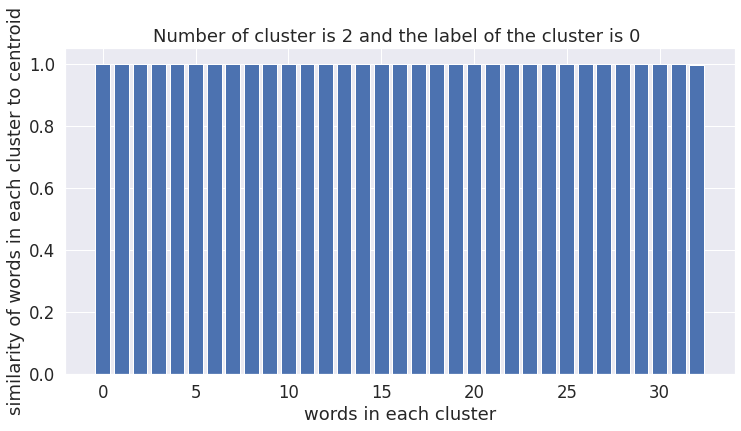

sorted is:  [('fleet', 0.9999188893201609), ('world', 0.99991239120352), ('reasons', 0.9998977829417606), ('repeating', 0.9998722996423803), ('##own', 0.9998598100248923), ('shipping', 0.9998390819754557), ('1980', 0.999837233318678), ('1970', 0.9998213274919653), ('##christ', 0.99981767112429), ('worry', 0.9998152166464995), ('said', 0.9998148283984007), ('market', 0.9998004750807045), ('tanker', 0.9997955280953625), ('number', 0.9997949368490932), ('early', 0.9997917193326341), ('recalling', 0.9997847145259109), ('case', 0.9997828400121722), ('next', 0.9997774700280834), ('might', 0.999764565047519), ('freighter', 0.9997594362419907), ('finding', 0.9997590492849054), ('executives', 0.9997480444659926), ('rising', 0.9997345200875803), ('seem', 0.9997194979021001), ('face', 0.9997101196443542), ('bulk', 0.9997048478636817), ('lifts', 0.9996851778872969), ('experts', 0.9996776534331204), ('ways', 0.9996712050646845), ('ship', 0.999660602941593), ('reminiscent', 0.999655332744985), ('eld

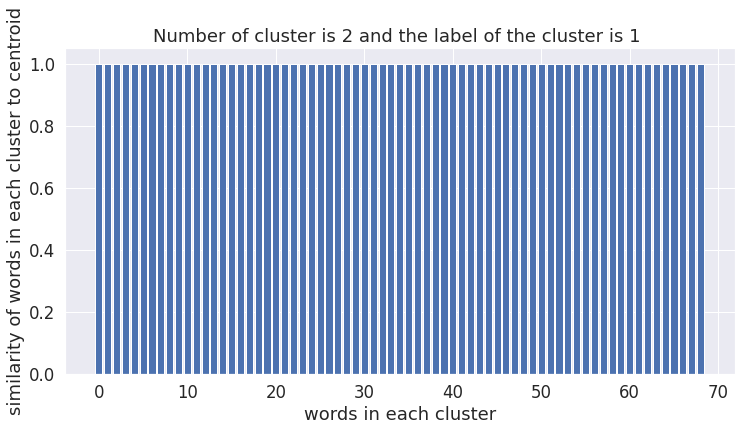

************************************************************************************
number of clustering is 3 and the dic is {0: ['freight', 'year', 'cargo', 'ships', 'emphasis', 'years', 'ladies', 'basil', 'chairman', 'major', 'london', 'mistake', 'ordering', 'delivered', 'lend', 'made', 'credit', 'scarce', 'grown', 'sign', 'long', 'term', 'contracts', 'help', 'guarantee', 'loan', 'paid', 'subsidies', 'falling', 'also'], 1: ['capacity', 'rates', 'rising', 'might', 'seem', 'ripe', 'bulk', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'many', 'experts', 'executives', 'next', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'elderly', 'face', 'lifts', 'said', 'papa', '##christ', '##idi', 'shipping', 'recalling', 'past', 'number', 'reasons', 'ship', '##own', 'worry', 'repeating', 'market', 'softened', 'businesses', 'state', 'much', 'cut'], 2: ['demand', 'outs', '##trip', '##ping', 'new', 'flood', 'orders', 'people', 'industry', 'say', 'instead', 'extend', 'cu

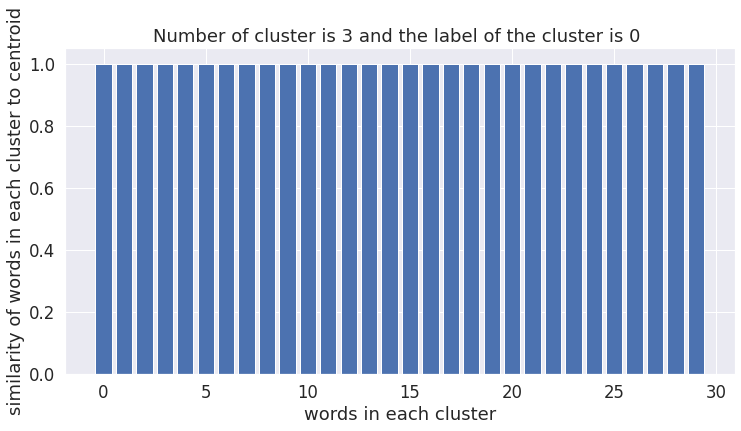

sorted is:  [('1980', 0.9999580278245107), ('fleet', 0.9999265713669383), ('tanker', 0.9999259349549786), ('##christ', 0.9999159660131226), ('world', 0.9999091195449731), ('reasons', 0.9999078517034448), ('freighter', 0.9999018203820829), ('worry', 0.9998986535857969), ('finding', 0.9998951896662983), ('recalling', 0.9998932780946357), ('1970', 0.9998855277067004), ('said', 0.9998800317973771), ('executives', 0.9998762846529696), ('early', 0.9998732316296717), ('next', 0.9998687570147389), ('repeating', 0.9998304158730853), ('##own', 0.9998303908165636), ('shipping', 0.9998243142039005), ('number', 0.9998200357933577), ('might', 0.9998129477295741), ('ways', 0.9997902439789209), ('ship', 0.9997881037769828), ('rising', 0.999767172706731), ('lifts', 0.9997483984047136), ('case', 0.9997299109891861), ('seem', 0.9997185558704661), ('market', 0.9997017524689344), ('experts', 0.9996992950173195), ('bulk', 0.9996895474822418), ('face', 0.9996796971776024), ('ripe', 0.9996485081374593), ('sta

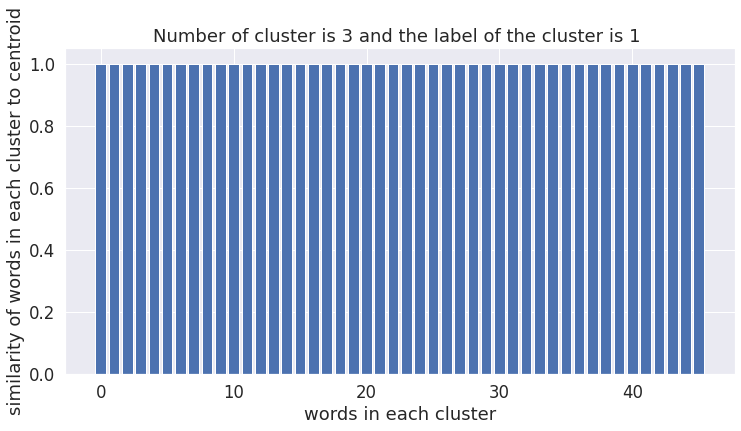

sorted is:  [('existing', 0.9998310617872449), ('content', 0.9997729265608402), ('become', 0.9997098619710465), ('industry', 0.9996249312287024), ('demand', 0.9996232140464077), ('say', 0.9995536737735833), ('##trip', 0.999522544084591), ('people', 0.9995168568624905), ('war', 0.9994996381010949), ('flood', 0.9994536905487629), ('##ping', 0.999435528002621), ('##s', 0.9993322209175658), ('instead', 0.9993262470800351), ('##ers', 0.9993019303208501), ('outs', 0.9992735103296565), ('current', 0.9992100652271705), ('shipyard', 0.9991849345829168), ('build', 0.9990872558845922), ('reluctant', 0.9989597976385184), ('extend', 0.9989241777765563), ('company', 0.9986413367651554), ('expensive', 0.9985992265619059), ('orders', 0.9985973947996281), ('ltd', 0.9983061603948531), ('##ts', 0.9982945848658509), ('new', 0.9976529566943306)]
cluster 2  ['existing', 'content', 'become', 'industry', 'demand', 'say', '##trip', 'people', 'war', 'flood', '##ping', '##s', 'instead', '##ers', 'outs', 'current

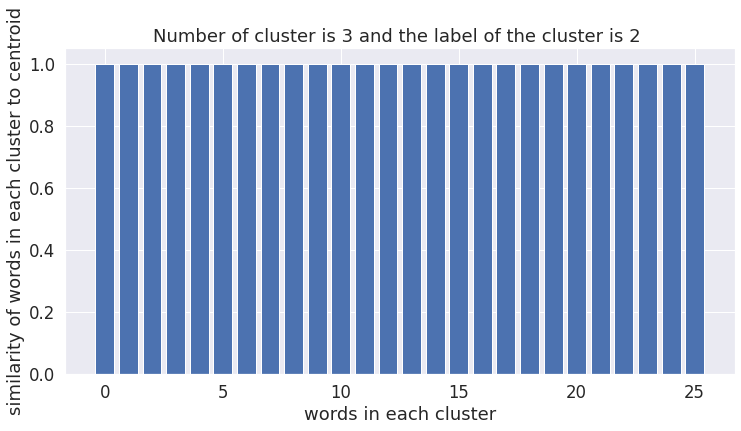

************************************************************************************
number of clustering is 4 and the dic is {0: ['freight', 'ships', 'emphasis', 'years', 'basil', 'chairman', 'london', 'ordering', 'delivered', 'lend', 'made', 'scarce', 'reluctant', 'sign', 'long', 'term', 'contracts', 'help', 'guarantee', 'loan', 'paid', 'subsidies', 'falling', 'also'], 1: ['demand', 'outs', 'new', 'orders', 'industry', 'say', 'instead', 'extend', 'current', 'existing', '##ts', 'ltd', 'company', 'shipyard', 'become', 'expensive', 'build'], 2: ['capacity', 'year', 'might', 'seem', 'ripe', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'experts', 'executives', 'next', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'ladies', 'said', '##christ', 'shipping', 'recalling', 'number', 'reasons', '##own', 'worry', 'repeating', 'credit', 'businesses', 'cut'], 3: ['##trip', '##ping', 'rates', 'rising', 'flood', 'bulk', 'cargo', 'many', 'people', '##s', 'content', 'el

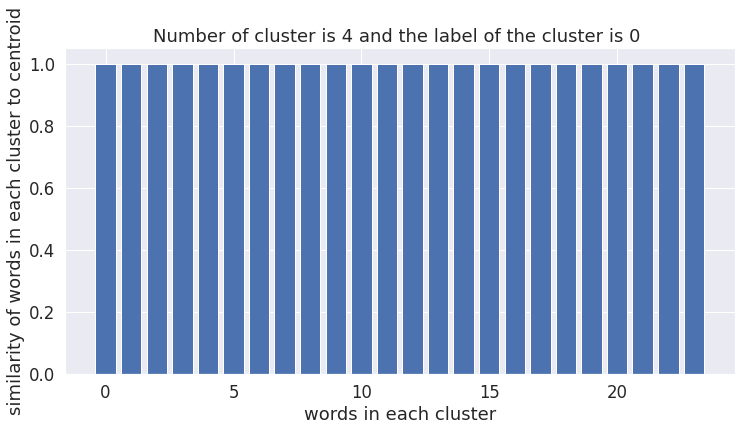

sorted is:  [('say', 0.9997803424895484), ('existing', 0.9997073993530146), ('become', 0.9996490986768268), ('demand', 0.9996065249530007), ('industry', 0.9995919601777572), ('current', 0.999407306193029), ('outs', 0.9992442662011115), ('extend', 0.9991832202072454), ('instead', 0.9991424393466992), ('company', 0.99912844942886), ('shipyard', 0.9991260634016293), ('build', 0.9990057994120219), ('orders', 0.9989086635190373), ('##ts', 0.9988215915441119), ('expensive', 0.9985012360097463), ('ltd', 0.9981522091732004), ('new', 0.9980165533699815)]
cluster 1  ['say', 'existing', 'become', 'demand', 'industry', 'current', 'outs', 'extend', 'instead', 'company', 'shipyard', 'build', 'orders', '##ts', 'expensive', 'ltd', 'new']
Number of cluster is 4 and the label of the cluster is 1 


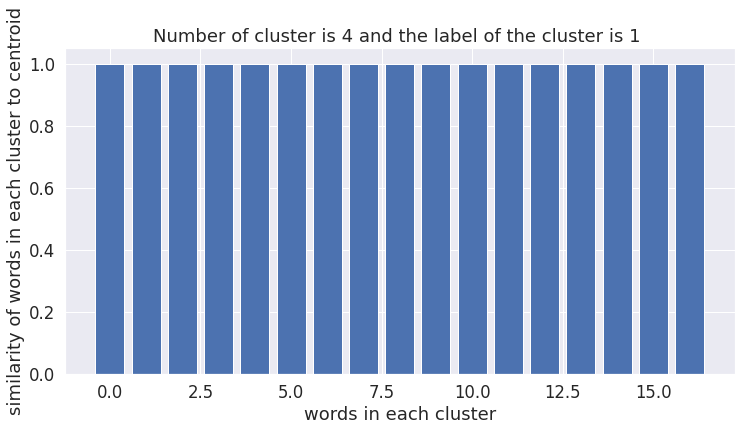

sorted is:  [('1970', 0.9999682152942729), ('world', 0.9999494072597741), ('recalling', 0.9999299652252955), ('reasons', 0.9999292683166409), ('might', 0.9999277673880991), ('next', 0.9999248084393695), ('number', 0.9999238059023051), ('early', 0.9999180640326233), ('finding', 0.9999141059622593), ('said', 0.9999131776384592), ('tanker', 0.999906964407527), ('ways', 0.999895826159553), ('case', 0.9998803470632667), ('fleet', 0.9998779727813528), ('freighter', 0.999869550709327), ('repeating', 0.9998670644089377), ('seem', 0.9998660776016132), ('shipping', 0.9998600478140781), ('1980', 0.9998596389810591), ('experts', 0.9998509171943167), ('worry', 0.9998270304376179), ('ripe', 0.9998160674949872), ('##own', 0.9998155263638879), ('##christ', 0.9997568124843862), ('time', 0.9997456279142343), ('executives', 0.9997200044811149), ('reminiscent', 0.9996873370040205), ('life', 0.999682822231316), ('capacity', 0.9996361470980654), ('businesses', 0.9996264362678846), ('credit', 0.9993889006068

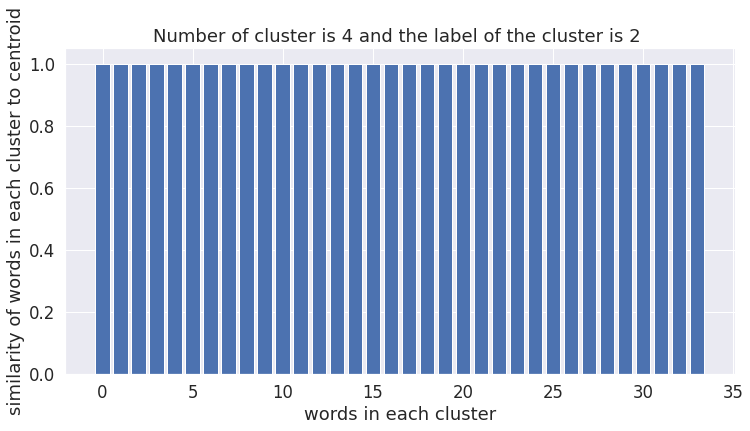

sorted is:  [('past', 0.9999323178189098), ('rates', 0.9999161371492664), ('lifts', 0.9998937251019464), ('face', 0.9998409038553369), ('rising', 0.9998306327929648), ('##idi', 0.9998124019144787), ('flood', 0.9998120032215173), ('ship', 0.9997573633827272), ('softened', 0.9997431061200839), ('papa', 0.9997230437937848), ('people', 0.9997004698487753), ('##trip', 0.9996790814905232), ('war', 0.9996447058366627), ('bulk', 0.9996297012778017), ('much', 0.9996143688097788), ('market', 0.9996113027191171), ('##ers', 0.9996035375212395), ('state', 0.9996024884865654), ('mistake', 0.9995916017284423), ('content', 0.9995855736676736), ('elderly', 0.9995585635423491), ('major', 0.999516365527453), ('grown', 0.9993986888923202), ('##s', 0.9993662723929528), ('cargo', 0.9993304668322255), ('many', 0.9992533954549345), ('##ping', 0.9991079104206618)]
cluster 3  ['past', 'rates', 'lifts', 'face', 'rising', '##idi', 'flood', 'ship', 'softened', 'papa', 'people', '##trip', 'war', 'bulk', 'much', 'ma

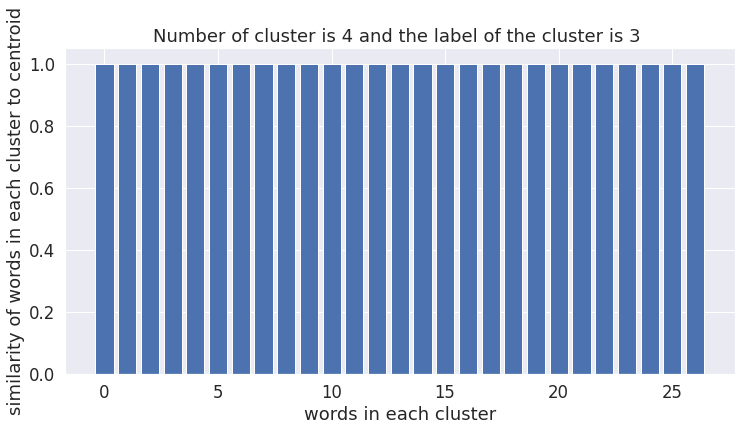

************************************************************************************
number of clustering is 5 and the dic is {0: ['freight', 'year', 'ladies', 'made', 'credit', 'grown', 'sign', 'subsidies', 'also'], 1: ['##trip', '##ping', 'rates', 'rising', 'flood', 'bulk', 'cargo', 'many', 'people', '##s', 'content', 'elderly', 'war', 'face', 'lifts', 'papa', '##idi', 'ltd', 'major', 'mistake', 'past', 'ship', '##ers', 'market', 'softened', 'state', 'much'], 2: ['capacity', 'might', 'seem', 'ripe', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'experts', 'executives', 'next', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'said', '##christ', 'shipping', 'recalling', 'number', 'reasons', '##own', 'worry', 'repeating', 'businesses'], 3: ['demand', 'outs', 'new', 'orders', 'industry', 'say', 'instead', 'extend', 'current', 'existing', '##ts', 'company', 'shipyard', 'become', 'expensive', 'build'], 4: ['ships', 'emphasis', 'years', 'basil', 'chairman', 'lo

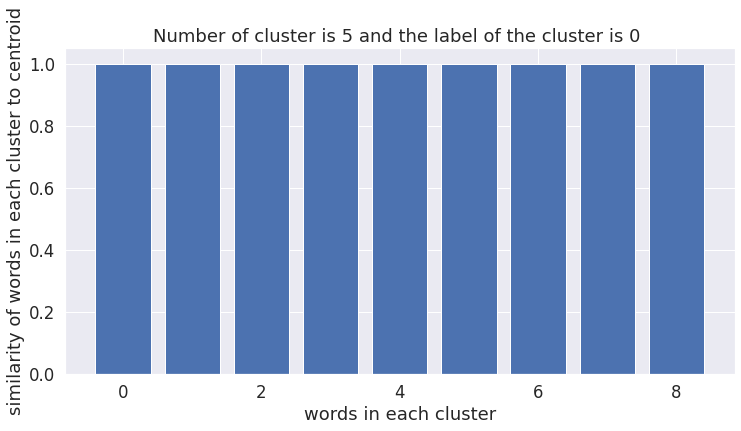

sorted is:  [('past', 0.999939354476951), ('rates', 0.9999041937828317), ('lifts', 0.9998724461551795), ('rising', 0.9998401039597516), ('flood', 0.9998397646705328), ('face', 0.9998044168843211), ('##idi', 0.9998042214625672), ('softened', 0.9997673148693086), ('ship', 0.9997585254089981), ('papa', 0.9997289863885034), ('people', 0.9996952358447031), ('much', 0.9996644081295475), ('##trip', 0.9996569277336267), ('##ers', 0.9996482392197992), ('war', 0.9996412069255174), ('bulk', 0.9996177394756327), ('mistake', 0.9996005901672874), ('content', 0.9995976591440796), ('state', 0.9995965613248099), ('market', 0.9995845334460469), ('elderly', 0.9995018142588465), ('major', 0.9994667514273926), ('##s', 0.9994038634978885), ('cargo', 0.9993034220393704), ('many', 0.999253307013227), ('##ping', 0.9991723600157543), ('ltd', 0.9980393525098433)]
cluster 1  ['past', 'rates', 'lifts', 'rising', 'flood', 'face', '##idi', 'softened', 'ship', 'papa', 'people', 'much', '##trip', '##ers', 'war', 'bulk

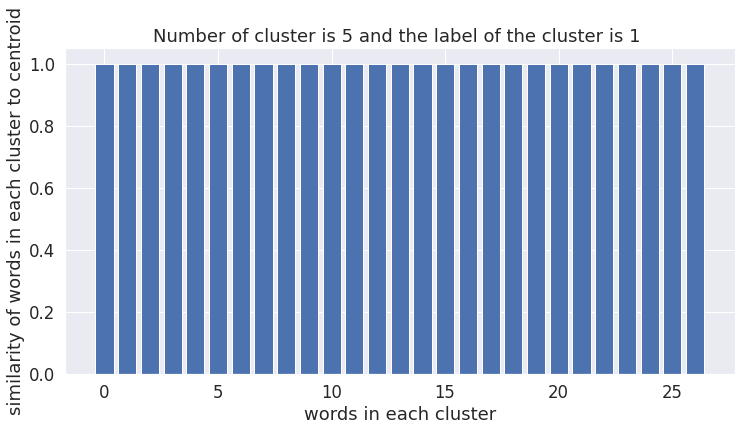

sorted is:  [('1970', 0.9999697301837863), ('recalling', 0.9999525504795015), ('early', 0.9999524546810825), ('next', 0.9999510069230021), ('might', 0.9999448437424897), ('finding', 0.9999445552180815), ('world', 0.9999441203578034), ('said', 0.9999354544268996), ('tanker', 0.9999337207795012), ('ways', 0.9999260339523424), ('number', 0.9999243702541016), ('reasons', 0.9999111826567245), ('freighter', 0.999903148951856), ('1980', 0.9998917956942343), ('shipping', 0.999868632953328), ('experts', 0.9998600683746811), ('worry', 0.9998514806390298), ('fleet', 0.9998508155133674), ('case', 0.9998457849408776), ('seem', 0.9998409148680998), ('ripe', 0.9998266755018378), ('repeating', 0.999822417287645), ('##christ', 0.9997868444313333), ('##own', 0.999764830845331), ('executives', 0.9997472436054362), ('time', 0.9997441776705013), ('life', 0.999691621041775), ('businesses', 0.9996602586995015), ('capacity', 0.9996492296128358), ('reminiscent', 0.9996000781438938)]
cluster 2  ['1970', 'recall

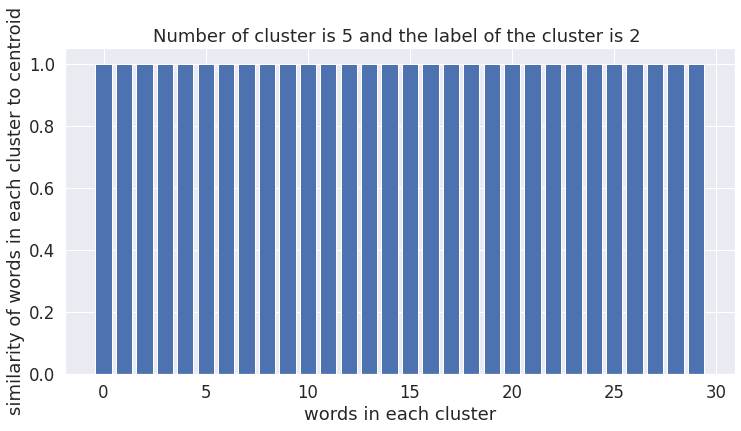

sorted is:  [('say', 0.9998058023820807), ('existing', 0.9996804681932848), ('become', 0.9996443680119651), ('demand', 0.9995902881111478), ('industry', 0.9995524877428346), ('current', 0.999424135497029), ('outs', 0.9992870088484204), ('company', 0.9992174521803623), ('extend', 0.9992064573945416), ('instead', 0.9991452100794483), ('shipyard', 0.9990570950025635), ('##ts', 0.9989505921344305), ('orders', 0.9989057027987022), ('build', 0.9988824863873651), ('expensive', 0.9984570301281823), ('new', 0.9980484359987277)]
cluster 3  ['say', 'existing', 'become', 'demand', 'industry', 'current', 'outs', 'company', 'extend', 'instead', 'shipyard', '##ts', 'orders', 'build', 'expensive', 'new']
Number of cluster is 5 and the label of the cluster is 3 


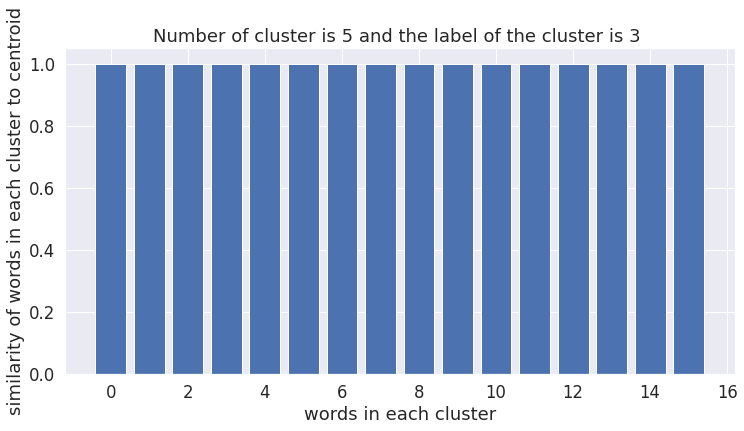

sorted is:  [('years', 0.9997206110690414), ('term', 0.999703446305455), ('lend', 0.9995573743718581), ('ordering', 0.9995206543074832), ('falling', 0.9994451342878172), ('ships', 0.999373612171253), ('guarantee', 0.9993107096499247), ('cut', 0.9992175735351178), ('delivered', 0.9991734602673082), ('paid', 0.9991600484091822), ('chairman', 0.9991177900939612), ('scarce', 0.9990895361161296), ('emphasis', 0.9990441006362187), ('reluctant', 0.9990171559684767), ('loan', 0.998988858245818), ('help', 0.9988605247219515), ('basil', 0.9988370265708658), ('contracts', 0.9987647794663865), ('long', 0.998488331559188), ('london', 0.9983956079017822)]
cluster 4  ['years', 'term', 'lend', 'ordering', 'falling', 'ships', 'guarantee', 'cut', 'delivered', 'paid', 'chairman', 'scarce', 'emphasis', 'reluctant', 'loan', 'help', 'basil', 'contracts', 'long', 'london']
Number of cluster is 5 and the label of the cluster is 4 


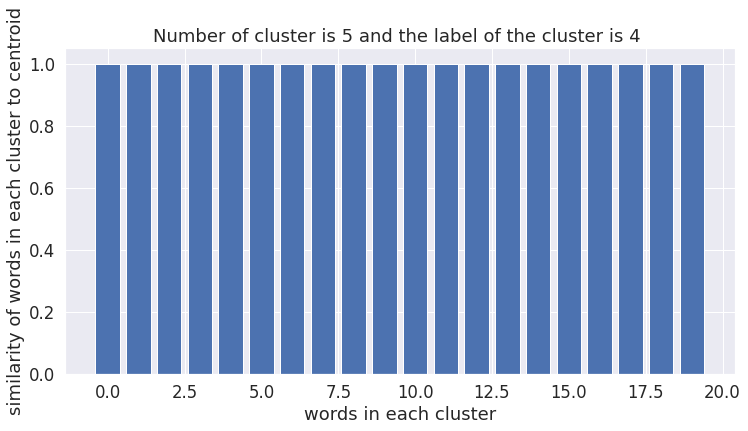

************************************************************************************
number of clustering is 6 and the dic is {0: ['freight', 'year', 'ladies', 'made', 'credit', 'grown', 'subsidies', 'also'], 1: ['emphasis', 'basil', 'chairman', 'london', 'delivered', 'scarce', 'reluctant', 'sign', 'long', 'contracts', 'help', 'guarantee', 'loan', 'paid', 'falling'], 2: ['##trip', 'rates', 'rising', 'flood', 'bulk', 'cargo', 'many', 'people', 'elderly', 'war', 'face', 'lifts', 'papa', '##idi', 'major', 'mistake', 'past', 'ship', '##ers', 'market', 'softened', 'state', 'much'], 3: ['demand', '##ping', 'industry', 'extend', '##s', 'content', 'existing', 'ltd', 'shipyard', 'become', 'expensive', 'build'], 4: ['capacity', 'might', 'seem', 'ripe', 'ships', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'experts', 'executives', 'next', 'years', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'said', '##christ', 'shipping', 'recalling', 'number', 'reasons', '##own

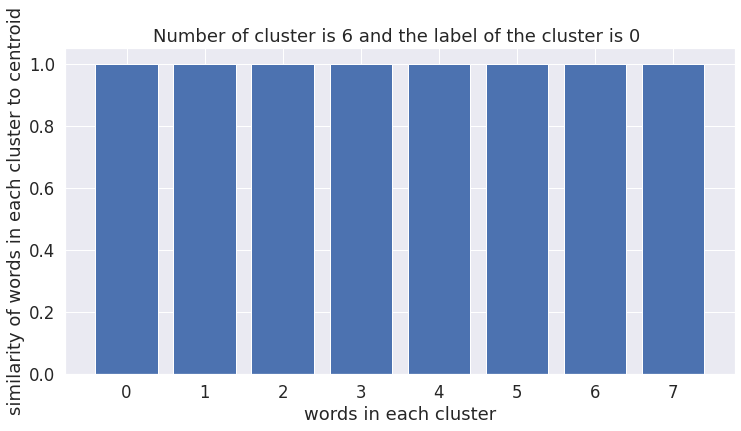

sorted is:  [('falling', 0.9995014947768548), ('guarantee', 0.9994695788971018), ('reluctant', 0.999215008773996), ('loan', 0.9991959253477866), ('delivered', 0.999162519200417), ('paid', 0.9991610983101222), ('emphasis', 0.9991564610496932), ('scarce', 0.9990240921495913), ('chairman', 0.999017699374358), ('basil', 0.9990157024540801), ('help', 0.9989480431236419), ('contracts', 0.9988259208980075), ('long', 0.9985640808921296), ('london', 0.9985457125628249), ('sign', 0.998259904851169)]
cluster 1  ['falling', 'guarantee', 'reluctant', 'loan', 'delivered', 'paid', 'emphasis', 'scarce', 'chairman', 'basil', 'help', 'contracts', 'long', 'london', 'sign']
Number of cluster is 6 and the label of the cluster is 1 


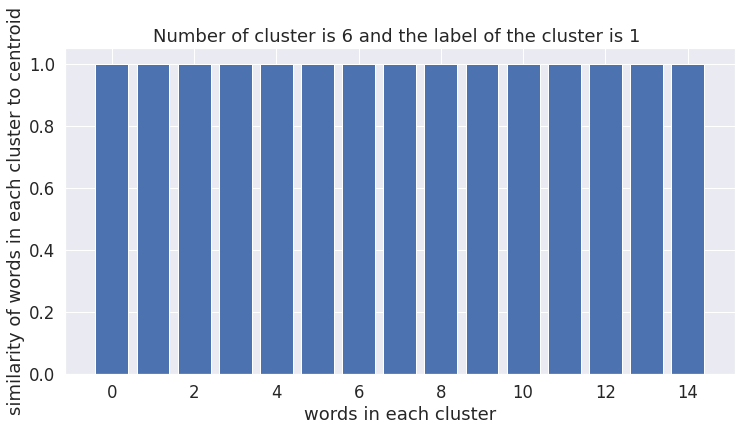

sorted is:  [('past', 0.9999270099943984), ('lifts', 0.9999266498310767), ('rates', 0.9999229543269293), ('face', 0.9998678311960137), ('rising', 0.9998477220058886), ('##idi', 0.999822894785133), ('ship', 0.9998047181838486), ('flood', 0.9997718466900921), ('papa', 0.999748352812124), ('softened', 0.9997275667587089), ('market', 0.9996604604534632), ('bulk', 0.999651460714856), ('people', 0.9996413986723838), ('##trip', 0.9996250292022024), ('state', 0.9996191526186534), ('much', 0.9996131652400614), ('mistake', 0.9995903128086041), ('elderly', 0.9995872436756663), ('war', 0.9995766398181342), ('##ers', 0.9995687283115343), ('major', 0.9995085839293711), ('cargo', 0.9993297296115231), ('many', 0.9992655593924461)]
cluster 2  ['past', 'lifts', 'rates', 'face', 'rising', '##idi', 'ship', 'flood', 'papa', 'softened', 'market', 'bulk', 'people', '##trip', 'state', 'much', 'mistake', 'elderly', 'war', '##ers', 'major', 'cargo', 'many']
Number of cluster is 6 and the label of the cluster is

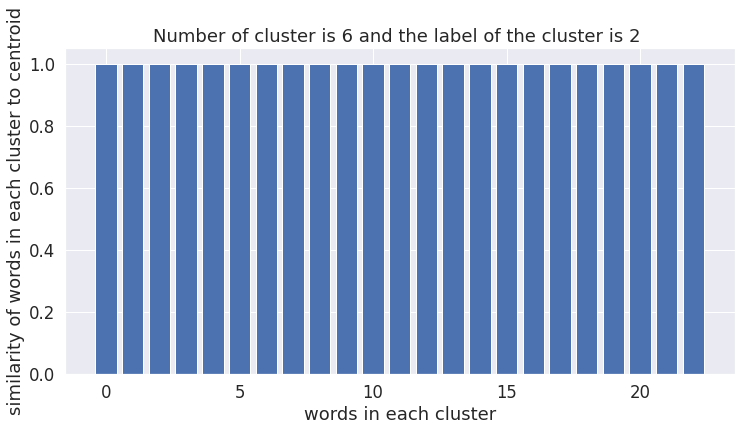

sorted is:  [('existing', 0.9998107537022883), ('demand', 0.999723504404909), ('##ping', 0.9997136918928393), ('industry', 0.9996938875073872), ('content', 0.9996674269798399), ('become', 0.9996650055320727), ('##s', 0.9993619666813383), ('shipyard', 0.9993590261578583), ('build', 0.9992708322296564), ('extend', 0.9989737072264027), ('expensive', 0.9987117966499706), ('ltd', 0.9986545460050983)]
cluster 3  ['existing', 'demand', '##ping', 'industry', 'content', 'become', '##s', 'shipyard', 'build', 'extend', 'expensive', 'ltd']
Number of cluster is 6 and the label of the cluster is 3 


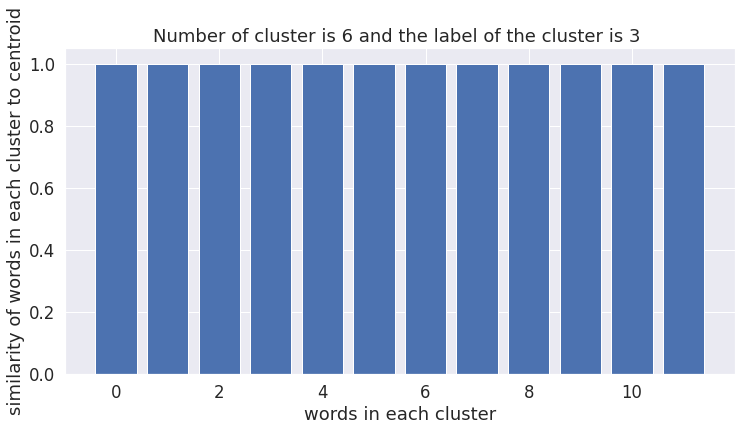

sorted is:  [('world', 0.9999552803974575), ('1970', 0.9999528238291966), ('early', 0.9999471046577527), ('next', 0.9999360400264272), ('might', 0.9999350071802152), ('recalling', 0.9999307307081353), ('said', 0.9999292679256314), ('reasons', 0.9999199042918305), ('finding', 0.9999183488146052), ('number', 0.999912806734558), ('tanker', 0.9999127073360772), ('ways', 0.9998955522536869), ('shipping', 0.9998910554290761), ('1980', 0.999887632910109), ('freighter', 0.9998754748600229), ('experts', 0.9998656634839932), ('fleet', 0.9998566630562182), ('worry', 0.9998536392032136), ('case', 0.9998453309274975), ('repeating', 0.9998287822959934), ('seem', 0.9998284476475292), ('ripe', 0.999812326242065), ('##christ', 0.9997947434676479), ('##own', 0.999768795073307), ('executives', 0.9997447437016033), ('life', 0.999719581021187), ('time', 0.999717131821865), ('capacity', 0.9996817342176897), ('businesses', 0.9996644465453312), ('reminiscent', 0.9996118375769126), ('term', 0.9995808823973229)

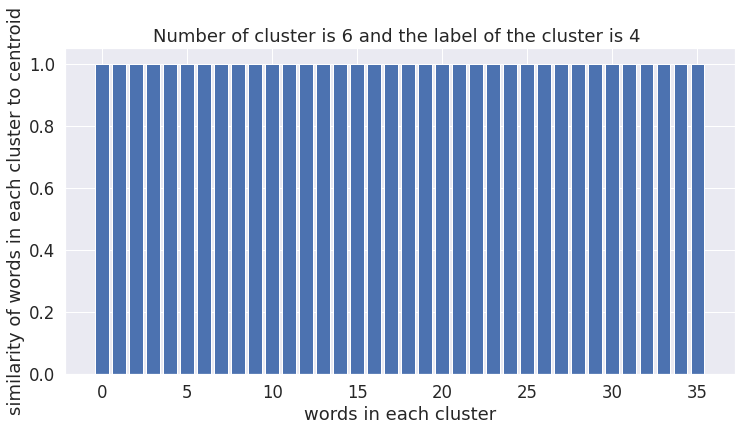

sorted is:  [('say', 0.9998210159974243), ('current', 0.999778139456029), ('##ts', 0.9995707966072394), ('outs', 0.9994383752598753), ('company', 0.9994022460352057), ('instead', 0.9990938789124524), ('orders', 0.9988901981702611), ('new', 0.9983671722422062)]
cluster 5  ['say', 'current', '##ts', 'outs', 'company', 'instead', 'orders', 'new']
Number of cluster is 6 and the label of the cluster is 5 


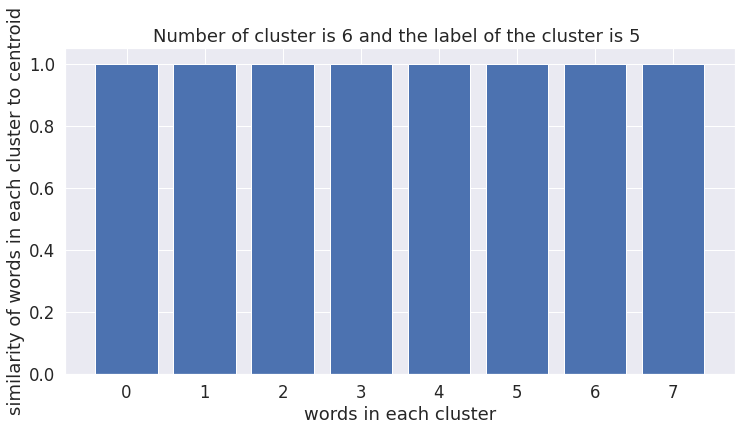

************************************************************************************


In [69]:

print('***************new sorting based on the similarity between words in each cluster and the centroid*************')
# centers is the centroid for each cluster. size is (#cluster, #dimension_features)
# gradient_word_similarity_dict is a dictionary that has all word as the key and their embedding as value after getting gradiet from them
total_clusters_sorted = dict()
total_clusters_with_similarities = dict()
for h in range_n_clusters:
  temp1_dict = dict()
  print('number of clustering is {} and the dic is {}'.format(h,total_dict[h]))
  for clus in total_dict[h]:
    temp_dict = dict()
    for w_ in total_dict[h][clus]:
      # print(clus, ' is ', w_)
      # print('similarity is ', cosine_similarity([sigmoid(gradient_word_similarity_dict[w_])[0:Max_Feature_Size]],[total_centers[h][clus][0:Max_Feature_Size]])[0][0])
      temp_dict[w_] = cosine_similarity([sigmoid(gradient_word_similarity_dict[w_])[0:Max_Feature_Size]],[total_centers[h][clus][0:Max_Feature_Size]])[0][0]
    # print(temp_dict)
    temp = sorted(temp_dict.items(), key=lambda kv: kv[1], reverse=True)
    total_clusters_with_similarities[(h, clus)] = temp
    final_list = list()
    value_sim= list()
    for r in temp:
      final_list.append(r[0])
      value_sim.append(r[1])
    print('sorted is: ', temp)
    print('cluster {} '.format(clus), final_list)
    temp1_dict[clus] = stop_word_remover(final_list, stopwords)


    print('Number of cluster is {} and the label of the cluster is {} '.format(h, clus))
    plt.figure()
    plt.bar(range(0, len(value_sim)), value_sim)
    plt.xlabel('words in each cluster')
    plt.ylabel('similarity of words in each cluster to centroid')
    plt.title('Number of cluster is {} and the label of the cluster is {} '.format(h, clus))
    plt.show()
  total_clusters_sorted[h] = temp1_dict
  print('************************************************************************************')


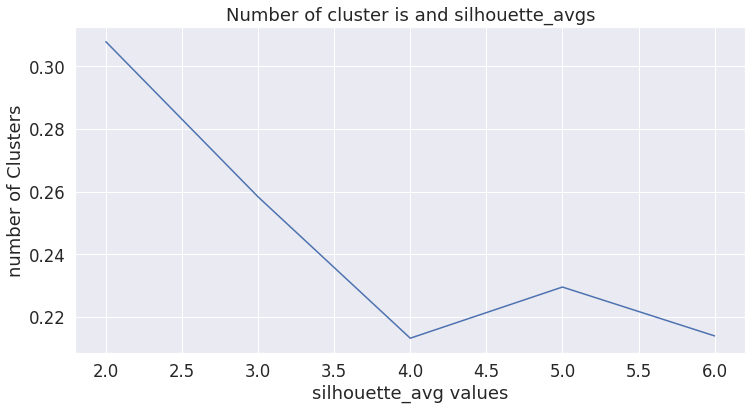

In [70]:
#plot silluheitte function for different clusters
plt.figure()
plt.plot(range_n_clusters, silhouette_avg_list)
# plt.plot(range(2, len(silhouette_avg_list)+2), silhouette_avg_list)

plt.xlabel('silhouette_avg values')
plt.ylabel('number of Clusters')
plt.title('Number of cluster is and silhouette_avgs')
plt.show()

In [71]:
print('Items in each clusters: ', total_dict)
print('Sorted items in each clusters: ', total_clusters_sorted)
print(total_clusters_sorted.values())


Items in each clusters:  {2: {0: ['demand', 'outs', '##trip', '##ping', 'new', 'flood', 'orders', 'people', 'industry', 'say', 'instead', 'extend', 'current', '##s', 'content', 'existing', 'war', '##ts', 'basil', 'ltd', 'company', '##ers', 'reluctant', 'sign', 'long', 'guarantee', 'loan', 'subsidies', 'shipyard', 'falling', 'become', 'expensive', 'build'], 1: ['capacity', 'freight', 'rates', 'rising', 'year', 'might', 'seem', 'ripe', 'bulk', 'cargo', 'ships', 'reminiscent', 'early', '1970', '1980', 'case', 'time', 'many', 'experts', 'executives', 'emphasis', 'next', 'years', 'finding', 'ways', 'life', 'fleet', 'freighter', 'tanker', 'world', 'elderly', 'ladies', 'face', 'lifts', 'said', 'papa', '##christ', '##idi', 'chairman', 'major', 'shipping', 'london', 'recalling', 'mistake', 'past', 'number', 'reasons', 'ship', '##own', 'worry', 'repeating', 'ordering', 'delivered', 'market', 'softened', 'lend', 'made', 'credit', 'scarce', 'businesses', 'grown', 'term', 'contracts', 'help', 'paid

In [72]:
# Calculate the Jaccard index
selected_clusters = list()
total_score = dict()
overlaped_clusters = dict()
for ind in range_n_clusters[:-1]:
  clus_1 = total_clusters_sorted[ind].values()
  clus_2 = total_clusters_sorted[ind+1].values()
  score = [[0]*(ind+1)]*ind
  c1 = 1
  tmp_dict= dict()
  tmp_dict_overlap = dict()
  for cl1 in clus_1:
    c2 = 1
    for cl2 in clus_2:
      tmp_dict[(c1,c2)] = jaccard_similarity(cl1, cl2)
      if tmp_dict[(c1,c2)] >= threshold_cluster_overlapping:
        temp_set1 = set(cl1)
        temp_set2 = set(cl2)
        tmp_dict_overlap[(c1,c2), tmp_dict[(c1,c2)]] = temp_set1.intersection(temp_set2)
        selected_clusters.append([ind, c1-1, c2-1]) # it stores the info of selected clusters
      c2 += 1 
    c1 += 1
  total_score[ind] = tmp_dict
  overlaped_clusters[ind] = tmp_dict_overlap
# print(total_score)
for key, value in total_score.items():
  print('\n layer {} and {}'.format(key, key+1))
  for key1, value1 in value.items():
    print('({}, {}) is {}'.format(key1[0], key1[1], value1))


 layer 2 and 3
(1, 1) is 0.125
(1, 2) is 0.0
(1, 3) is 0.7878787878787878
(2, 1) is 0.3026315789473684
(2, 2) is 0.6666666666666666
(2, 3) is 0.0

 layer 3 and 4
(1, 1) is 0.7419354838709677
(1, 2) is 0.0
(1, 3) is 0.04918032786885246
(1, 4) is 0.07547169811320754
(2, 1) is 0.0
(2, 2) is 0.0
(2, 3) is 0.6326530612244898
(2, 4) is 0.25862068965517243
(3, 1) is 0.02040816326530612
(3, 2) is 0.6538461538461539
(3, 3) is 0.0
(3, 4) is 0.17777777777777778

 layer 4 and 5
(1, 1) is 0.17857142857142858
(1, 2) is 0.0
(1, 3) is 0.0
(1, 4) is 0.0
(1, 5) is 0.76
(2, 1) is 0.0
(2, 2) is 0.023255813953488372
(2, 3) is 0.0
(2, 4) is 0.9411764705882353
(2, 5) is 0.0
(3, 1) is 0.075
(3, 2) is 0.0
(3, 3) is 0.8823529411764706
(3, 4) is 0.0
(3, 5) is 0.018867924528301886
(4, 1) is 0.02857142857142857
(4, 2) is 0.9285714285714286
(4, 3) is 0.0
(4, 4) is 0.0
(4, 5) is 0.0

 layer 5 and 6
(1, 1) is 0.8888888888888888
(1, 2) is 0.043478260869565216
(1, 3) is 0.0
(1, 4) is 0.0
(1, 5) is 0.0
(1, 6) is 0.0
(2

In [73]:
word_list = set()
print('The original dict is {}'.format(overlaped_clusters))
for el in overlaped_clusters:
  print(' the layer {}'.format(el))
  for cl in overlaped_clusters[el]:
    print(overlaped_clusters[el][cl])
    word_list.update(overlaped_clusters[el][cl])
# final_list = stop_word_remover(word_list, stopwords) # the stopwords are removed from the cluster before applying Jaccard Index
print('Final list of words is {}'.format(word_list))

The original dict is {2: {}, 3: {}, 4: {((2, 4), 0.9411764705882353): {'current', 'extend', 'instead', 'demand', 'outs', 'become', '##ts', 'build', 'say', 'orders', 'existing', 'new', 'industry', 'company', 'expensive', 'shipyard'}, ((3, 3), 0.8823529411764706): {'##own', 'repeating', 'fleet', 'recalling', 'finding', 'time', 'ways', 'life', 'businesses', 'case', 'next', 'number', 'freighter', 'tanker', 'early', 'might', 'said', 'capacity', 'seem', 'world', '1970', '1980', 'ripe', 'experts', 'shipping', 'worry', '##christ', 'executives', 'reasons', 'reminiscent'}, ((4, 2), 0.9285714285714286): {'softened', '##trip', 'people', '##s', 'rising', '##ping', 'lifts', 'elderly', 'papa', '##ers', 'bulk', 'war', 'content', '##idi', 'ship', 'state', 'market', 'many', 'rates', 'mistake', 'major', 'face', 'cargo', 'past', 'much', 'flood'}}, 5: {((1, 1), 0.8888888888888888): {'ladies', 'grown', 'year', 'also', 'subsidies', 'made', 'freight', 'credit'}, ((2, 3), 0.8518518518518519): {'softened', '##t

In [74]:
print(total_clusters_with_similarities)
print(selected_clusters)
cluster_list = list()
for vec in selected_clusters:
  tmp_list = list()
  garbage_list = list()
  min_ = 1
  max_ = 0
  for el in total_clusters_with_similarities[vec[0],vec[1]] + total_clusters_with_similarities[vec[0]+1,vec[2]]:
    if el[0] not in stopwords and len(el[0])>2:
      if el[0] not in garbage_list:
        garbage_list.append(el[0])
      else:
        if el[1]>max_:
          max_ = el[1]
        if el[1]< min_:
          min_ = el[1]
        tmp_list.append(el)
  cluster_list.append([max_, min_, tmp_list])
  
print(cluster_list)

{(2, 0): [('existing', 0.9997658618201923), ('content', 0.9996870450834161), ('##trip', 0.9996663566684829), ('##s', 0.9995403909374063), ('industry', 0.9995351789236765), ('people', 0.9995284265873039), ('become', 0.9994860969695566), ('flood', 0.9994467674197925), ('instead', 0.999433302854157), ('say', 0.9993992257033041), ('war', 0.9993985422195163), ('##ers', 0.9993946795502213), ('outs', 0.9993029688020959), ('current', 0.999263438551094), ('demand', 0.9992618706476178), ('reluctant', 0.9992613315242499), ('build', 0.9991836411549342), ('shipyard', 0.9991648941245271), ('##ping', 0.9991419807220172), ('orders', 0.9988022226162592), ('expensive', 0.9987884015699573), ('extend', 0.9986900394740392), ('falling', 0.998662224924574), ('loan', 0.9985748462344033), ('ltd', 0.998422726570543), ('basil', 0.9983626811343935), ('company', 0.9982746206248824), ('guarantee', 0.9982385755523983), ('##ts', 0.9980987593666101), ('new', 0.997963257433831), ('long', 0.9979402166714441), ('subsidie

In [75]:
test = [0.9825819266584156, 0.40577821379719814, [('party', 0.9825819266584156), ('##s', 0.982141010637889), ('been', 0.9810166043529759), ('land', 0.9805601133499222), ('##sman', 0.9781751472033356), ('freedoms', 0.9772748648464267), ('seeking', 0.9763145100487863), ('urging', 0.9746435605927545), ('years', 0.9746009643723771), ('after', 0.973530972422985), ('are', 0.9720529116828479), ('communists', 0.9690921614798568), ('eager', 0.9683786039699253), ('risen', 0.9675966607368819), ('##aus', 0.9631290844128872), ('high', 0.9631161742863688), ('those', 0.9594043878965094), ('##anian', 0.9578385805511627), ('profile', 0.9561506895082291), ('political', 0.9560653481773054), ('figures', 0.9496140826077256), ('itself', 0.9487595451882704), ('##ness', 0.9443216591277065), ('ranks', 0.9428484761365006), ('once', 0.9403937531168767), ('disgrace', 0.9381102314137233), ('have', 0.9329694816705608), ('country', 0.9262983110299957), ('within', 0.9250182232086733), ('intellectuals', 0.909219201146454), ('like', 0.9091980365524924), ('since', 0.908714334355933), ('wary', 0.8955317389031143), ('detained', 0.8811489793291609), ('message', 0.8755032647684652), ('dec', 0.8738373430789401), ('this', 0.8657763533542258), ('top', 0.8412999755732483), ('open', 0.7557810605008625), ('uprising', 0.7496371898464387), ('##escu', 0.725510582254375), ('flourished', 0.6922523492887434), ('among', 0.6276936069067001), ('president', 0.6098474794942315), ('appear', 0.5694084201742404), ('newspapers', 0.5653333081029144), ('##r', 0.5363174104642561), ('swirl', 0.5219041685041015), ('##vor', 0.5027227695065126), ('national', 0.40577821379719814)]]
print(cluster_list)

cluster_list_ = [normalizer_value(ve) for ve in cluster_list]
print(cluster_list_)

[[0.9998058023820807, 0.9980484359987277, [('say', 0.9998058023820807), ('existing', 0.9996804681932848), ('become', 0.9996443680119651), ('demand', 0.9995902881111478), ('industry', 0.9995524877428346), ('current', 0.999424135497029), ('outs', 0.9992870088484204), ('company', 0.9992174521803623), ('extend', 0.9992064573945416), ('instead', 0.9991452100794483), ('shipyard', 0.9990570950025635), ('##ts', 0.9989505921344305), ('orders', 0.9989057027987022), ('build', 0.9988824863873651), ('expensive', 0.9984570301281823), ('new', 0.9980484359987277)]], [0.9999697301837863, 0.9996000781438938, [('1970', 0.9999697301837863), ('recalling', 0.9999525504795015), ('early', 0.9999524546810825), ('next', 0.9999510069230021), ('might', 0.9999448437424897), ('finding', 0.9999445552180815), ('world', 0.9999441203578034), ('said', 0.9999354544268996), ('tanker', 0.9999337207795012), ('ways', 0.9999260339523424), ('number', 0.9999243702541016), ('reasons', 0.9999111826567245), ('freighter', 0.9999031

In [76]:
from matplotlib.font_manager import list_fonts
list_word_cloud = list()
for el in cluster_list_:
  # print(el)
  temp_dict = dict()
  for ele in el:
    # print(ele[0])
    if ele[0].startswith('#'):
      pass
    else:
      temp_dict[ele[0]] = ele[1]
  list_word_cloud.append(temp_dict)


print(list_word_cloud)

[{'say': 100, 'existing': 92, 'become': 90, 'demand': 87, 'industry': 85, 'current': 78, 'outs': 70, 'company': 66, 'extend': 66, 'instead': 62, 'shipyard': 57, 'orders': 49, 'build': 47, 'expensive': 24, 'new': 1}, {'1970': 100, 'recalling': 95, 'early': 95, 'next': 94, 'might': 93, 'finding': 93, 'world': 93, 'said': 90, 'tanker': 90, 'ways': 88, 'number': 87, 'reasons': 84, 'freighter': 82, '1980': 79, 'shipping': 72, 'experts': 70, 'worry': 68, 'fleet': 68, 'case': 66, 'seem': 65, 'ripe': 61, 'repeating': 60, 'executives': 40, 'time': 39, 'life': 25, 'businesses': 17, 'capacity': 14, 'reminiscent': 1}, {'past': 100, 'rates': 95, 'lifts': 91, 'rising': 87, 'flood': 87, 'face': 82, 'softened': 77, 'ship': 76, 'papa': 72, 'people': 68, 'much': 64, 'war': 61, 'bulk': 58, 'mistake': 56, 'content': 55, 'state': 55, 'market': 54, 'elderly': 43, 'major': 38, 'cargo': 17, 'many': 11}, {'freight': 100, 'year': 91, 'ladies': 91, 'grown': 68, 'credit': 65, 'also': 62, 'made': 60, 'subsidies': 

dict_keys(['say', 'existing', 'become', 'demand', 'industry', 'current', 'outs', 'company', 'extend', 'instead', 'shipyard', 'orders', 'build', 'expensive', 'new'])


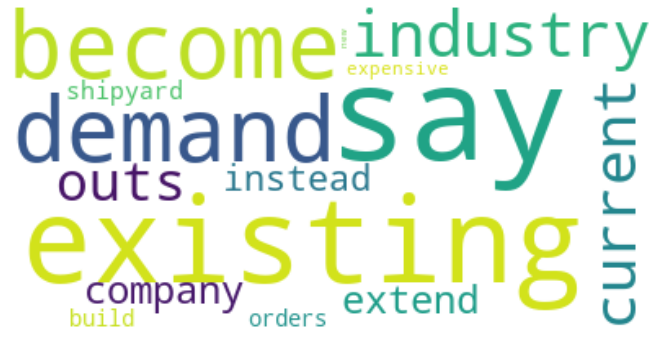

---------------------------------
dict_keys(['1970', 'recalling', 'early', 'next', 'might', 'finding', 'world', 'said', 'tanker', 'ways', 'number', 'reasons', 'freighter', '1980', 'shipping', 'experts', 'worry', 'fleet', 'case', 'seem', 'ripe', 'repeating', 'executives', 'time', 'life', 'businesses', 'capacity', 'reminiscent'])


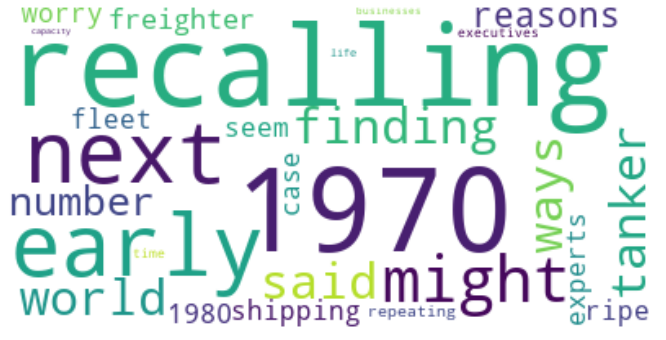

---------------------------------
dict_keys(['past', 'rates', 'lifts', 'rising', 'flood', 'face', 'softened', 'ship', 'papa', 'people', 'much', 'war', 'bulk', 'mistake', 'content', 'state', 'market', 'elderly', 'major', 'cargo', 'many'])


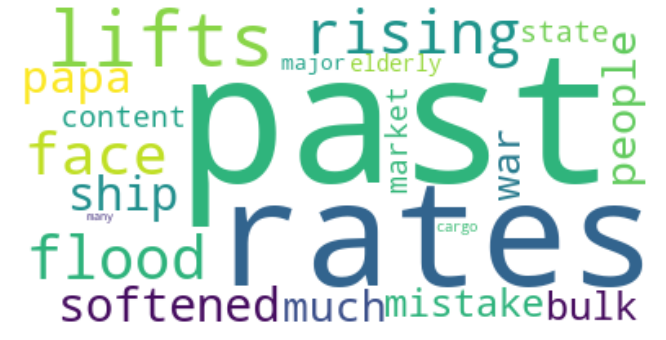

---------------------------------
dict_keys(['freight', 'year', 'ladies', 'grown', 'credit', 'also', 'made', 'subsidies'])


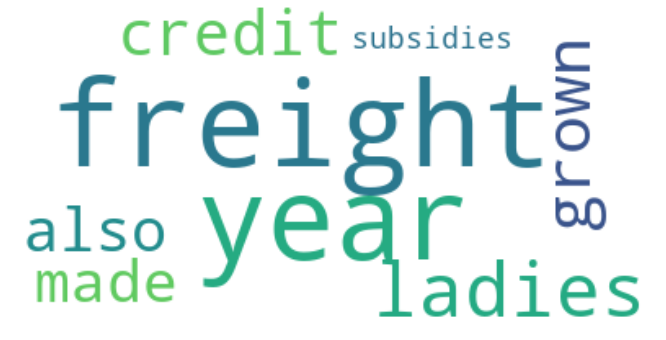

---------------------------------
dict_keys(['past', 'lifts', 'rates', 'face', 'rising', 'ship', 'flood', 'papa', 'softened', 'market', 'bulk', 'people', 'state', 'much', 'mistake', 'elderly', 'war', 'major', 'cargo', 'many'])


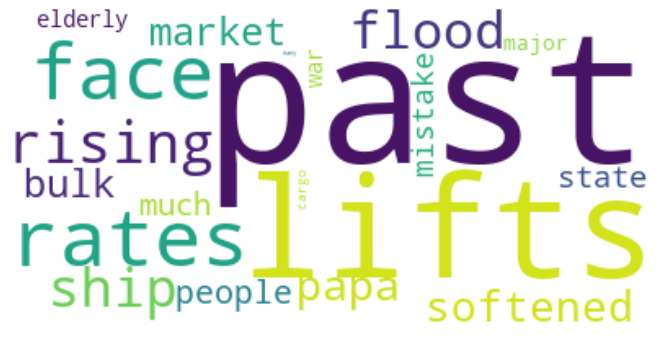

---------------------------------
dict_keys(['world', '1970', 'early', 'next', 'might', 'recalling', 'said', 'reasons', 'finding', 'number', 'tanker', 'ways', 'shipping', '1980', 'freighter', 'experts', 'fleet', 'worry', 'case', 'repeating', 'seem', 'ripe', 'executives', 'life', 'time', 'capacity', 'businesses', 'reminiscent'])


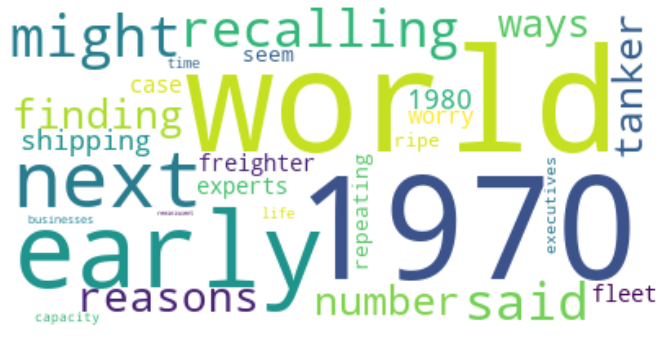

---------------------------------


In [77]:
import pandas as pd
import numpy as np

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
for item in list_word_cloud:
  wordcloud = WordCloud(collocations=True, background_color= 'White').generate_from_frequencies(item)
  
  #plot the wordcloud object
  print(item.keys())
  plt.imshow(wordcloud, interpolation='bilInear')
  plt.axis('off')
  plt.show()
  print('---------------------------------')